# Developing a unified representation of Alzheimer’s subtypes

# Part 4: Cluster Clincal Significance Assessment

After determining the potential unified representaions of the combined 3 subtypes, its important to understand if these groups have shared characteristics that provide some clinical significance to the findings. 
This notebook will assess the groups based on - diagnosis, age, gender, APOE4 carriers, MMSE scores, years of education, age at retirement  and lobe progression pattern asymmetry. 

## Import Packages

In [1]:
# import the python packages needed to generate simulated data for the tutorial
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pySuStaIn
from scipy import stats
from scipy.stats import linregress, shapiro, ttest_ind, mannwhitneyu, f_oneway, kruskal, chi2_contingency, fisher_exact, ttest_1samp, norm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import sklearn.model_selection
import sys
import shutil
import math
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*figure layout has changed to tight.*")
from itertools import combinations, product
from pathlib import Path
import pickle



sys.path.insert(0,'/Users/yuvalkesselmeilichson/Documents/Anaconda/Project/pySuStaIn/notebooks/')

## 1. Read relevant data

In [2]:
# Load and rename columns for MRI
zdata_mri = pd.read_csv("Train_MRI_SuStaIn_1.csv")
zdata_mri = zdata_mri.rename(columns={
    'ml_subtype': 'ml_subtype_MRI',
    'ml_stage': 'ml_stage_MRI'
})

# Load and rename columns for Aβ
zdata_ab = pd.read_csv("Train_AB_SuStaIn_2.csv")
zdata_ab = zdata_ab.rename(columns={
    'ml_subtype': 'ml_subtype_AB',
    'ml_stage': 'ml_stage_AB'
})

# Load and rename columns for Tau
zdata_tau = pd.read_csv("Train_TAU_SuStaIn_3.csv")
zdata_tau = zdata_tau.rename(columns={
    'ml_subtype': 'ml_subtype_TAU',
    'ml_stage': 'ml_stage_TAU'
})


In [3]:
# Define key columns and Column indicators for results of different modalities
rid = "RID"
dat = "EXAMDATE"
dx = "DIAGNOSIS_STRING"
diagnosis_num = "DIAGNOSIS" 
mmse_score = "MMSCORE" #memory scores - lower indicate more impairment
apoe4 = "APOE4" #presence of the gene APOE4
educ = "PTEDUCAT" #years of education
gender = "PTGENDER" #Gender- Male=1, Female=2
y_startadsym = "PTADBEG" #year of onset of AD symptoms
headsize_mri = "ICV_CorticalVolume" #overall headsize
y_of_birth = "PTDOBYY"
age = "Age"
retire_age = "AGE_RETIRE"
retirement = "PTNOTRT" #retired = 1, not retired = 0
y_retirement = "PTRTYR" #year of retirement

categories = [dx, age, mmse_score, apoe4, educ, gender, retire_age]
categories_mri = [diagnosis_num, age, mmse_score, apoe4, educ, gender, retire_age, headsize_mri]
asym_mri = ['Frontal_lobe_Asymmetry_MRI_L','Frontal_lobe_Asymmetry_MRI_R', 'Occipital_lobe_Asymmetry_MRI_L','Occipital_lobe_Asymmetry_MRI_R', 
        'Parietal_lobe_Asymmetry_MRI_L','Parietal_lobe_Asymmetry_MRI_R', 'Temporal_lobe_Asymmetry_MRI_L','Temporal_lobe_Asymmetry_MRI_R', 
        'MTL_Asymmetry_MRI_L','MTL_Asymmetry_MRI_R'] 
asym_ab = ['Frontal_lobe_Asymmetry_ab_L','Frontal_lobe_Asymmetry_ab_R', 'Occipital_lobe_Asymmetry_ab_L','Occipital_lobe_Asymmetry_ab_R', 
           'Parietal_lobe_Asymmetry_ab_L','Parietal_lobe_Asymmetry_ab_R', 'Temporal_lobe_Asymmetry_ab_L','Temporal_lobe_Asymmetry_ab_R', 
           'MTL_Asymmetry_ab_L', 'MTL_Asymmetry_ab_R']
asym_tau = ['Frontal_lobe_Asymmetry_tau_L','Frontal_lobe_Asymmetry_tau_R', 'Occipital_lobe_Asymmetry_tau_L','Occipital_lobe_Asymmetry_tau_R', 
        'Parietal_lobe_Asymmetry_tau_L','Parietal_lobe_Asymmetry_tau_R', 'Temporal_lobe_Asymmetry_tau_L','Temporal_lobe_Asymmetry_tau_R', 
        'MTL_Asymmetry_tau_L','MTL_Asymmetry_tau_R']



continuous_vars = [age, mmse_score, educ, retire_age]
categorical_vars = [dx, gender, apoe4]




In [4]:
def standardize_label(label, modality):
    # Map known patterns to standardized lobe names
    lobe_map = {
        "mtl": "MTL",
        "temporal": "Temporal_Lobe",
        "parietal": "Parietal_Lobe",
        "frontal": "Frontal_Lobe",
        "occipital": "Occipital_Lobe"
    }

    # Lowercase and remove suffixes
    label_clean = (
        label.lower()
        .replace("_suvr_weighted", "")
        .replace("_volume", "")
        .replace("_suvr", "")
        .replace("_weighted_tau", "")
        .replace("_", "")
    )

    # Match lobe name
    for key in lobe_map:
        if key in label_clean:
            return f"{lobe_map[key]}"
    
    return f"UnknownLobe"


In [5]:
#Sustain data per modality
N_startpoints = 50

#MRI
N_S_max_mri = 4
N_iterations_MCMC = int(1e5)
output_folder_mri = os.path.join(os.getcwd(), 'MRIOutput')
dataset_name_mri = 'MRIOutput'
pickle_filename_s_mri = output_folder_mri + '/pickle_files/' + dataset_name_mri + '_subtype' + str(N_S_max_mri-1) + '.pickle'
pk_mri = pd.read_pickle(pickle_filename_s_mri)
samples_sequence_mri = pk_mri["samples_sequence"]
samples_f_mri = pk_mri["samples_f"]

biomarkers_mri = ['Frontal_lobe_volume', 'Occipital_lobe_volume', 'Parietal_lobe_volume','Temporal_lobe_volume', 'MTL_volume']
N_mri = len(biomarkers_mri)    
SuStaInLabels_mri = [standardize_label(b, "MRI") for b in biomarkers_mri]
Z_vals_mri = np.array([[2,3,4.5]]*N_mri)     # Z-scores for each biomarker
Z_max_mri  = np.ceil(np.percentile(zdata_mri[biomarkers_mri].values,99,axis=0)).astype('int')           # maximum z-score

sustain_input_mri = pySuStaIn.ZscoreSustain(
                              zdata_mri[biomarkers_mri].values,
                              Z_vals_mri,
                              Z_max_mri,
                              SuStaInLabels_mri,
                              N_startpoints,
                              N_S_max_mri, 
                              N_iterations_MCMC, 
                              output_folder_mri, 
                              dataset_name_mri, 
                              False)

pickle_filepath_mri             = Path(pickle_filename_s_mri)
pickle_file_mri                 = open(pickle_filename_s_mri, 'rb')
loaded_variables_mri            = pickle.load(pickle_file_mri)
ml_subtype_mri                  = loaded_variables_mri["ml_subtype"]
prob_ml_subtype_mri             = loaded_variables_mri["prob_ml_subtype"]
ml_stage_mri                    = loaded_variables_mri["ml_stage"]
prob_ml_stage_mri               = loaded_variables_mri["prob_ml_stage"]
prob_subtype_mri                = loaded_variables_mri["prob_subtype"]
prob_stage_mri                  = loaded_variables_mri["prob_stage"]
prob_subtype_stage_mri          = loaded_variables_mri["prob_subtype_stage"]
ml_seq_mri                      = loaded_variables_mri["ml_sequence_EM"]
pickle_file_mri.close()    

#AB
N_S_max_ab = 2
output_folder_ab = os.path.join(os.getcwd(), 'ABOutput')
dataset_name_ab = 'ABOutput'
pickle_filename_s_ab = output_folder_ab + '/pickle_files/' + dataset_name_ab + '_subtype' + str(N_S_max_ab-1) + '.pickle'
pk_ab = pd.read_pickle(pickle_filename_s_ab)
samples_sequence_ab = pk_ab["samples_sequence"]
samples_f_ab = pk_ab["samples_f"]

biomarkers_ab = ['Frontal_lobe_SUVR_weighted_ab', 'Occipital_lobe_SUVR_weighted_ab','Parietal_lobe_SUVR_weighted_ab', 'Temporal_lobe_SUVR_weighted_ab','MTL_SUVR_weighted_ab']
N_ab = len(biomarkers_ab)      
SuStaInLabels_ab = [standardize_label(b, "AB") for b in biomarkers_ab]
Z_vals_ab = np.array([[1,2,3.5]]*N_ab)     # Z-scores for each biomarker
Z_max_ab  = np.ceil(np.percentile(zdata_ab[biomarkers_ab].values,99,axis=0)).astype('int')           # maximum z-score
sustain_input_ab = pySuStaIn.ZscoreSustain(
                              zdata_ab[biomarkers_ab].values,
                              Z_vals_ab,
                              Z_max_ab,
                              SuStaInLabels_ab,
                              N_startpoints,
                              N_S_max_ab, 
                              N_iterations_MCMC, 
                              output_folder_ab, 
                              dataset_name_ab, 
                              False)

pickle_filepath_ab             = Path(pickle_filename_s_ab)
pickle_file_ab                 = open(pickle_filename_s_ab, 'rb')
loaded_variables_ab            = pickle.load(pickle_file_ab)
ml_subtype_ab                  = loaded_variables_ab["ml_subtype"]
prob_ml_subtype_ab             = loaded_variables_ab["prob_ml_subtype"]
ml_stage_ab                    = loaded_variables_ab["ml_stage"]
prob_ml_stage_ab               = loaded_variables_ab["prob_ml_stage"]
prob_subtype_ab                = loaded_variables_ab["prob_subtype"]
prob_stage_ab                  = loaded_variables_ab["prob_stage"]
prob_subtype_stage_ab          = loaded_variables_ab["prob_subtype_stage"]
ml_seq_ab                      = loaded_variables_ab["ml_sequence_EM"]
pickle_file_ab.close()              


#TAU
N_S_max_tau = 4
output_folder_tau = os.path.join(os.getcwd(), 'TAUOutput')
dataset_name_tau = 'TAUOutput'
pickle_filename_s_tau = output_folder_tau + '/pickle_files/' + dataset_name_tau + '_subtype' + str(N_S_max_tau-1) + '.pickle'
pk_tau = pd.read_pickle(pickle_filename_s_tau)
samples_sequence_tau = pk_tau["samples_sequence"]
samples_f_tau = pk_tau["samples_f"]

biomarkers_tau = ['Frontal_lobe_SUVR_weighted_tau', 'Occipital_lobe_SUVR_weighted_tau', 'Parietal_lobe_SUVR_weighted_tau', 'Temporal_lobe_SUVR_weighted_tau', 'MTL_SUVR_weighted_tau']
N_tau = len(biomarkers_tau)         
SuStaInLabels_tau = [standardize_label(b, "TAU") for b in biomarkers_tau]
Z_vals_tau = np.array([[3,5,6.5]]*N_tau)     # Z-scores for each biomarker
Z_max_tau  = np.ceil(np.nanpercentile(zdata_tau[biomarkers_tau].values,99,axis=0)).astype('int')           # maximum z-score

sustain_input_tau = pySuStaIn.ZscoreSustain(
                              zdata_tau[biomarkers_tau].values,
                              Z_vals_tau,
                              Z_max_tau,
                              SuStaInLabels_tau,
                              N_startpoints,
                              N_S_max_tau, 
                              N_iterations_MCMC, 
                              output_folder_tau, 
                              dataset_name_tau, 
                              False)

pickle_filepath_tau             = Path(pickle_filename_s_tau)
pickle_file_tau                 = open(pickle_filename_s_tau, 'rb')
loaded_variables_tau            = pickle.load(pickle_file_tau)
ml_subtype_tau                  = loaded_variables_tau["ml_subtype"]
prob_ml_subtype_tau             = loaded_variables_tau["prob_ml_subtype"]
ml_stage_tau                    = loaded_variables_tau["ml_stage"]
prob_ml_stage_tau               = loaded_variables_tau["prob_ml_stage"]
prob_subtype_tau                = loaded_variables_tau["prob_subtype"]
prob_stage_tau                  = loaded_variables_tau["prob_stage"]
prob_subtype_stage_tau          = loaded_variables_tau["prob_subtype_stage"]
ml_seq_tau                      = loaded_variables_tau["ml_sequence_EM"]
pickle_file_tau.close()              


## 2. Characterise individual subtypes:

In [6]:
# === Effect size helpers ===
def cohen_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx -1)*np.var(x, ddof=1) + (ny -1)*np.var(y, ddof=1))/dof)
    return (np.mean(x) - np.mean(y)) / pooled_std

def eta_squared(F, df):
    df1, df2 = df
    return (F * df1) / (F * df1 + df2)

def epsilon_squared(H, N, k):
    return (H - k + 1) / (N - k)

def cramers_v(confusion_matrix):
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.values.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# === Post hoc Mann-Whitney U with Bonferroni correction ===
def pairwise_posthoc_mannwhitney(df, variable, group_col, alpha=0.05):
    groups = df[group_col].unique()
    pairs = list(combinations(groups, 2))
    results = []

    for g1, g2 in pairs:
        data1 = df[df[group_col] == g1][variable]
        data2 = df[df[group_col] == g2][variable]
        stat, p = mannwhitneyu(data1, data2, alternative='two-sided')
        results.append({'pair': f'{g1} vs {g2}', 'p_uncorrected': p})

    # Bonferroni correction
    m = len(results)
    for i, res in enumerate(results):
        p_corr = min(res['p_uncorrected'] * m, 1.0)
        res['p_bonferroni'] = p_corr
        res['significant'] = p_corr < alpha

    return pd.DataFrame(results)



====== AB Individual Subtype Analysis ======

 AGE (Continuous)
  Group sizes: {1.0: 850, 2.0: 22}
→ Mann-Whitney U test p = 0.8192


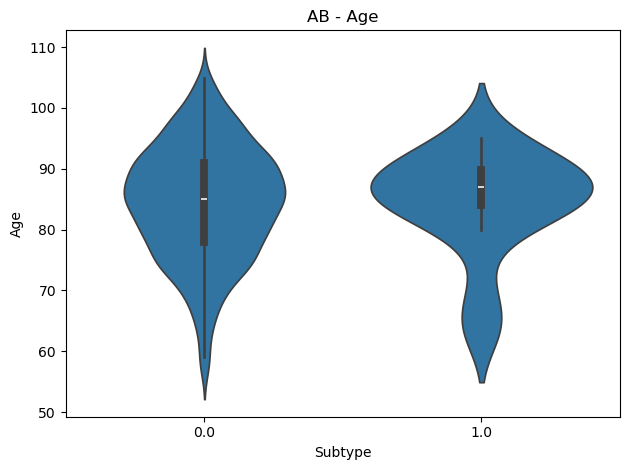


 MMSCORE (Continuous)
  Group sizes: {1.0: 165, 2.0: 2}
 Small sample size detected in at least one group.
→ Mann-Whitney U test p = 0.0922


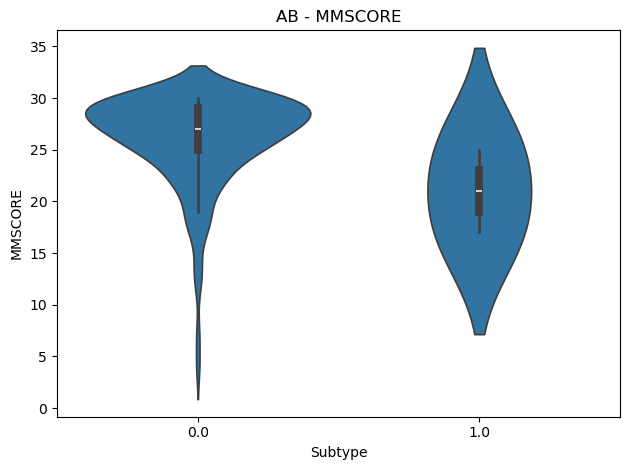


 PTEDUCAT (Continuous)
  Group sizes: {1.0: 850, 2.0: 22}
→ Mann-Whitney U test p = 0.9275


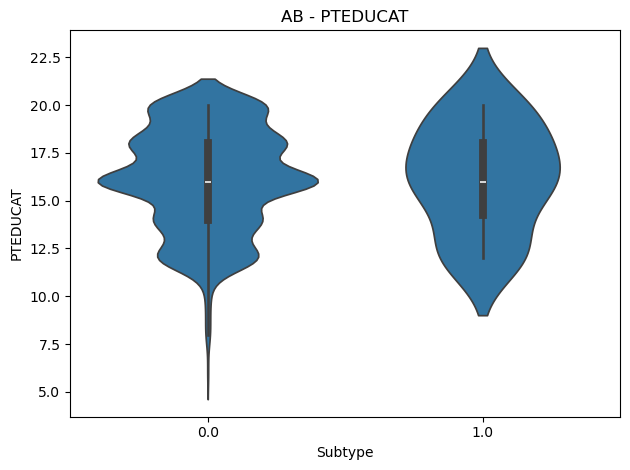


 AGE_RETIRE (Continuous)
  Group sizes: {1.0: 674, 2.0: 20}
→ Mann-Whitney U test p = 0.7661


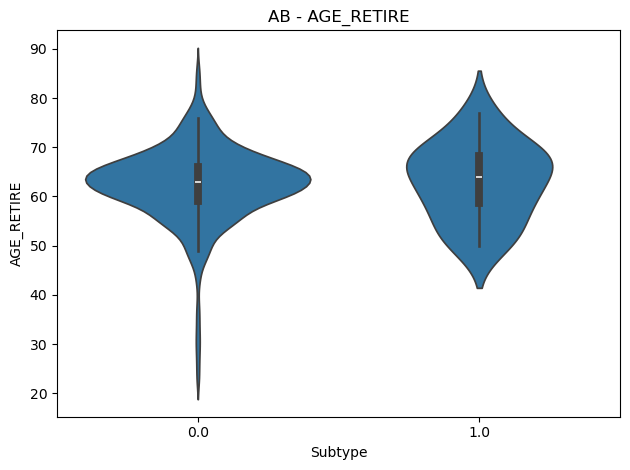



====== TAU Individual Subtype Analysis ======

 AGE (Continuous)
  Group sizes: {1.0: 268, 2.0: 233, 3.0: 52, 4.0: 24}
→ ANOVA p = 0.4303 | Eta² = 0.005


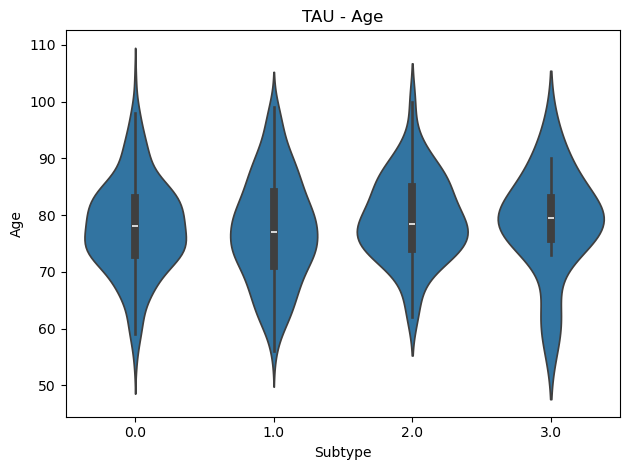


 MMSCORE (Continuous)
  Group sizes: {1.0: 35, 2.0: 37, 3.0: 11, 4.0: 3}
 Small sample size detected in at least one group.
→ Kruskal-Wallis p = 0.0018 | Epsilon² = 0.146


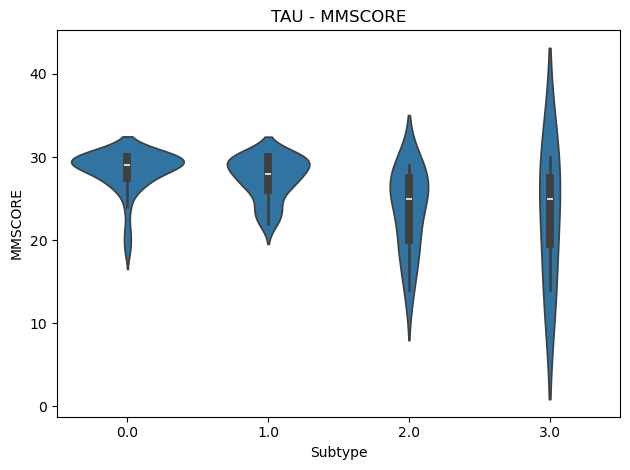


 PTEDUCAT (Continuous)
  Group sizes: {1.0: 268, 2.0: 233, 3.0: 52, 4.0: 24}
→ Kruskal-Wallis p = 0.0011 | Epsilon² = 0.023


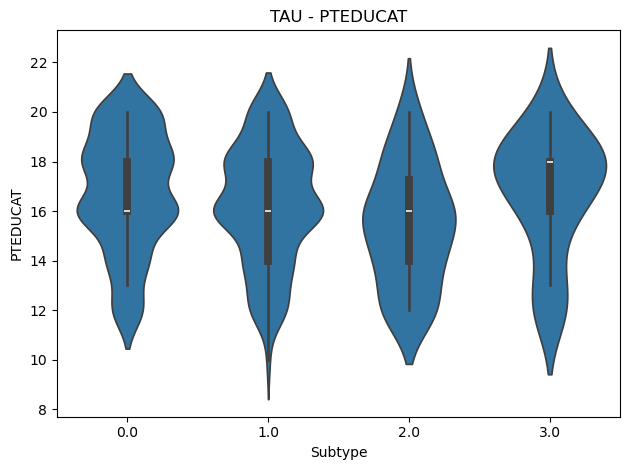


 AGE_RETIRE (Continuous)
  Group sizes: {1.0: 199, 2.0: 178, 3.0: 47, 4.0: 19}
→ Kruskal-Wallis p = 0.8433 | Epsilon² = -0.005


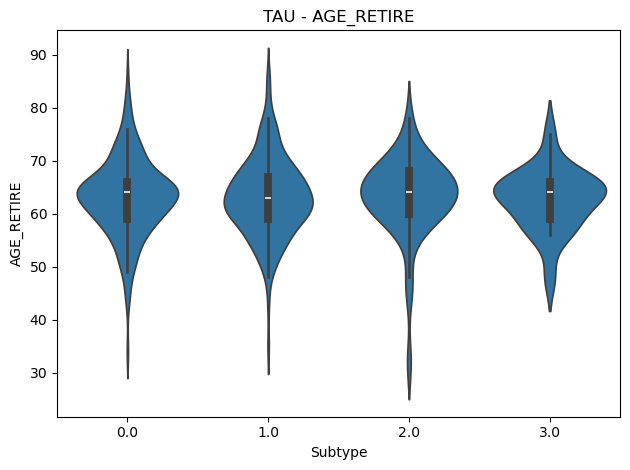



====== MRI Individual Subtype Analysis ======

 AGE (Continuous)
  Group sizes: {1.0: 1249, 2.0: 21, 3.0: 12, 4.0: 11}
→ Kruskal-Wallis p = 0.0000 | Epsilon² = 0.024


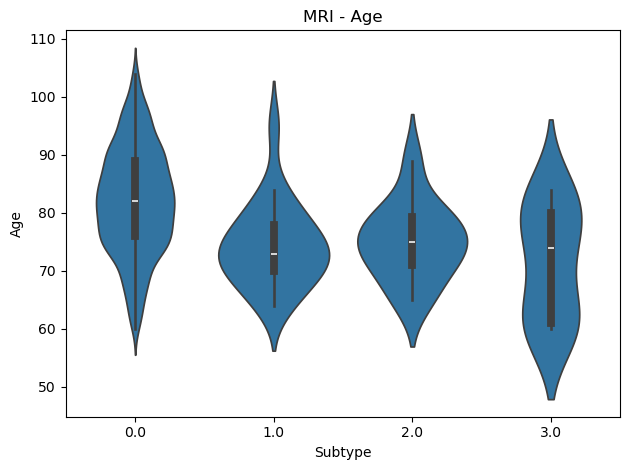


 MMSCORE (Continuous)
  Group sizes: {1.0: 1237, 2.0: 21, 3.0: 12, 4.0: 11}
→ Kruskal-Wallis p = 0.8170 | Epsilon² = -0.002


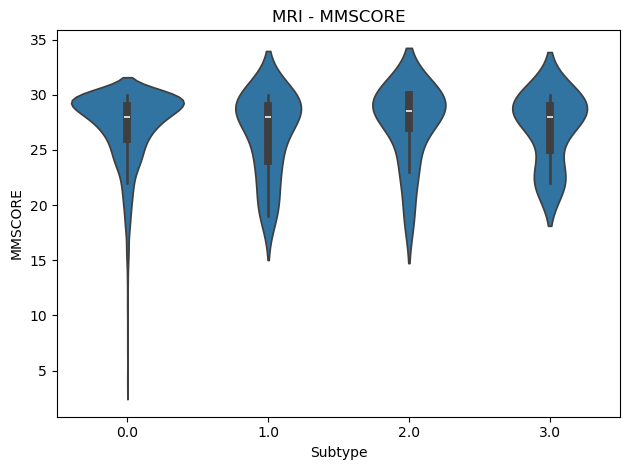


 PTEDUCAT (Continuous)
  Group sizes: {1.0: 1249, 2.0: 21, 3.0: 12, 4.0: 11}
→ Kruskal-Wallis p = 0.1015 | Epsilon² = 0.002


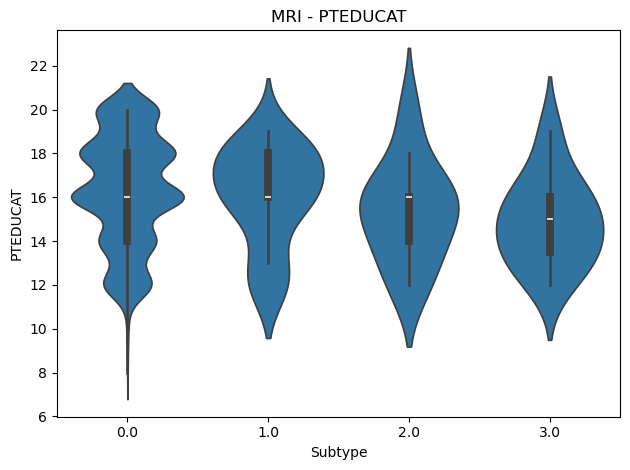


 AGE_RETIRE (Continuous)
  Group sizes: {1.0: 970, 2.0: 18, 3.0: 9, 4.0: 9}
→ Kruskal-Wallis p = 0.9449 | Epsilon² = -0.003


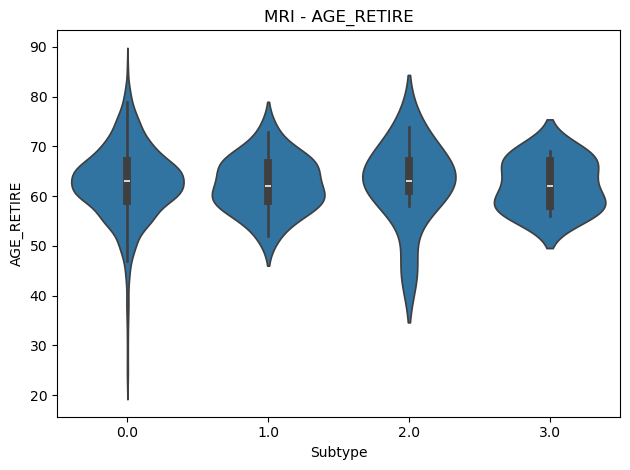



====== AB Individual Subtype Analysis ======

 DIAGNOSIS_STRING (Categorical)
 Expected cell count < 5 detected
 Fisher’s only supports 2x2; falling back to chi-squared.
→ Chi-squared p = 0.0000 | Cramér’s V = 0.155


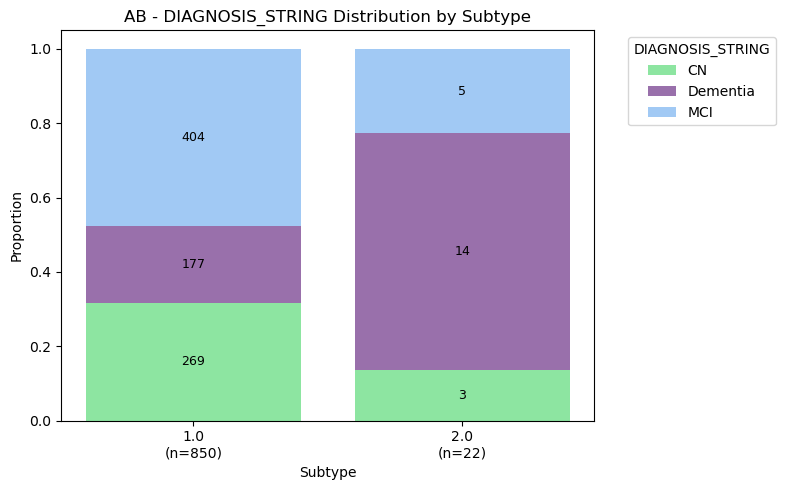


 PTGENDER (Categorical)
→ Chi-squared p = 0.0254 | Cramér’s V = 0.068


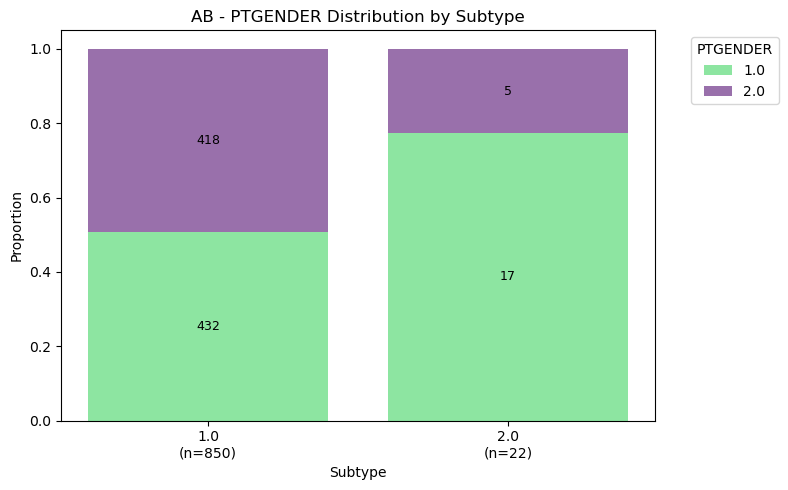


 APOE4 (Categorical)
 Expected cell count < 5 detected
 Fisher’s only supports 2x2; falling back to chi-squared.
→ Chi-squared p = 0.5402 | Cramér’s V = 0.000


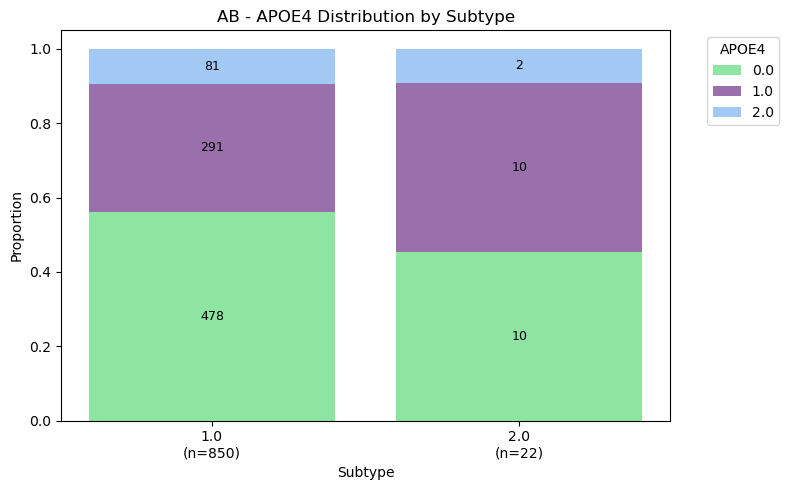



====== TAU Individual Subtype Analysis ======

 DIAGNOSIS_STRING (Categorical)
 Expected cell count < 5 detected
 Fisher’s only supports 2x2; falling back to chi-squared.
→ Chi-squared p = 0.0000 | Cramér’s V = 0.212


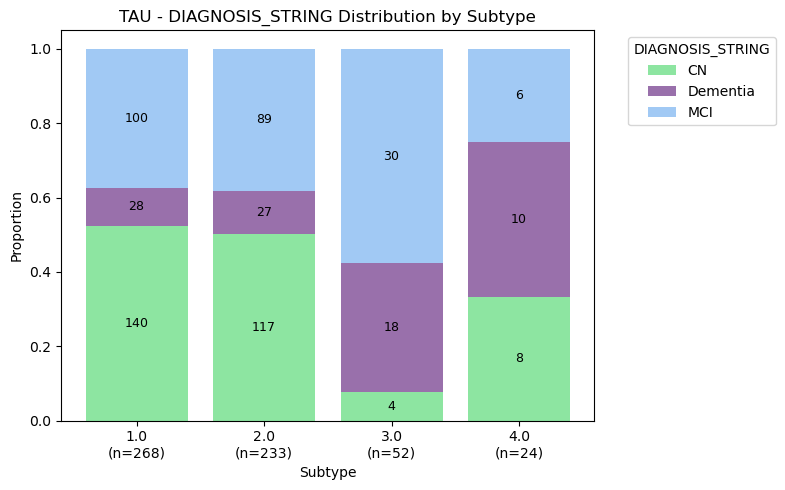


 PTGENDER (Categorical)
→ Chi-squared p = 0.2481 | Cramér’s V = 0.044


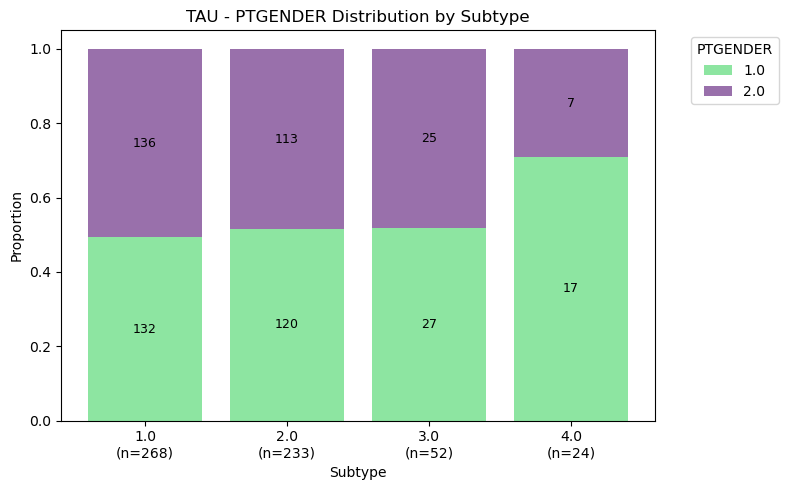


 APOE4 (Categorical)
 Expected cell count < 5 detected
 Fisher’s only supports 2x2; falling back to chi-squared.
→ Chi-squared p = 0.0000 | Cramér’s V = 0.162


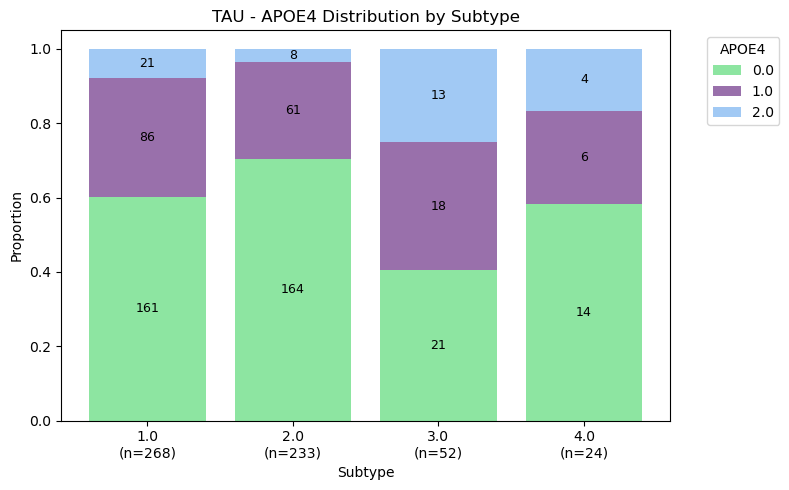



====== MRI Individual Subtype Analysis ======

 DIAGNOSIS_STRING (Categorical)
 Expected cell count < 5 detected
 Fisher’s only supports 2x2; falling back to chi-squared.
→ Chi-squared p = 0.0726 | Cramér’s V = 0.046


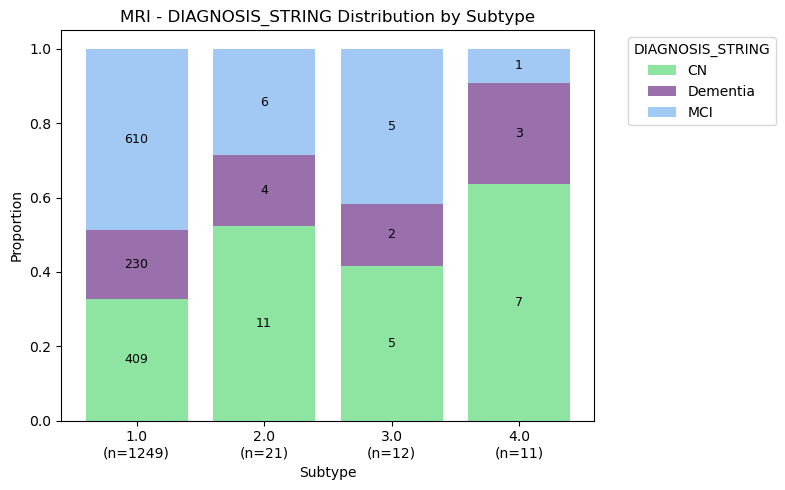


 PTGENDER (Categorical)
→ Chi-squared p = 0.8138 | Cramér’s V = 0.000


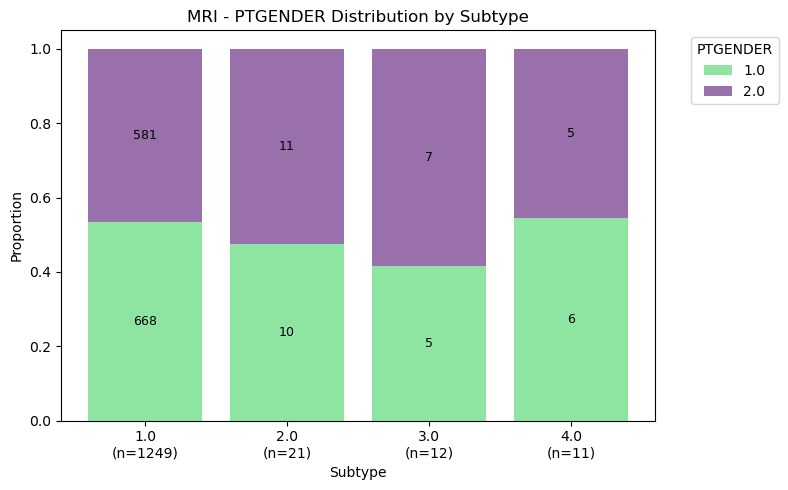


 APOE4 (Categorical)
 Expected cell count < 5 detected
 Fisher’s only supports 2x2; falling back to chi-squared.
→ Chi-squared p = 0.0618 | Cramér’s V = 0.048


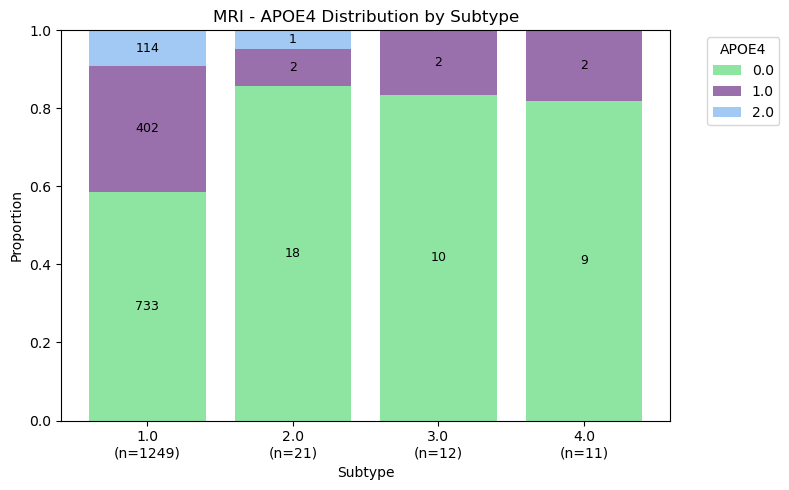

In [7]:
colors = ['#8de5a1', '#9970AB', '#a1c9f4']

modalities = {
    "AB": ('ml_subtype_AB', zdata_ab),
    "TAU": ('ml_subtype_TAU', zdata_tau),
    "MRI": ('ml_subtype_MRI', zdata_mri)
}

for modality, (subtype_col, df) in modalities.items():
    print(f"\n\n====== {modality} Individual Subtype Analysis ======")

    subtypes = sorted(df[subtype_col].dropna().unique())
    k = len(subtypes)
    
    # Create a color palette dictionary mapping subtype -> color cycling through my_colors
    color_cycle = (colors * ((k // len(colors)) + 1))[:k]
    my_palette = dict(zip([str(s + 1) for s in subtypes], color_cycle))  # +1 here


    # CONTINUOUS VARIABLES
    for var in continuous_vars:
        print(f"\n {var.upper()} (Continuous)")
        df_var = df.dropna(subset=[var, subtype_col])
        
        if var == mmse_score:
            df_var = df_var[df_var[var] > 0]
        if var == retire_age:
            df_var = df_var[df_var[var] > 0]

        grouped = [df_var[df_var[subtype_col] == s][var] for s in subtypes]
        sizes = [len(g) for g in grouped]
        print(f"  Group sizes: {dict(zip([s + 1 for s in subtypes], sizes))}")  # +1 here
        if any(n < 5 for n in sizes):
            print(" Small sample size detected in at least one group.")

        normal = all(shapiro(g)[1] > 0.05 for g in grouped if len(g) >= 3)

        if k == 2:
            x, y = grouped
            if normal:
                stat, p = ttest_ind(x, y, equal_var=False)
                d = cohen_d(x, y)
                print(f"→ Welch's t-test p = {p:.4f} | Cohen’s d = {d:.3f}")
            else:
                stat, p = mannwhitneyu(x, y)
                print(f"→ Mann-Whitney U test p = {p:.4f}")
        else:
            if normal:
                stat, p = f_oneway(*grouped)
                df1, df2 = k - 1, len(df_var) - k
                eta2 = eta_squared(stat, (df1, df2))
                print(f"→ ANOVA p = {p:.4f} | Eta² = {eta2:.3f}")
                if p < 0.05:
                    tukey_data = pd.concat([
                        pd.Series(g, name=var).to_frame().assign(subtype=s + 1)
                        for g, s in zip(grouped, subtypes)
                    ])
                    tukey = pairwise_tukeyhsd(tukey_data[var], tukey_data['subtype'])
                    print(tukey.summary())
            else:
                stat, p = kruskal(*grouped)
                eps2 = epsilon_squared(stat, len(df_var), k)
                print(f"→ Kruskal-Wallis p = {p:.4f} | Epsilon² = {eps2:.3f}")

        # Plot violin with your palette
        sns.violinplot(x=subtype_col, y=var, data=df_var)
        plt.title(f'{modality} - {var}')
        plt.xlabel("Subtype")  # Clarify on plot
        plt.ylabel(var)
        plt.tight_layout()
        plt.show()

    colors = ['#8de5a1', '#9970AB', '#a1c9f4']  # fixed order and set

for modality, (subtype_col, df) in modalities.items():
    print(f"\n\n====== {modality} Individual Subtype Analysis ======")

    subtypes = sorted(df[subtype_col].dropna().unique())
    k = len(subtypes)

    # Cycle colors exactly in order for subtypes, repeating if needed
    color_cycle = [colors[i % len(colors)] for i in range(k)]
    my_palette = dict(zip([str(s + 1) for s in subtypes], color_cycle))  # +1 here

    # CATEGORICAL VARIABLES
    # Inside your categorical variable loop
    for var in categorical_vars:
        print(f"\n {var.upper()} (Categorical)")
        if df[var].isnull().all():
            print(" Variable missing entirely.")
            continue

        table = pd.crosstab(df[subtype_col], df[var])
        expected = chi2_contingency(table, correction=False)[3]

        if (expected < 5).any():
            print(" Expected cell count < 5 detected")
            if table.shape == (2, 2):
                _, p = fisher_exact(table)
                print(f"→ Fisher’s Exact p = {p:.4f}")
            else:
                print(" Fisher’s only supports 2x2; falling back to chi-squared.")
                chi2, p, _, _ = chi2_contingency(table)
                v = cramers_v(table)
                print(f"→ Chi-squared p = {p:.4f} | Cramér’s V = {v:.3f}")
        else:
            chi2, p, _, _ = chi2_contingency(table)
            v = cramers_v(table)
            print(f"→ Chi-squared p = {p:.4f} | Cramér’s V = {v:.3f}")

        # Proportion DataFrame
        prop_df = table.div(table.sum(1), axis=0)
        subtype_counts = table.sum(axis=1)
        new_labels = [f"{s + 1}\n(n={n})" for s, n in subtype_counts.items()]  # +1 here

        # Extract unique sorted categories from column headers
        categories = list(prop_df.columns)
        color_list = colors[:len(categories)]  # Only take as many colors as needed
        cat_palette = dict(zip(categories, color_list))

        # Plot
        fig, ax = plt.subplots(figsize=(8, 5))
        bottom = np.zeros(len(prop_df))

        for i, category in enumerate(categories):
            proportions = prop_df[category].values
            counts = table[category].values
            bars = ax.bar(
                x=np.arange(len(prop_df)),
                height=proportions,
                bottom=bottom,
                color=color_list[i],
                label=category
            )

            # Add count labels inside each bar
            for j, bar in enumerate(bars):
                count = counts[j]
                if count > 0:
                    ax.text(
                        bar.get_x() + bar.get_width() / 2,
                        bar.get_y() + bar.get_height() / 2,
                        f'{int(count)}',
                        ha='center', va='center',
                        fontsize=9, color='black'
                    )

            bottom += proportions

        ax.set_title(f'{modality} - {var} Distribution by Subtype')
        ax.set_ylabel("Proportion")
        ax.set_xlabel("Subtype")
        ax.set_xticks(range(len(new_labels)))
        ax.set_xticklabels(new_labels)
        ax.legend(title=var, bbox_to_anchor=(1.05, 1))
        plt.tight_layout()
        plt.show()


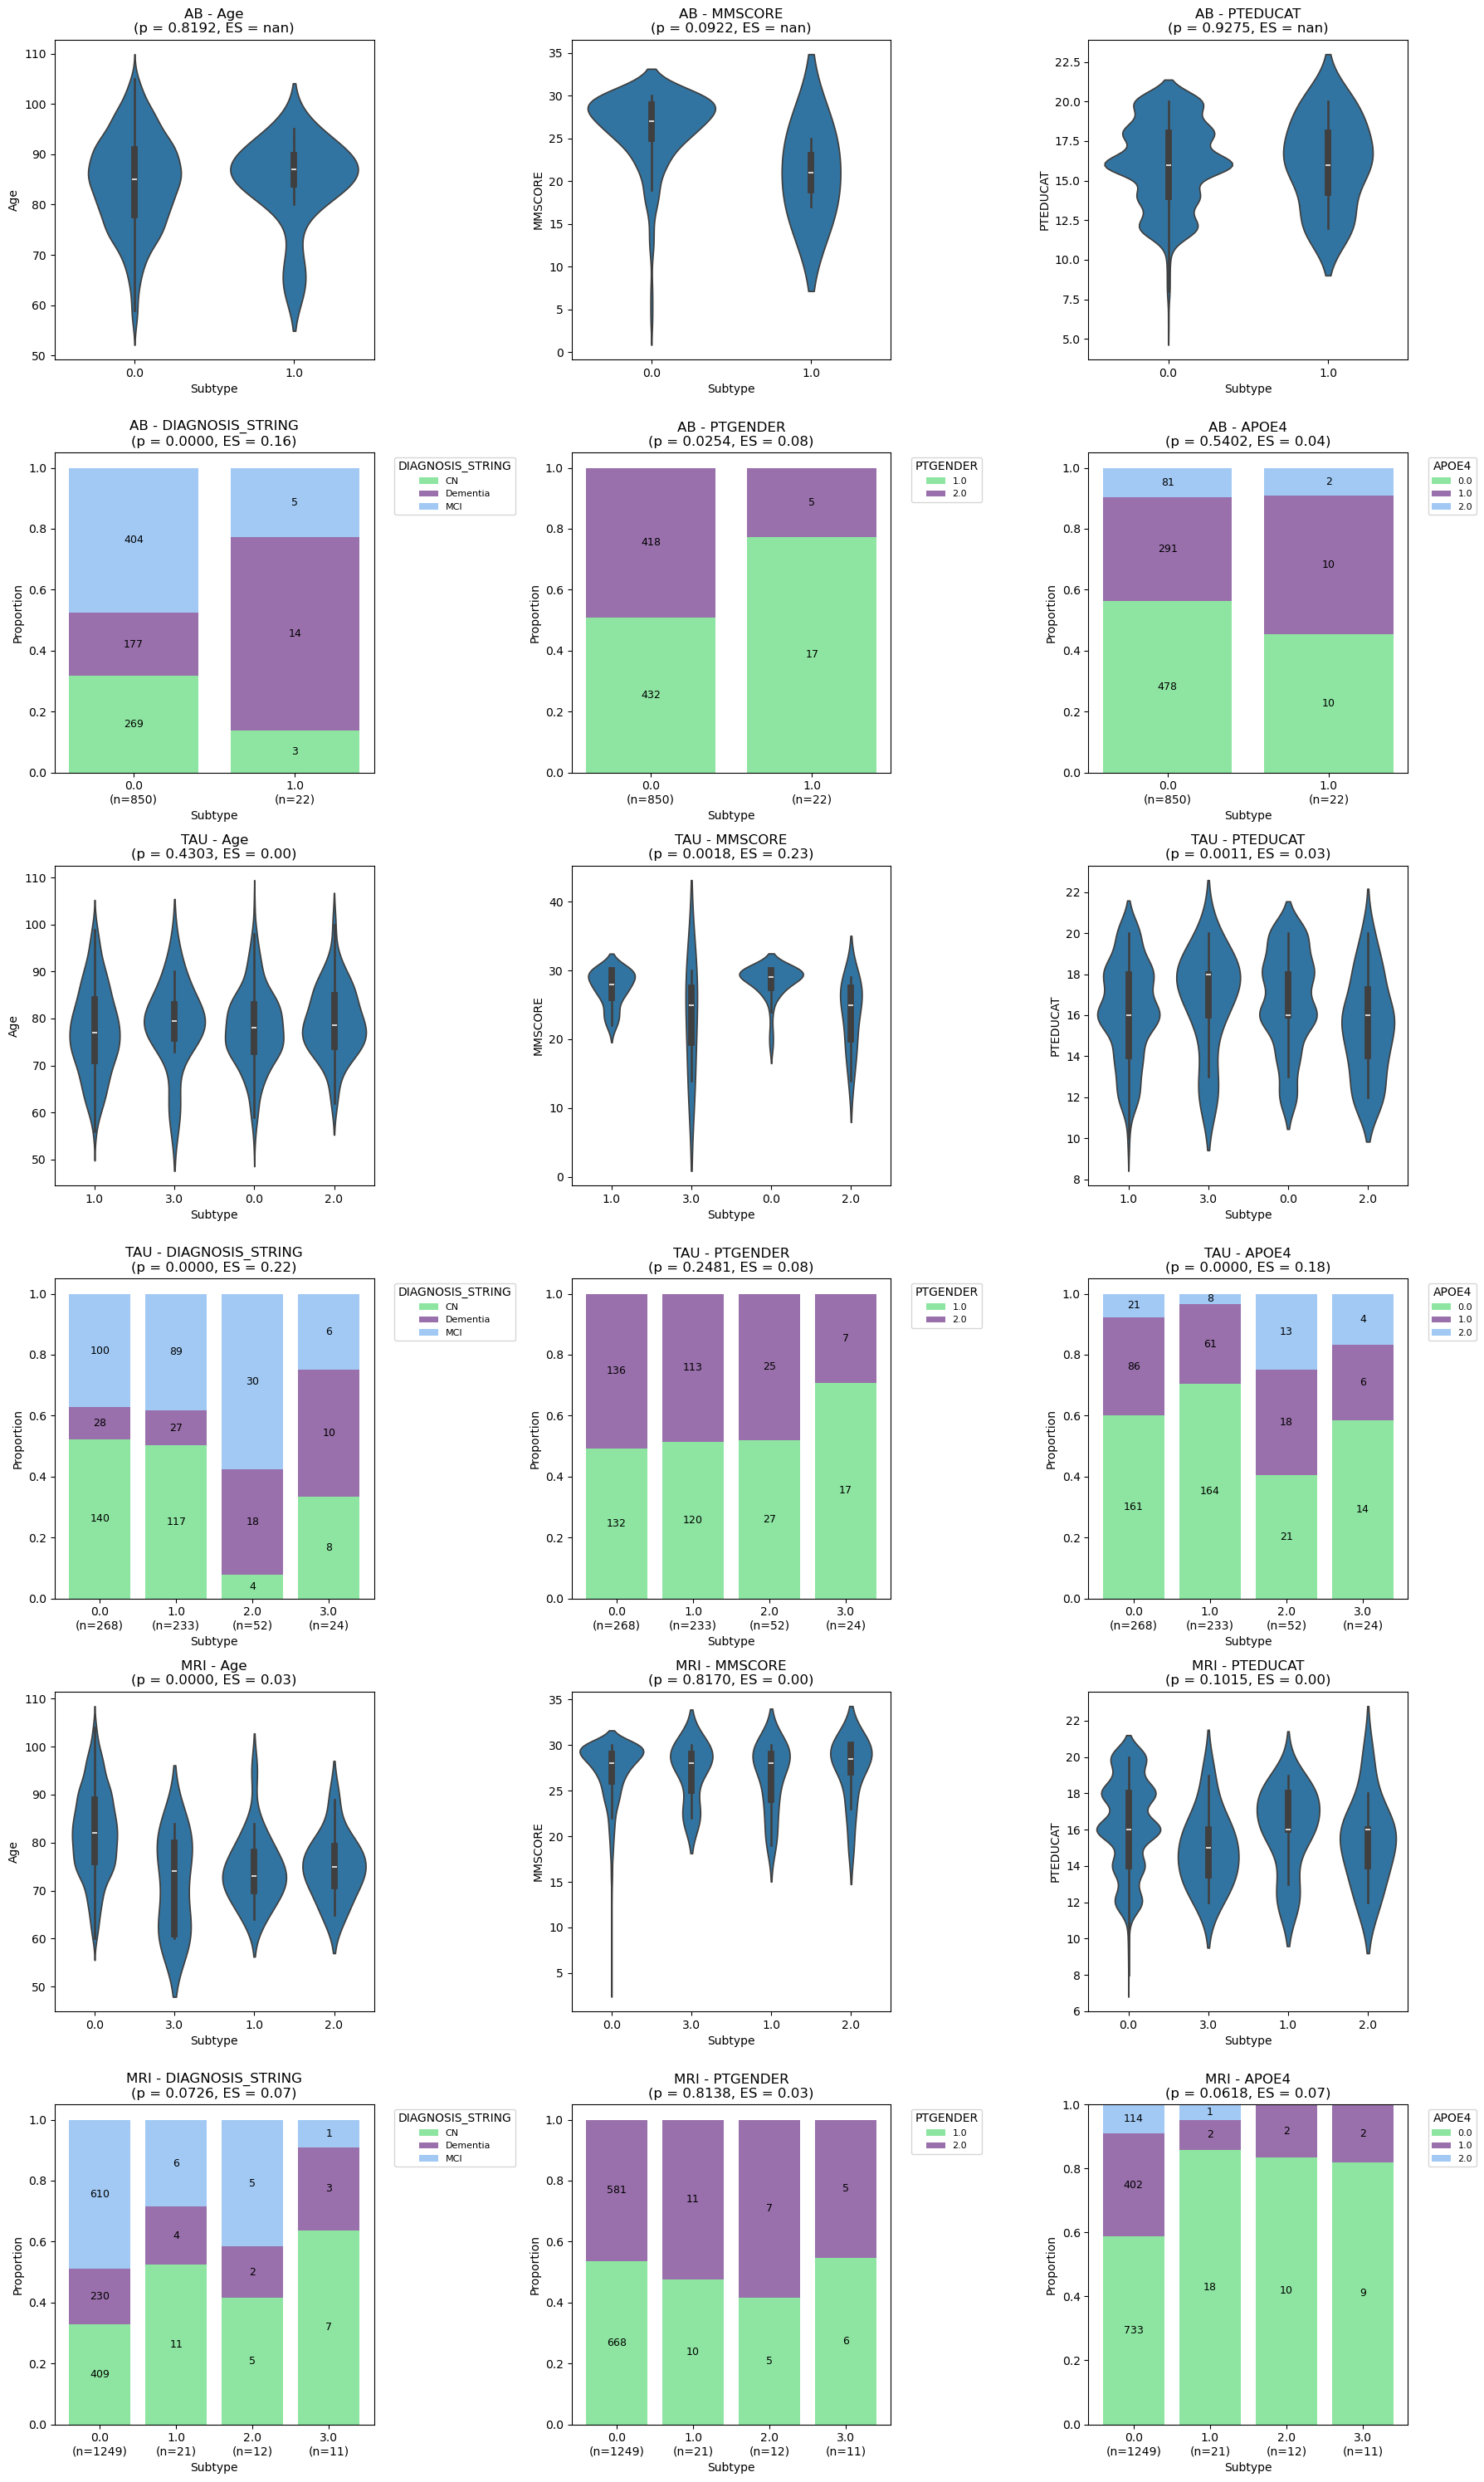

In [83]:

from scipy.stats import (
    ttest_ind, mannwhitneyu, f_oneway, kruskal, shapiro,
    chi2_contingency, fisher_exact
)
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Fixed color palette
colors = ['#8de5a1', '#9970AB', '#a1c9f4']

# Effect size functions
def cohen_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1)*np.var(x, ddof=1) + (ny - 1)*np.var(y, ddof=1)) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std

def eta_squared_f(groups):
    all_data = np.concatenate(groups)
    grand_mean = np.mean(all_data)
    ss_between = sum(len(g) * (np.mean(g) - grand_mean)**2 for g in groups)
    ss_total = sum((x - grand_mean)**2 for x in all_data)
    return ss_between / ss_total if ss_total != 0 else np.nan

def cramers_v(table):
    chi2, _, _, _ = chi2_contingency(table)
    n = table.sum().sum()
    phi2 = chi2 / n
    r, k = table.shape
    return np.sqrt(phi2 / (min(r - 1, k - 1)))

# Define variables
continuous_vars = [age, mmse_score, educ]
categorical_vars = [dx, gender, apoe4]
subtype_cols = {
    'AB': 'ml_subtype_AB',
    'TAU': 'ml_subtype_TAU',
    'MRI': 'ml_subtype_MRI'
}
df_dict = {
    'AB': zdata_ab,
    'TAU': zdata_tau,
    'MRI': zdata_mri
}

# Create plots
all_vars = continuous_vars + categorical_vars
n_plots = len(subtype_cols) * len(all_vars)
ncols = 3
nrows = int(np.ceil(n_plots / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*6, nrows*5))
axes = axes.flatten()

plot_idx = 0

for modality, subtype_col in subtype_cols.items():
    df = df_dict[modality].copy()
    df[subtype_col] = df[subtype_col].astype(str)
    
    for var in all_vars:
        ax = axes[plot_idx]
        plot_idx += 1
        pval = None
        effect_size = None

        if var in continuous_vars:
            # Filter MMSE = 0 
            if var == mmse_score:
                df_var = df[df[var] != 0].dropna(subset=[var, subtype_col])
            else:
                df_var = df.dropna(subset=[var, subtype_col])

            subtypes = sorted(df_var[subtype_col].unique())
            grouped = [df_var[df_var[subtype_col] == s][var] for s in subtypes]

            # Normality test
            normal = all(shapiro(g)[1] > 0.05 for g in grouped if len(g) >= 3)

            k = len(subtypes)
            if k == 2:
                x, y = grouped
                if normal:
                    _, pval = ttest_ind(x, y, equal_var=False)
                    effect_size = cohen_d(x, y)
                else:
                    _, pval = mannwhitneyu(x, y)
                    effect_size = np.nan
            else:
                if normal:
                    _, pval = f_oneway(*grouped)
                else:
                    _, pval = kruskal(*grouped)
                effect_size = eta_squared_f(grouped)

            sns.violinplot(x=subtype_col,y=var,data=df_var,ax=ax)
            ax.set_xlabel("Subtype")
            ax.set_ylabel(var)

        elif var in categorical_vars:
            df_var = df.dropna(subset=[var, subtype_col])
            table = pd.crosstab(df_var[subtype_col], df_var[var])
            if table.empty:
                continue
            expected = chi2_contingency(table, correction=False)[3]
            if (expected < 5).any():
                if table.shape == (2, 2):
                    _, pval = fisher_exact(table)
                else:
                    chi2, pval, _, _ = chi2_contingency(table)
            else:
                chi2, pval, _, _ = chi2_contingency(table)
            effect_size = cramers_v(table)

            prop_df = table.div(table.sum(1), axis=0)
            subtype_counts = table.sum(axis=1)
            new_labels = [f"{s}\n(n={n})" for s, n in subtype_counts.items()]

            categories = list(prop_df.columns)
            color_list = colors[:len(categories)]
            bottom = np.zeros(len(prop_df))

            for i, category in enumerate(categories):
                proportions = prop_df[category].values
                counts = table[category].values
                bars = ax.bar(x=np.arange(len(prop_df)),height=proportions,bottom=bottom,color=color_list[i],label=category)
                for j, bar in enumerate(bars):
                    count = counts[j]
                    if count > 0:
                        ax.text(
                            bar.get_x() + bar.get_width()/2,
                            bar.get_y() + bar.get_height()/2,
                            f'{int(count)}',
                            ha='center', va='center',
                            fontsize=9, color='black'
                        )
                bottom += proportions

            ax.set_ylabel("Proportion")
            ax.set_xlabel("Subtype")
            ax.set_xticks(range(len(new_labels)))
            ax.set_xticklabels(new_labels)
            ax.legend(title=var, bbox_to_anchor=(1.05, 1), fontsize=8)

        # Annotate title
        if pval is not None:
            if effect_size is not None:
                ax.set_title(f'{modality} - {var}\n(p = {pval:.4f}, ES = {effect_size:.2f})')
            else:
                ax.set_title(f'{modality} - {var}\n(p = {pval:.4f})')
        else:
            ax.set_title(f'{modality} - {var}')

# Remove empty axes
for i in range(plot_idx, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()
fig.savefig("all_variables_subplots_with_pvalues.png", dpi=300)


In [8]:
# Assess individual subtype characteristics
zdata_ab.groupby('ml_subtype_AB')[continuous_vars].agg(['mean', 'std'])


Age             MMSCORE              PTEDUCAT            \
                    mean       std      mean        std       mean       std   
ml_subtype_AB                                                                  
0.0            84.421176  9.409367  5.072941  10.518562  16.109412  2.654601   
1.0            84.363636  8.437701  1.909091   6.301240  16.181818  2.771219   

              AGE_RETIRE             
                    mean        std  
ml_subtype_AB                        
0.0            49.507059  26.232099  
1.0            57.227273  19.954548

In [9]:
zdata_tau.groupby('ml_subtype_TAU')[continuous_vars].agg(['mean', 'std'])


Age             MMSCORE              PTEDUCAT            \
                     mean       std      mean        std       mean       std   
ml_subtype_TAU                                                                  
0.0             77.884328  8.378100  3.701493   9.610801  16.731343  2.370746   
1.0             77.304721  9.283227  4.364807  10.116560  16.206009  2.365440   
2.0             79.384615  7.436407  4.980769   9.947885  15.423077  2.387436   
3.0             78.708333  8.917395  2.875000   8.136405  16.708333  2.440227   

               AGE_RETIRE             
                     mean        std  
ml_subtype_TAU                        
0.0             46.861940  28.346300  
1.0             48.227468  27.639376  
2.0             57.115385  20.139371  
3.0             49.583333  26.475447

In [10]:
zdata_mri.groupby('ml_subtype_MRI')[continuous_vars].agg(['mean', 'std'])

Age              MMSCORE             PTEDUCAT            \
                     mean       std       mean       std       mean       std   
ml_subtype_MRI                                                                  
0.0             82.112090  9.282959  26.841473  4.225098  16.298639  2.516867   
1.0             74.333333  7.129750  26.428571  3.654743  16.047619  2.224324   
2.0             75.000000  6.605783  27.333333  3.498918  15.333333  2.309401   
3.0             71.363636  9.790533  27.000000  3.130495  14.909091  2.022600   

               AGE_RETIRE             
                     mean        std  
ml_subtype_MRI                        
0.0             48.705364  26.965011  
1.0             53.380952  22.863675  
2.0             46.916667  29.112504  
3.0             50.909091  25.563468

In [11]:
pd.crosstab(zdata_ab['ml_subtype_AB'], zdata_ab[dx], normalize='index') * 100


DIAGNOSIS_STRING         CN   Dementia        MCI
ml_subtype_AB                                    
0.0               31.647059  20.823529  47.529412
1.0               13.636364  63.636364  22.727273

In [12]:
pd.crosstab(zdata_tau['ml_subtype_TAU'], zdata_tau[dx], normalize='index') * 100

DIAGNOSIS_STRING         CN   Dementia        MCI
ml_subtype_TAU                                   
0.0               52.238806  10.447761  37.313433
1.0               50.214592  11.587983  38.197425
2.0                7.692308  34.615385  57.692308
3.0               33.333333  41.666667  25.000000

In [13]:
pd.crosstab(zdata_mri['ml_subtype_MRI'], zdata_mri[dx], normalize='index') * 100

DIAGNOSIS_STRING         CN   Dementia        MCI
ml_subtype_MRI                                   
0.0               32.746197  18.414732  48.839071
1.0               52.380952  19.047619  28.571429
2.0               41.666667  16.666667  41.666667
3.0               63.636364  27.272727   9.090909


======= Plotting for AB subtypes =======



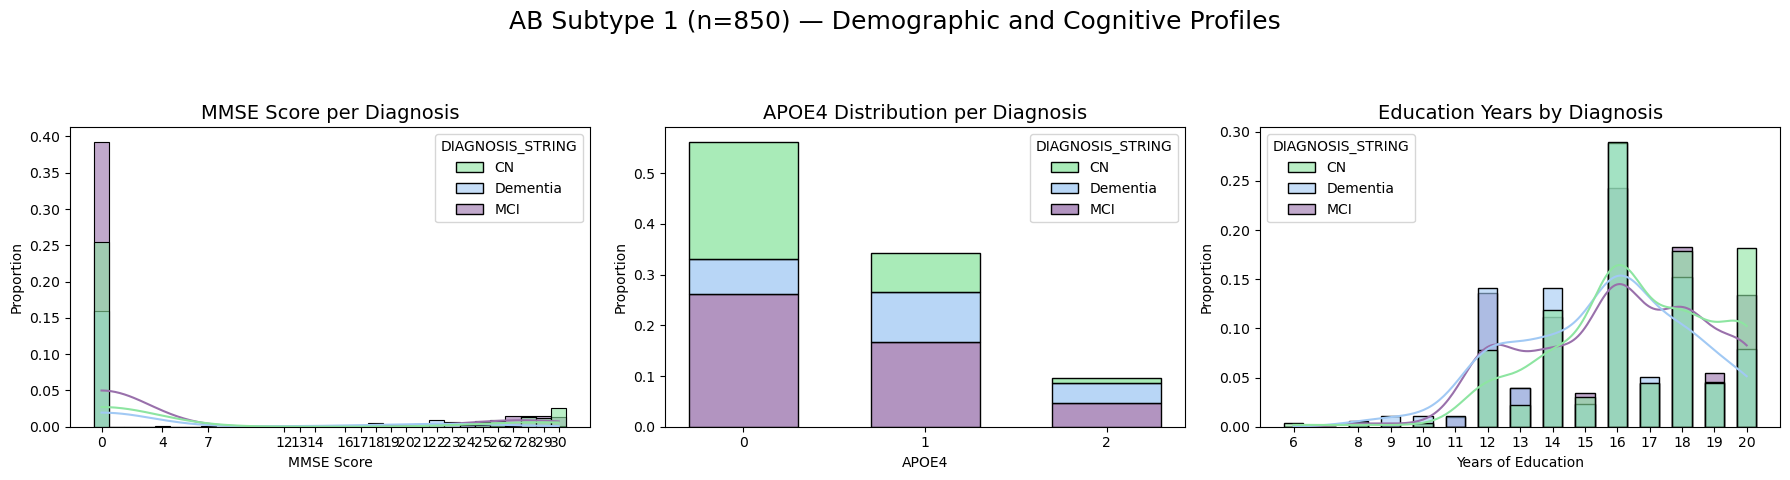

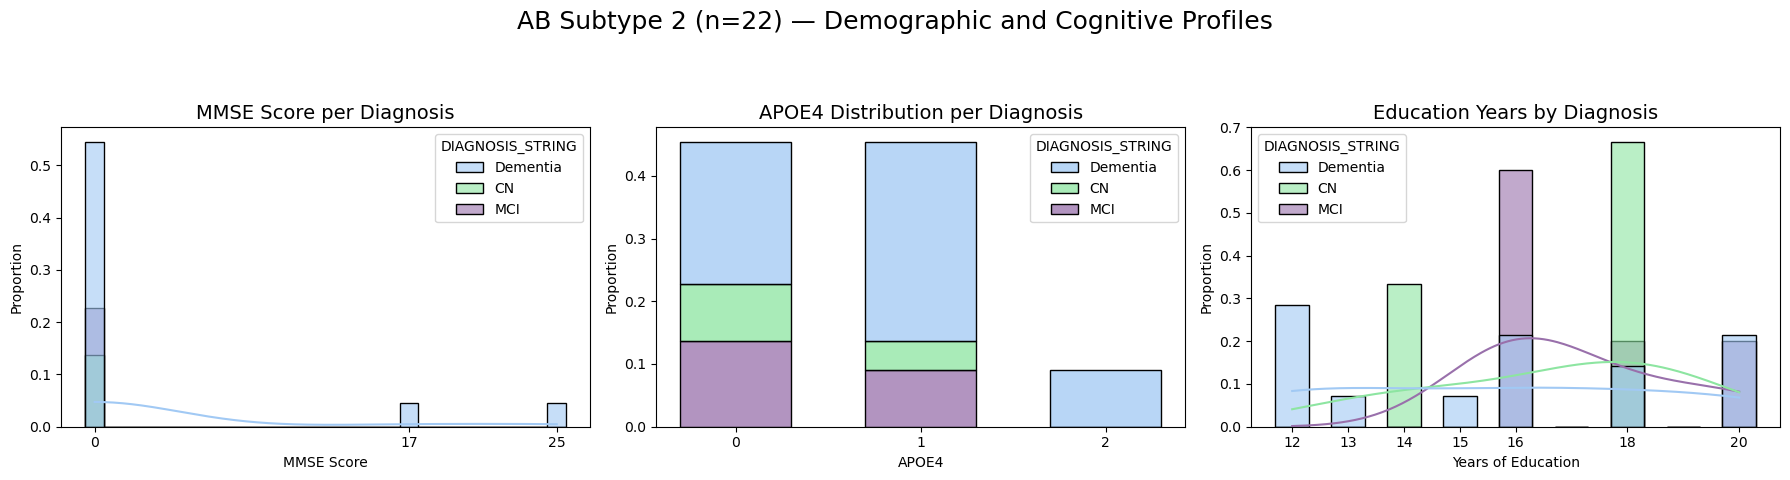


======= Plotting for TAU subtypes =======



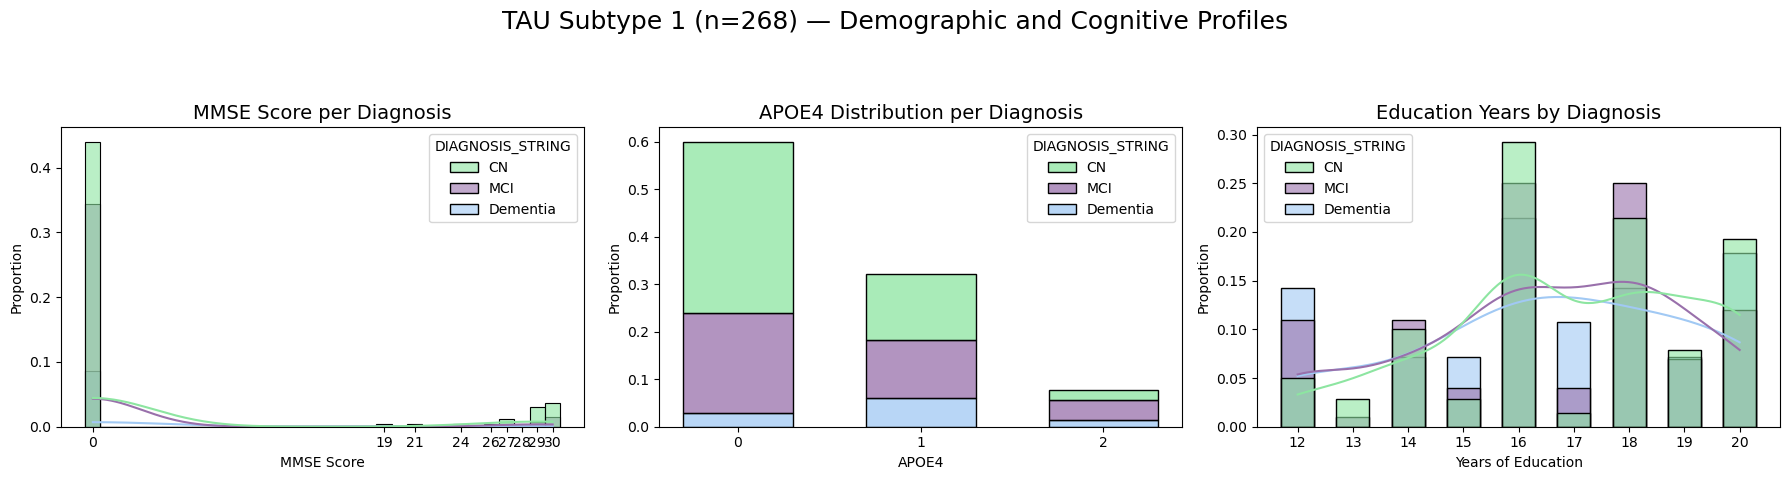

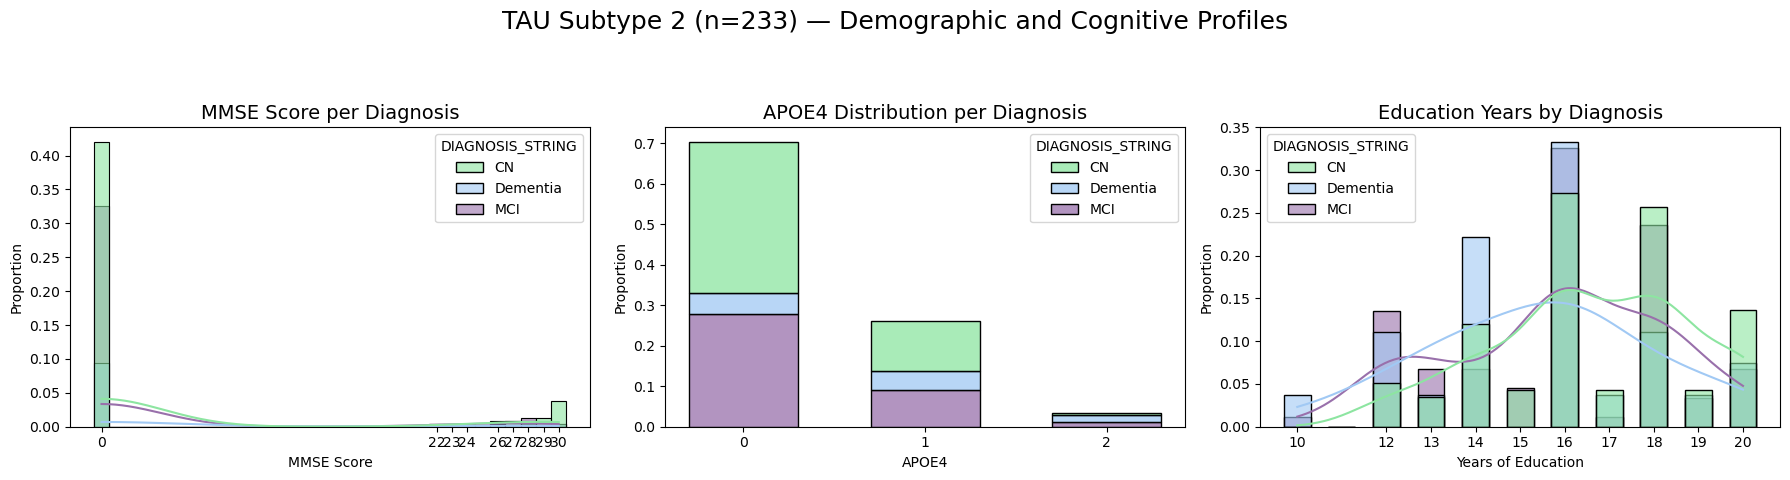

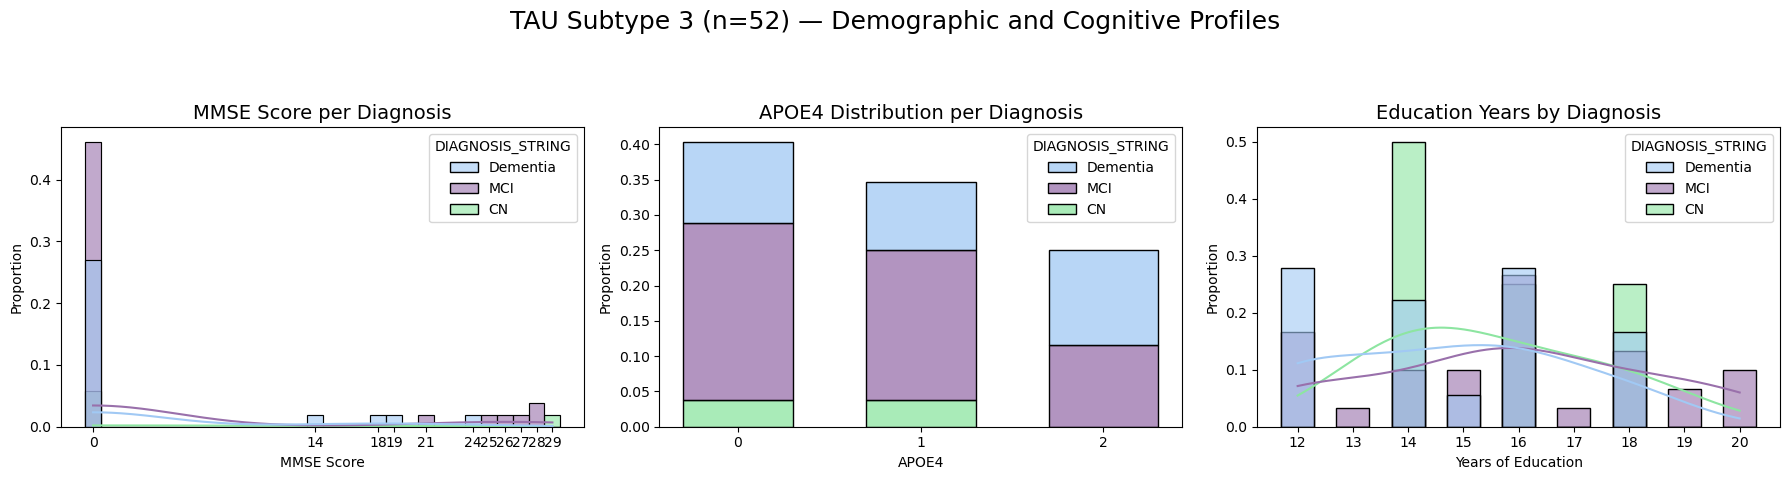

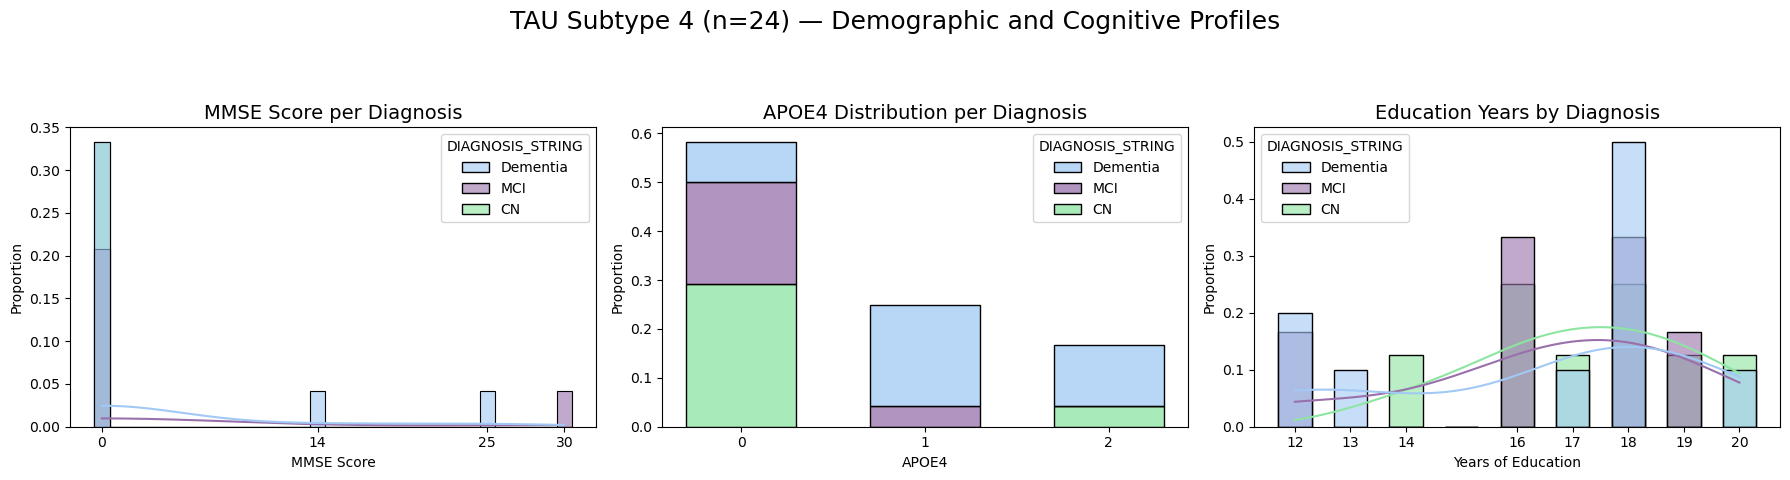


======= Plotting for MRI subtypes =======



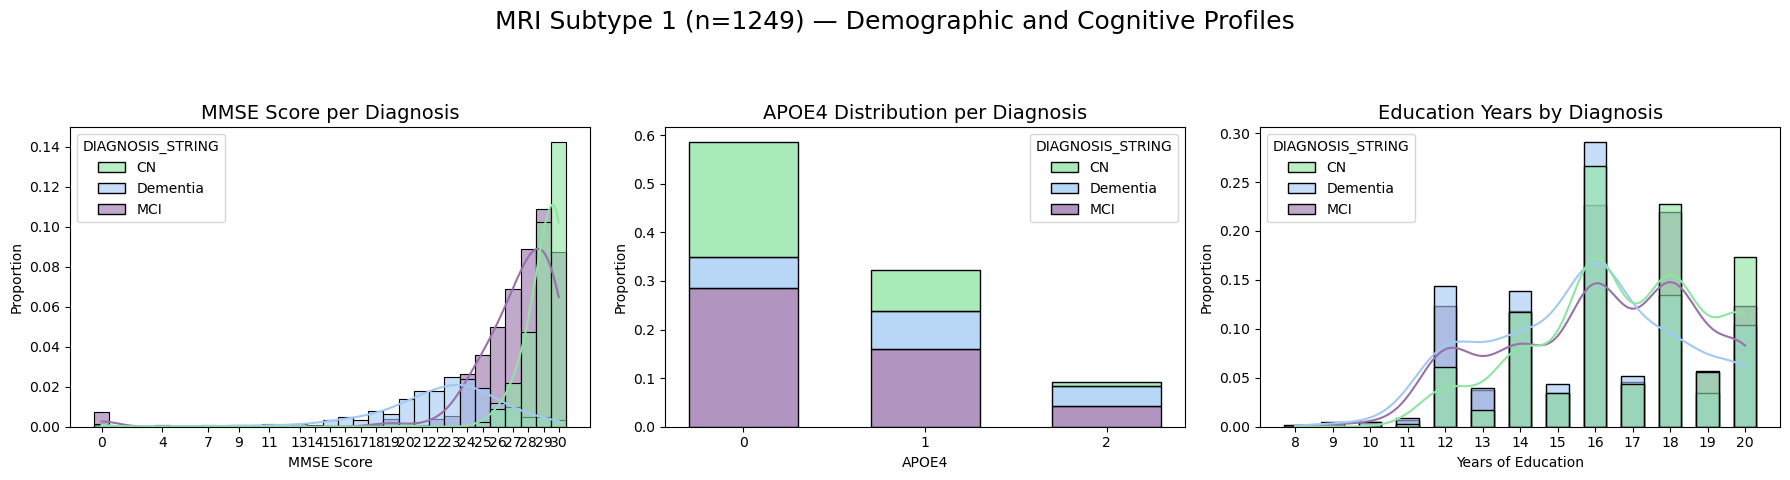

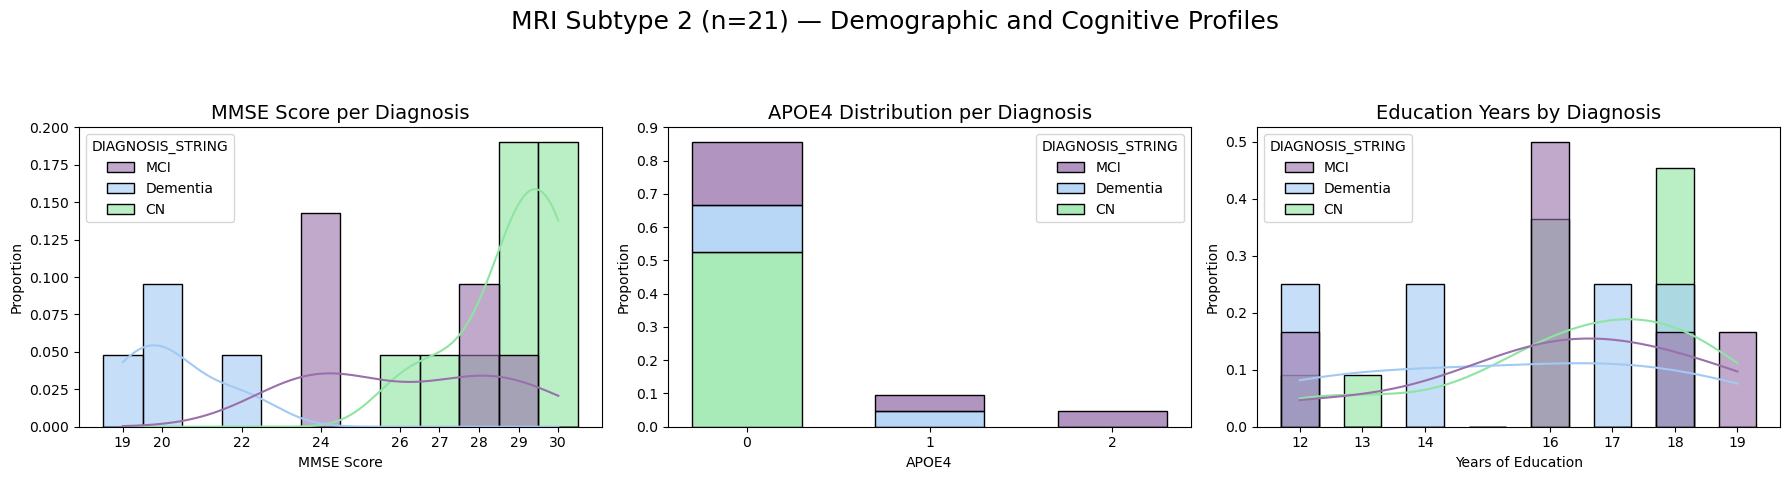

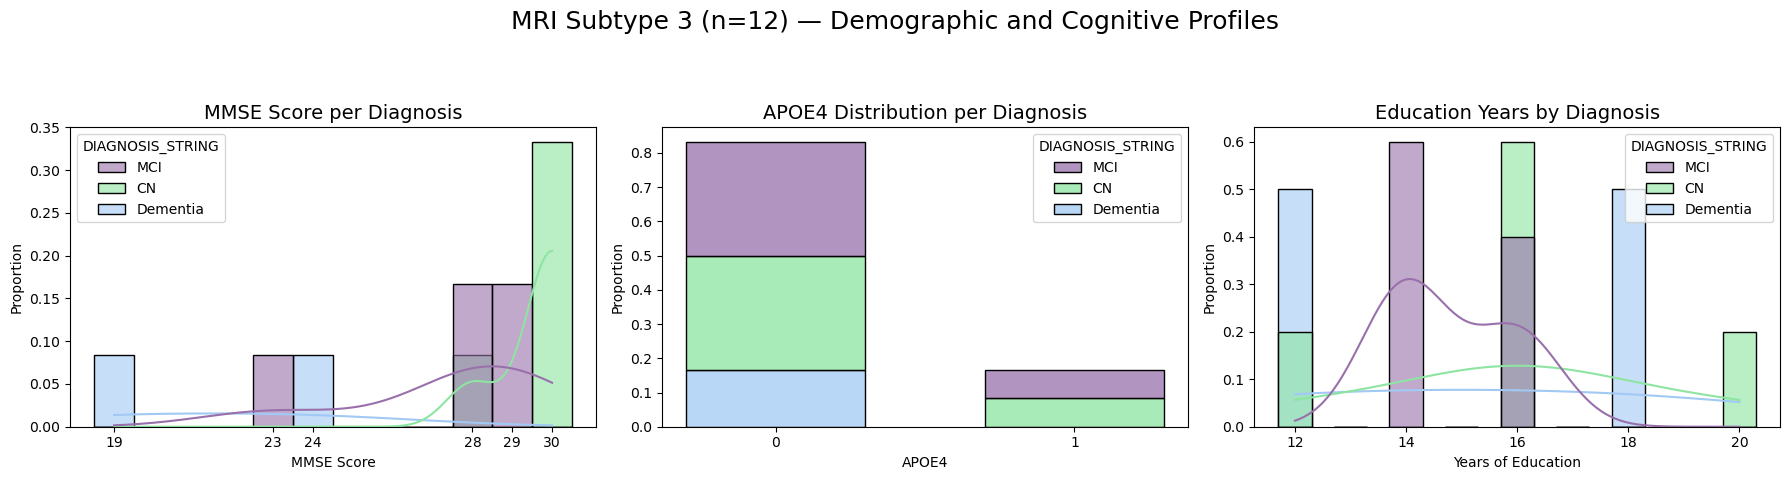

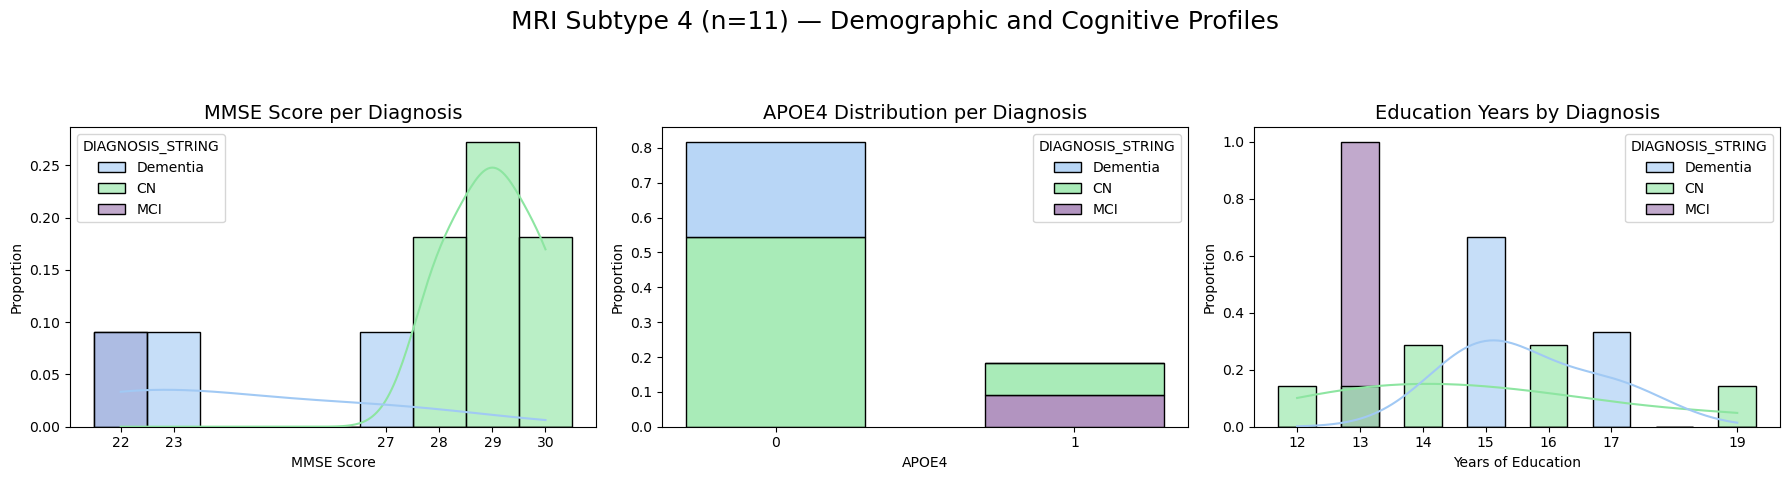

In [14]:
# Define modality datasets
modalities = {
    "AB": ('ml_subtype_AB', zdata_ab),
    "TAU": ('ml_subtype_TAU', zdata_tau),
    "MRI": ('ml_subtype_MRI', zdata_mri)
}

diagnosis_palette = {
    'CN': '#8de5a1',       
    'MCI': '#9970AB',      
    'Dementia': '#a1c9f4'  
}

for modality, (subtype_col, df) in modalities.items():
    print(f"\n======= Plotting for {modality} subtypes =======\n")

    for subtype in sorted(df[subtype_col].dropna().unique()):
        subset_df = df[df[subtype_col] == subtype]

        fig, axs = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle(f"{modality} Subtype {int(subtype)+1} (n={len(subset_df)}) — Demographic and Cognitive Profiles", fontsize=18)
        plt.subplots_adjust(wspace=0.3)

        # MMSE
        sns.histplot(data=subset_df, x=mmse_score, hue=dx, kde=True, palette=diagnosis_palette, multiple="layer",
                     alpha=0.6, ax=axs[0], stat="probability", discrete=True)
        axs[0].set_title("MMSE Score per Diagnosis", fontsize=14)
        axs[0].set_xlabel("MMSE Score")
        axs[0].set_ylabel("Proportion")
        axs[0].set_xticks(sorted(subset_df[mmse_score].dropna().unique()))

        # APOE4
        sns.histplot(data=subset_df, x=apoe4, hue=dx, multiple="stack", palette=diagnosis_palette,
                     ax=axs[1], stat="probability", discrete=True, shrink=0.6)
        axs[1].set_title("APOE4 Distribution per Diagnosis", fontsize=14)
        axs[1].set_xlabel("APOE4")
        axs[1].set_ylabel("Proportion")
        axs[1].set_xticks(sorted(subset_df[apoe4].dropna().unique()))

        # Education
        sns.histplot(data=subset_df, x=educ, hue=dx, kde=True, multiple="layer", palette=diagnosis_palette,
                     alpha=0.6, ax=axs[2], stat="probability", common_norm=False,
                     discrete=True, shrink=0.6)
        axs[2].set_title("Education Years by Diagnosis", fontsize=14)
        axs[2].set_xlabel("Years of Education")
        axs[2].set_ylabel("Proportion")
        axs[2].set_xticks(sorted(subset_df[educ].dropna().unique()))

        plt.tight_layout(rect=[0, 0.03, 1, 0.90])
        plt.show()



======= Gender Representation in AB Subtypes (Proportional to Overall) =======


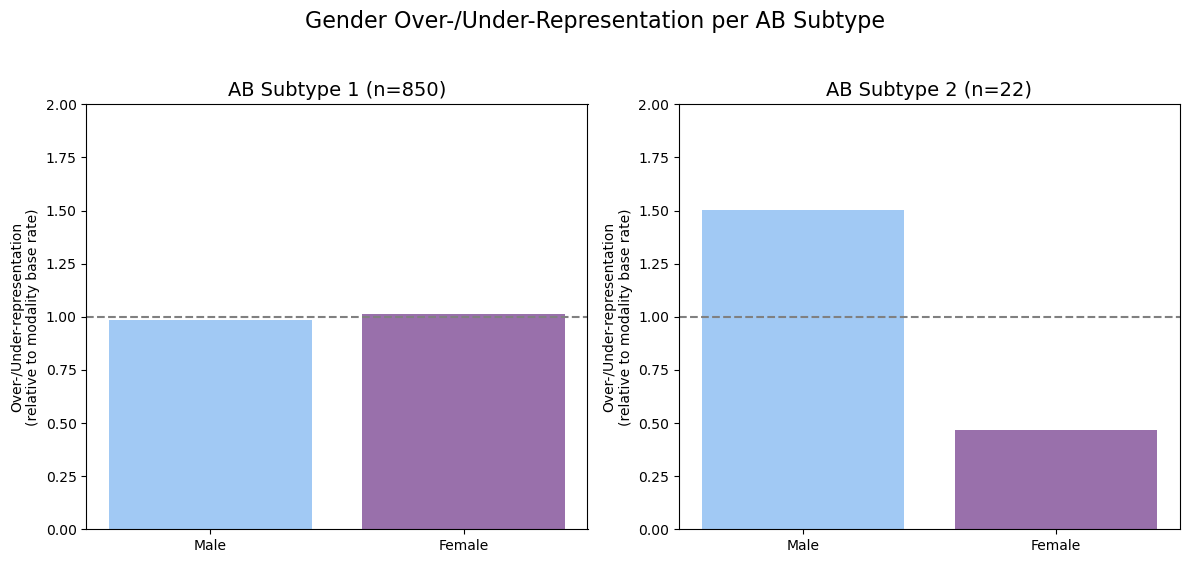


======= Gender Representation in TAU Subtypes (Proportional to Overall) =======


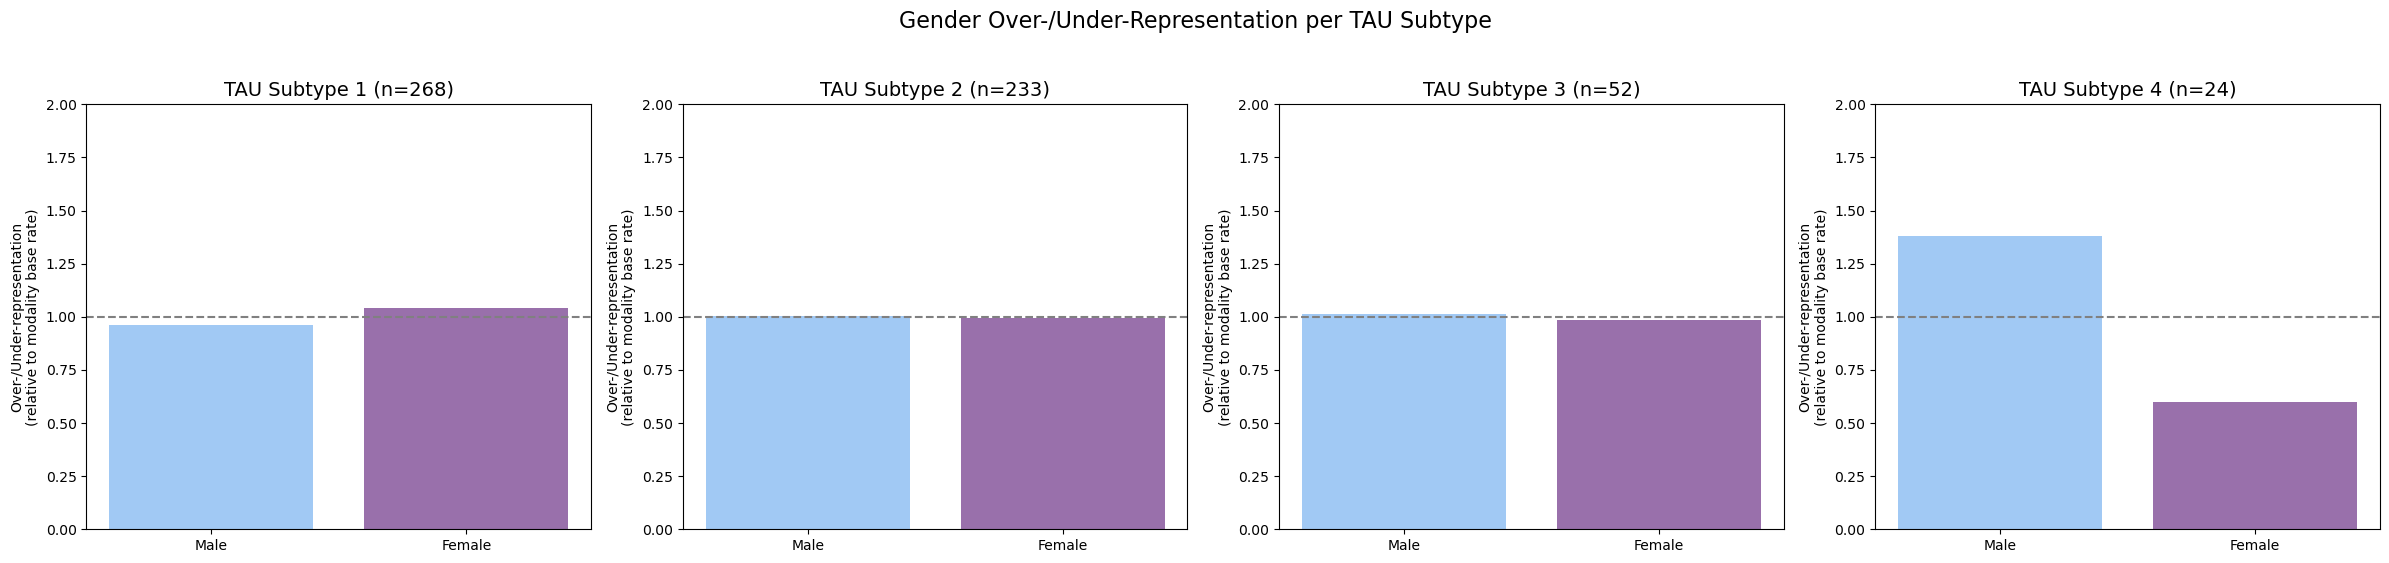


======= Gender Representation in MRI Subtypes (Proportional to Overall) =======


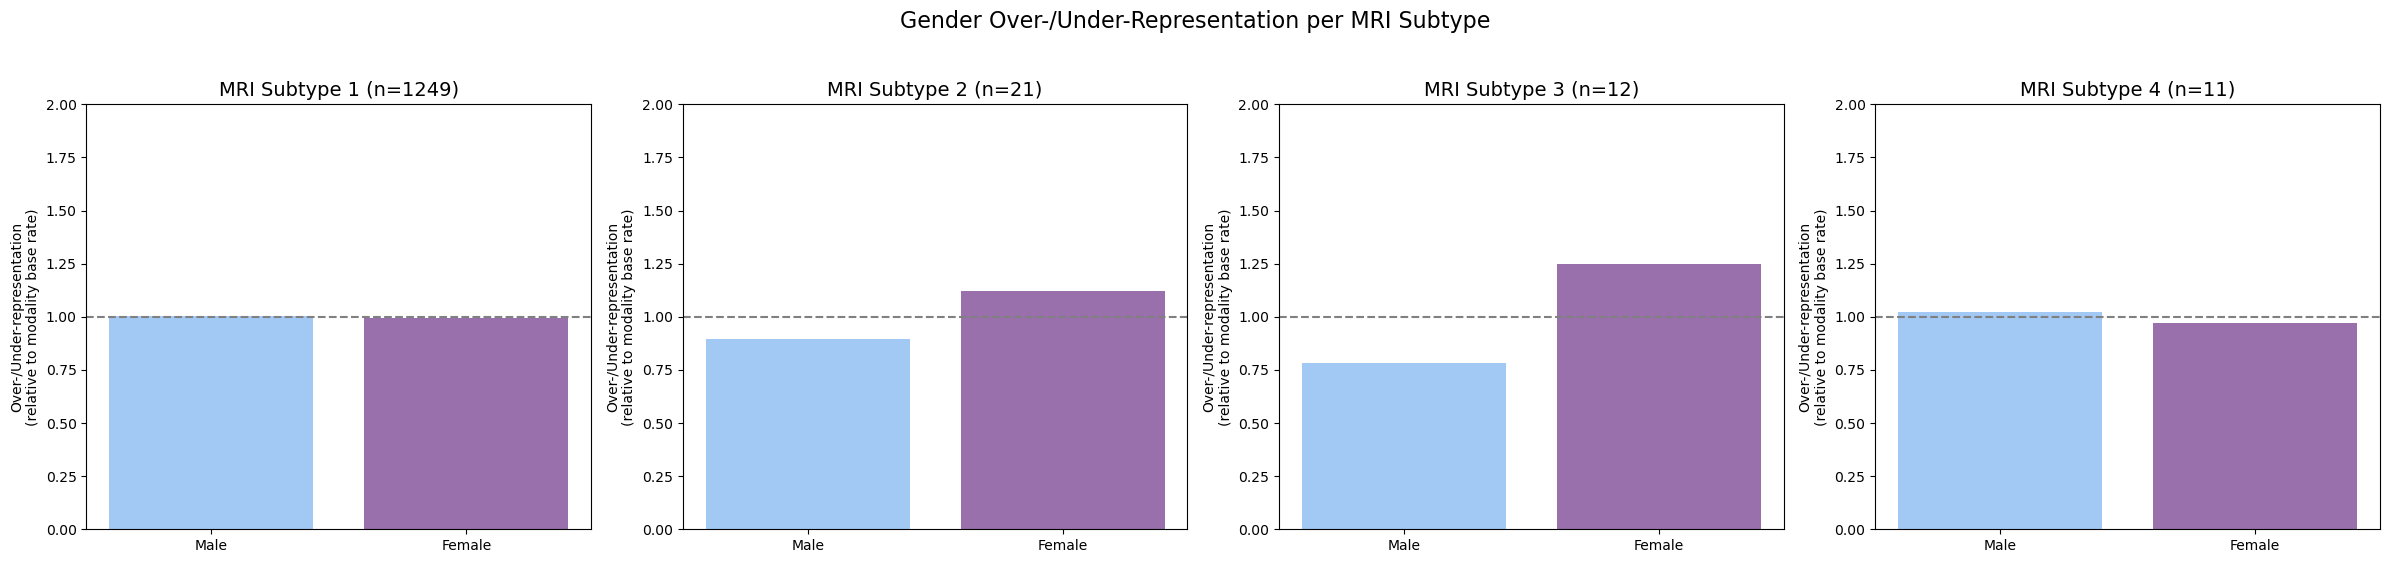

In [15]:
# Gender
# 1.0 = Male, 2.0 = Female
gender_map = {1.0: 'Male', 2.0: 'Female'}
gender_order = ['Male', 'Female']
gender_colors = ['#a1c9f4', '#9970AB']  

for modality, (subtype_col, df) in modalities.items():
    print(f"\n======= Gender Representation in {modality} Subtypes (Proportional to Overall) =======")
    
    df = df.copy()
    df['GenderStr'] = df[gender].map(gender_map)
    
    # Overall gender base rates in this modality
    overall_counts = df['GenderStr'].value_counts()
    overall_total = overall_counts.sum()
    overall_props = overall_counts / overall_total  # Base rate of Male/Female

    unique_subtypes = sorted(df[subtype_col].dropna().unique())
    n_subtypes = len(unique_subtypes)
    fig, axs = plt.subplots(1, n_subtypes, figsize=(6 * n_subtypes, 6))
    if n_subtypes == 1:
        axs = [axs]

    for i, subtype in enumerate(unique_subtypes):
        subset_df = df[df[subtype_col] == subtype]
        gender_counts = subset_df['GenderStr'].value_counts()
        total = gender_counts.sum()

        # Proportion relative to overall (normalized)
        normalized_props = (gender_counts / total) / overall_props
        normalized_props = normalized_props.reindex(gender_order).fillna(0)

        # Bar plot — with consistent color and order
        axs[i].bar(gender_order, normalized_props.values, color=gender_colors)
        axs[i].set_ylim(0, 2)
        axs[i].axhline(1.0, color='gray', linestyle='--')
        axs[i].set_title(f"{modality} Subtype {int(subtype)+1} (n={total})", fontsize=14)
        axs[i].set_ylabel("Over-/Under-representation\n(relative to modality base rate)")
    
    plt.suptitle(f"Gender Over-/Under-Representation per {modality} Subtype", fontsize=16)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()


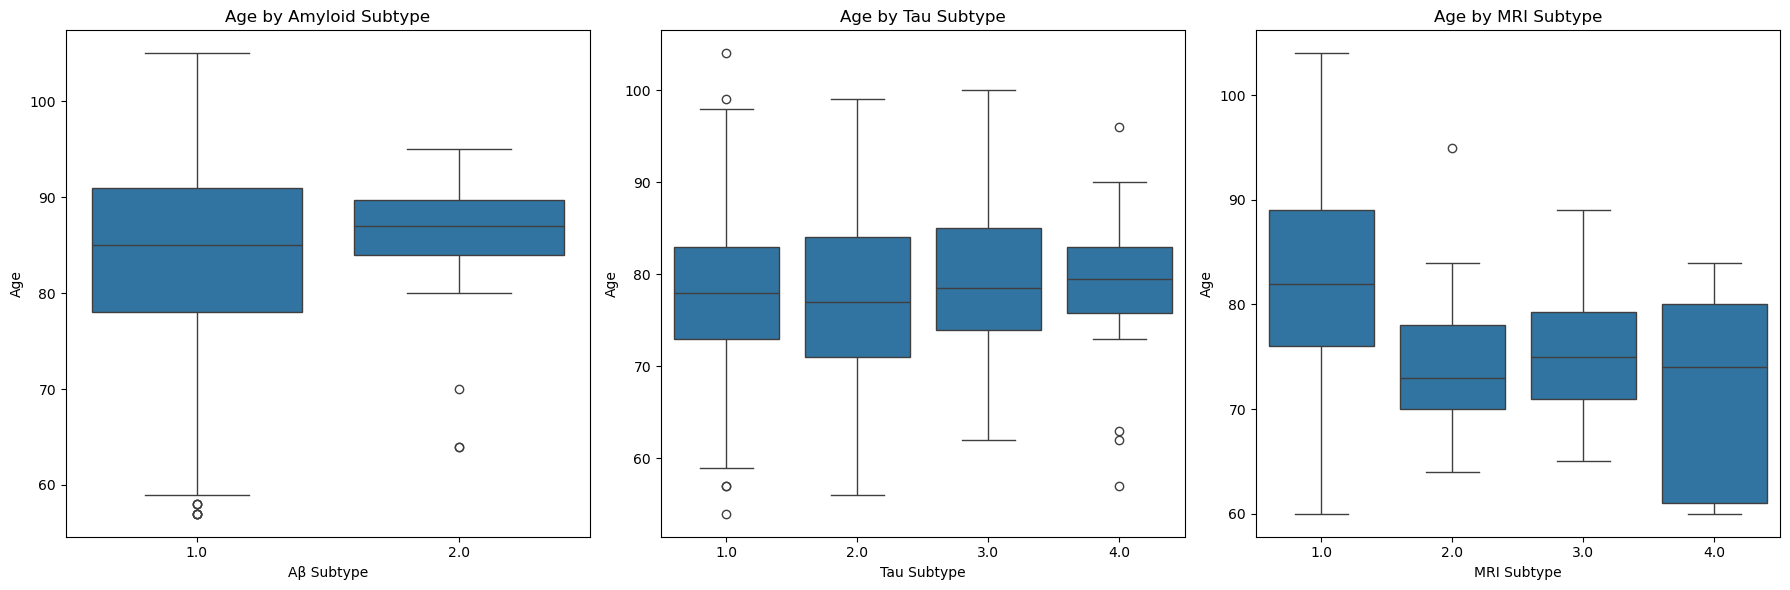


Aβ Subtype Age Summary:
                         n  median   mean   std   q25    q75
ml_subtype_AB_1based                                       
1.0                   850    85.0  84.42  9.41  78.0  91.00
2.0                    22    87.0  84.36  8.44  84.0  89.75

Tau Subtype Age Summary:
                          n  median   mean   std    q25   q75
ml_subtype_TAU_1based                                       
1.0                    268    78.0  77.88  8.38  73.00  83.0
2.0                    233    77.0  77.30  9.28  71.00  84.0
3.0                     52    78.5  79.38  7.44  74.00  85.0
4.0                     24    79.5  78.71  8.92  75.75  83.0

MRI Subtype Age Summary:
                           n  median   mean   std   q25    q75
ml_subtype_MRI_1based                                        
1.0                    1249    82.0  82.11  9.28  76.0  89.00
2.0                      21    73.0  74.33  7.13  70.0  78.00
3.0                      12    75.0  75.00  6.61  71.0  79.25
4.0 

In [16]:
# Filter: Age > 0 for all datasets
zdata_ab_clean = zdata_ab[zdata_ab[age] > 0].copy()
zdata_tau_clean = zdata_tau[zdata_tau[age] > 0].copy()
zdata_mri_clean = zdata_mri[zdata_mri[age] > 0].copy()
zdata_ab_clean['ml_subtype_AB_1based'] = zdata_ab_clean['ml_subtype_AB'] + 1
zdata_tau_clean['ml_subtype_TAU_1based'] = zdata_tau_clean['ml_subtype_TAU'] + 1
zdata_mri_clean['ml_subtype_MRI_1based'] = zdata_mri_clean['ml_subtype_MRI'] + 1


# Set up the figure
plt.figure(figsize=(18, 6))

# Aβ
plt.subplot(1, 3, 1)
sns.boxplot(data=zdata_ab_clean, x='ml_subtype_AB_1based', y=age)
plt.title('Age by Amyloid Subtype')
plt.xlabel('Aβ Subtype')
plt.ylabel('Age')

# Tau
plt.subplot(1, 3, 2)
sns.boxplot(data=zdata_tau_clean, x='ml_subtype_TAU_1based', y=age)
plt.title('Age by Tau Subtype')
plt.xlabel('Tau Subtype')
plt.ylabel('Age')

# MRI
plt.subplot(1, 3, 3)
sns.boxplot(data=zdata_mri_clean, x='ml_subtype_MRI_1based', y=age)
plt.title('Age by MRI Subtype')
plt.xlabel('MRI Subtype')
plt.ylabel('Age')

plt.tight_layout()
plt.show()

# Function to compute MMSE summary stats per subtype
def stats(df, subtype_col, var):
    return df.groupby(subtype_col)[var].agg(
        n='count',
        median='median',
        mean='mean',
        std='std',
        q25=lambda x: x.quantile(0.25),
        q75=lambda x: x.quantile(0.75)
    ).round(2)

# Create summary tables
age_ab_summary = stats(zdata_ab_clean.assign(ml_subtype_AB_1based=zdata_ab_clean['ml_subtype_AB'] + 1), 'ml_subtype_AB_1based', age)
age_tau_summary = stats(zdata_tau_clean.assign(ml_subtype_TAU_1based=zdata_tau_clean['ml_subtype_TAU'] + 1), 'ml_subtype_TAU_1based', age)
age_mri_summary = stats(zdata_mri_clean.assign(ml_subtype_MRI_1based=zdata_mri_clean['ml_subtype_MRI'] + 1), 'ml_subtype_MRI_1based', age)


# Print summaries
print("\nAβ Subtype Age Summary:\n", age_ab_summary)
print("\nTau Subtype Age Summary:\n", age_tau_summary)
print("\nMRI Subtype Age Summary:\n", age_mri_summary)


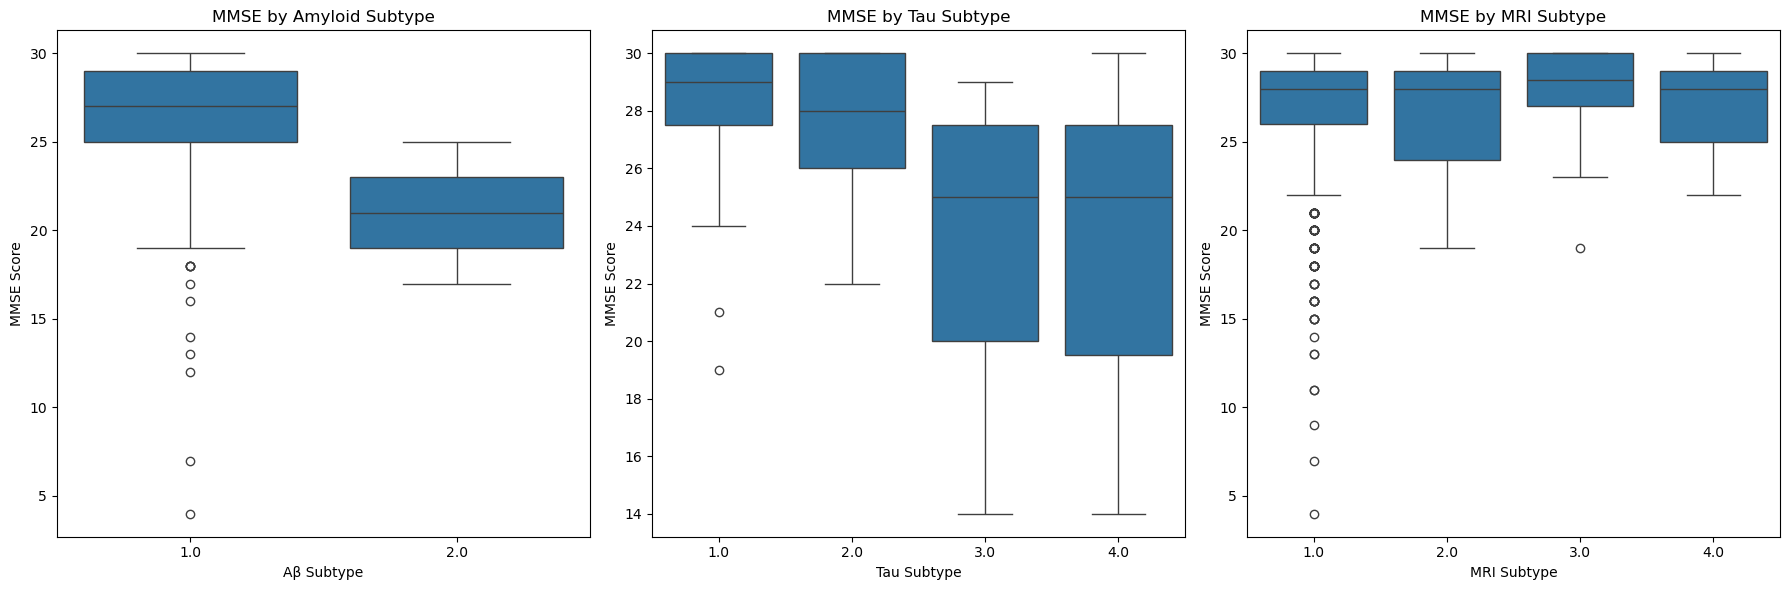


Aβ Subtype MMSE Summary:
                         n  median   mean   std   q25   q75
ml_subtype_AB_1based                                      
1.0                   165    27.0  26.13  4.36  25.0  29.0
2.0                     2    21.0  21.00  5.66  19.0  23.0

Tau Subtype MMSE Summary:
                         n  median   mean   std   q25   q75
ml_subtype_TAU_1based                                     
1.0                    35    29.0  28.34  2.53  27.5  30.0
2.0                    37    28.0  27.49  2.52  26.0  30.0
3.0                    11    25.0  23.55  4.89  20.0  27.5
4.0                     3    25.0  23.00  8.19  19.5  27.5

MRI Subtype MMSE Summary:
                           n  median   mean   std   q25   q75
ml_subtype_MRI_1based                                       
1.0                    1237    28.0  27.10  3.31  26.0  29.0
2.0                      21    28.0  26.43  3.65  24.0  29.0
3.0                      12    28.5  27.33  3.50  27.0  30.0
4.0                   

In [17]:
# Filter: MMSE > 0 for all datasets
zdata_ab_clean = zdata_ab[zdata_ab[mmse_score] > 0].copy()
zdata_tau_clean = zdata_tau[zdata_tau[mmse_score] > 0].copy()
zdata_mri_clean = zdata_mri[zdata_mri[mmse_score] > 0].copy()

zdata_ab_clean['ml_subtype_AB_1based'] = zdata_ab_clean['ml_subtype_AB'] + 1
zdata_tau_clean['ml_subtype_TAU_1based'] = zdata_tau_clean['ml_subtype_TAU'] + 1
zdata_mri_clean['ml_subtype_MRI_1based'] = zdata_mri_clean['ml_subtype_MRI'] + 1


# Set up the figure
plt.figure(figsize=(18, 6))

# Aβ
plt.subplot(1, 3, 1)
sns.boxplot(data=zdata_ab_clean, x='ml_subtype_AB_1based', y=mmse_score)
plt.title('MMSE by Amyloid Subtype')
plt.xlabel('Aβ Subtype')
plt.ylabel('MMSE Score')

# Tau
plt.subplot(1, 3, 2)
sns.boxplot(data=zdata_tau_clean, x='ml_subtype_TAU_1based', y=mmse_score)
plt.title('MMSE by Tau Subtype')
plt.xlabel('Tau Subtype')
plt.ylabel('MMSE Score')

# MRI
plt.subplot(1, 3, 3)
sns.boxplot(data=zdata_mri_clean, x='ml_subtype_MRI_1based', y=mmse_score)
plt.title('MMSE by MRI Subtype')
plt.xlabel('MRI Subtype')
plt.ylabel('MMSE Score')

plt.tight_layout()
plt.show()

# Create summary tables
mmse_ab_summary = stats(zdata_ab_clean.assign(ml_subtype_AB_1based=zdata_ab_clean['ml_subtype_AB'] + 1), 'ml_subtype_AB_1based', mmse_score)
mmse_tau_summary = stats(zdata_tau_clean.assign(ml_subtype_TAU_1based=zdata_tau_clean['ml_subtype_TAU'] + 1), 'ml_subtype_TAU_1based', mmse_score)
mmse_mri_summary = stats(zdata_mri_clean.assign(ml_subtype_MRI_1based=zdata_mri_clean['ml_subtype_MRI'] + 1), 'ml_subtype_MRI_1based', mmse_score)



# Print summaries
print("\nAβ Subtype MMSE Summary:\n", mmse_ab_summary)
print("\nTau Subtype MMSE Summary:\n", mmse_tau_summary)
print("\nMRI Subtype MMSE Summary:\n", mmse_mri_summary)


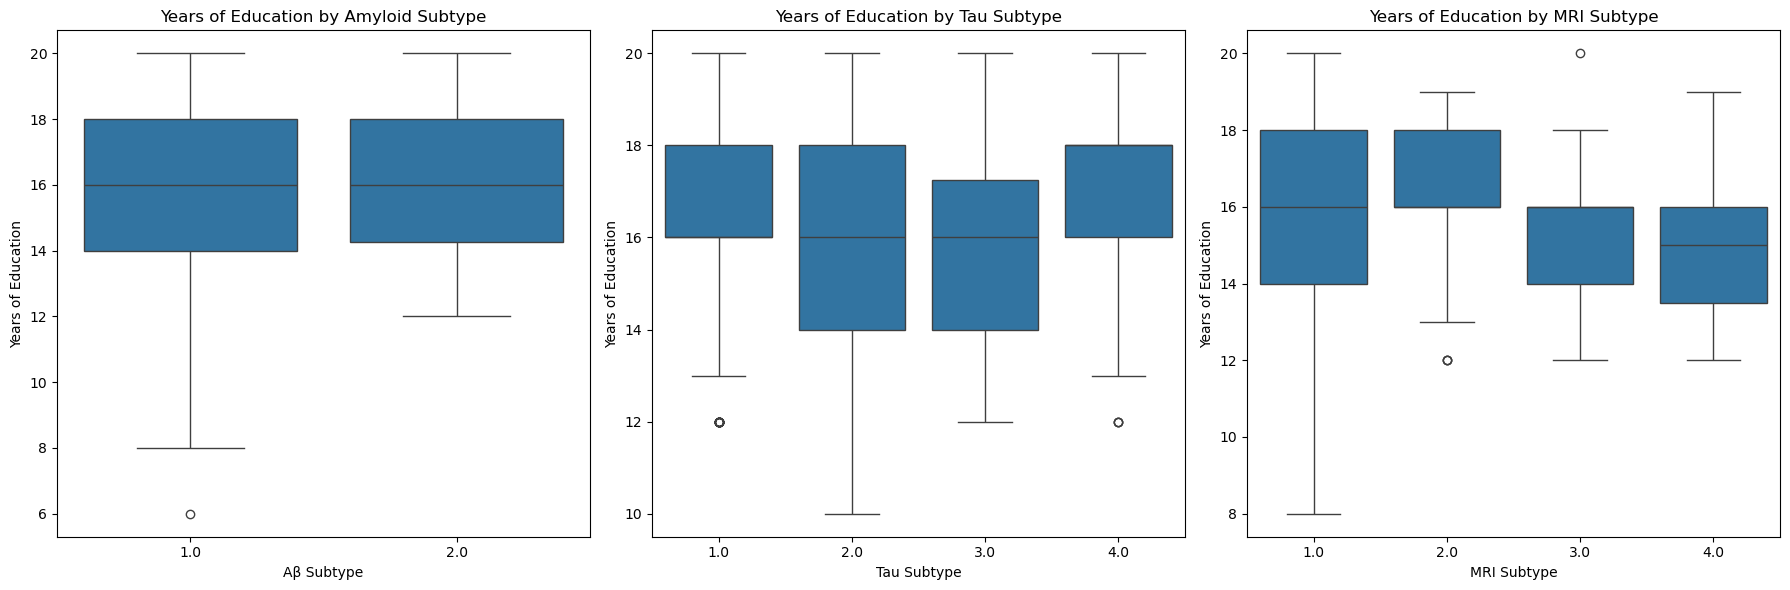


Aβ Subtype Years of Education Summary:
                         n  median   mean   std    q25   q75
ml_subtype_AB_1based                                       
1.0                   850    16.0  16.11  2.65  14.00  18.0
2.0                    22    16.0  16.18  2.77  14.25  18.0

Tau Subtype Years of Education Summary:
                          n  median   mean   std   q25    q75
ml_subtype_TAU_1based                                       
1.0                    268    16.0  16.73  2.37  16.0  18.00
2.0                    233    16.0  16.21  2.37  14.0  18.00
3.0                     52    16.0  15.42  2.39  14.0  17.25
4.0                     24    18.0  16.71  2.44  16.0  18.00

MRI Subtype Years of Education Summary:
                           n  median   mean   std   q25   q75
ml_subtype_MRI_1based                                       
1.0                    1249    16.0  16.30  2.52  14.0  18.0
2.0                      21    16.0  16.05  2.22  16.0  18.0
3.0                      

In [18]:
# Filter: age at education  > 0 for all datasets
zdata_ab_clean = zdata_ab[zdata_ab[educ] > 0].copy()
zdata_tau_clean = zdata_tau[zdata_tau[educ] > 0].copy()
zdata_mri_clean = zdata_mri[zdata_mri[educ] > 0].copy()
zdata_ab_clean['ml_subtype_AB_1based'] = zdata_ab_clean['ml_subtype_AB'] + 1
zdata_tau_clean['ml_subtype_TAU_1based'] = zdata_tau_clean['ml_subtype_TAU'] + 1
zdata_mri_clean['ml_subtype_MRI_1based'] = zdata_mri_clean['ml_subtype_MRI'] + 1

# Set up the figure
plt.figure(figsize=(18, 6))

# Aβ
plt.subplot(1, 3, 1)
sns.boxplot(data=zdata_ab_clean, x='ml_subtype_AB_1based', y=educ)
plt.title('Years of Education by Amyloid Subtype')
plt.xlabel('Aβ Subtype')
plt.ylabel('Years of Education')

# Tau
plt.subplot(1, 3, 2)
sns.boxplot(data=zdata_tau_clean, x='ml_subtype_TAU_1based', y=educ)
plt.title('Years of Education by Tau Subtype')
plt.xlabel('Tau Subtype')
plt.ylabel('Years of Education')

# MRI
plt.subplot(1, 3, 3)
sns.boxplot(data=zdata_mri_clean, x='ml_subtype_MRI_1based', y=educ)
plt.title('Years of Education by MRI Subtype')
plt.xlabel('MRI Subtype')
plt.ylabel('Years of Education')

plt.tight_layout()
plt.show()

# Create summary tables
educ_ab_summary = stats(zdata_ab_clean.assign(ml_subtype_AB_1based=zdata_ab_clean['ml_subtype_AB'] + 1), 'ml_subtype_AB_1based', educ)
educ_tau_summary = stats(zdata_tau_clean.assign(ml_subtype_TAU_1based=zdata_tau_clean['ml_subtype_TAU'] + 1), 'ml_subtype_TAU_1based', educ)
educ_mri_summary = stats(zdata_mri_clean.assign(ml_subtype_MRI_1based=zdata_mri_clean['ml_subtype_MRI'] + 1), 'ml_subtype_MRI_1based', educ)


# Print summaries
print("\nAβ Subtype Years of Education Summary:\n", educ_ab_summary)
print("\nTau Subtype Years of Education Summary:\n", educ_tau_summary)
print("\nMRI Subtype Years of Education Summary:\n", educ_mri_summary)


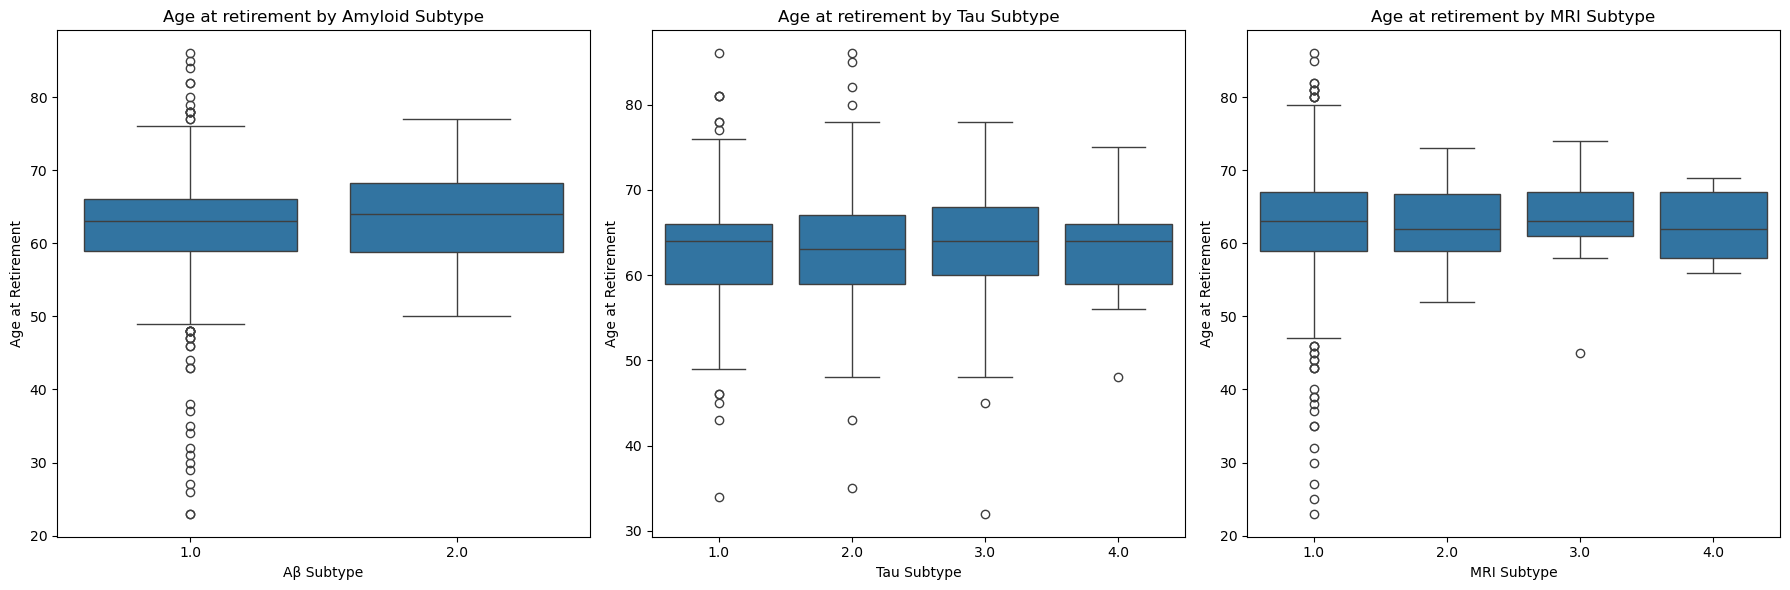


Aβ Subtype Age at Retirement Summary:
                         n  median   mean   std    q25    q75
ml_subtype_AB_1based                                        
1.0                   674    63.0  62.43  7.73  59.00  66.00
2.0                    20    64.0  62.95  7.80  58.75  68.25

Tau Subtype Age at Retirement Summary:
                          n  median   mean   std   q25   q75
ml_subtype_TAU_1based                                      
1.0                    199    64.0  63.11  7.27  59.0  66.0
2.0                    178    63.0  63.13  7.43  59.0  67.0
3.0                     47    64.0  63.19  7.57  60.0  68.0
4.0                     19    64.0  62.63  5.75  59.0  66.0

MRI Subtype Age at Retirement Summary:
                          n  median   mean   std   q25    q75
ml_subtype_MRI_1based                                       
1.0                    970    63.0  62.71  7.55  59.0  67.00
2.0                     18    62.0  62.28  5.32  59.0  66.75
3.0                      9    

In [19]:
# Filter: age at retirement > 0 for all datasets
zdata_ab_clean = zdata_ab[zdata_ab[retire_age] > 0].copy()
zdata_tau_clean = zdata_tau[zdata_tau[retire_age] > 0].copy()
zdata_mri_clean = zdata_mri[zdata_mri[retire_age] > 0].copy()
zdata_ab_clean['ml_subtype_AB_1based'] = zdata_ab_clean['ml_subtype_AB'] + 1
zdata_tau_clean['ml_subtype_TAU_1based'] = zdata_tau_clean['ml_subtype_TAU'] + 1
zdata_mri_clean['ml_subtype_MRI_1based'] = zdata_mri_clean['ml_subtype_MRI'] + 1

# Set up the figure
plt.figure(figsize=(18, 6))

# Aβ
plt.subplot(1, 3, 1)
sns.boxplot(data=zdata_ab_clean, x='ml_subtype_AB_1based', y=retire_age)
plt.title('Age at retirement by Amyloid Subtype')
plt.xlabel('Aβ Subtype')
plt.ylabel('Age at Retirement')

# Tau
plt.subplot(1, 3, 2)
sns.boxplot(data=zdata_tau_clean, x='ml_subtype_TAU_1based', y=retire_age)
plt.title('Age at retirement by Tau Subtype')
plt.xlabel('Tau Subtype')
plt.ylabel('Age at Retirement')

# MRI
plt.subplot(1, 3, 3)
sns.boxplot(data=zdata_mri_clean, x='ml_subtype_MRI_1based', y=retire_age)
plt.title('Age at retirement by MRI Subtype')
plt.xlabel('MRI Subtype')
plt.ylabel('Age at Retirement')

plt.tight_layout()
plt.show()

# Create summary tables
retire_age_ab_summary = stats(zdata_ab_clean.assign(ml_subtype_AB_1based=zdata_ab_clean['ml_subtype_AB'] + 1), 'ml_subtype_AB_1based', retire_age)
retire_age_tau_summary = stats(zdata_tau_clean.assign(ml_subtype_TAU_1based=zdata_tau_clean['ml_subtype_TAU'] + 1), 'ml_subtype_TAU_1based', retire_age)
retire_age_mri_summary = stats(zdata_mri_clean.assign(ml_subtype_MRI_1based=zdata_mri_clean['ml_subtype_MRI'] + 1), 'ml_subtype_MRI_1based', retire_age)

# Print summaries
print("\nAβ Subtype Age at Retirement Summary:\n", retire_age_ab_summary)
print("\nTau Subtype Age at Retirement Summary:\n", retire_age_tau_summary)
print("\nMRI Subtype Age at Retirement Summary:\n", retire_age_mri_summary)


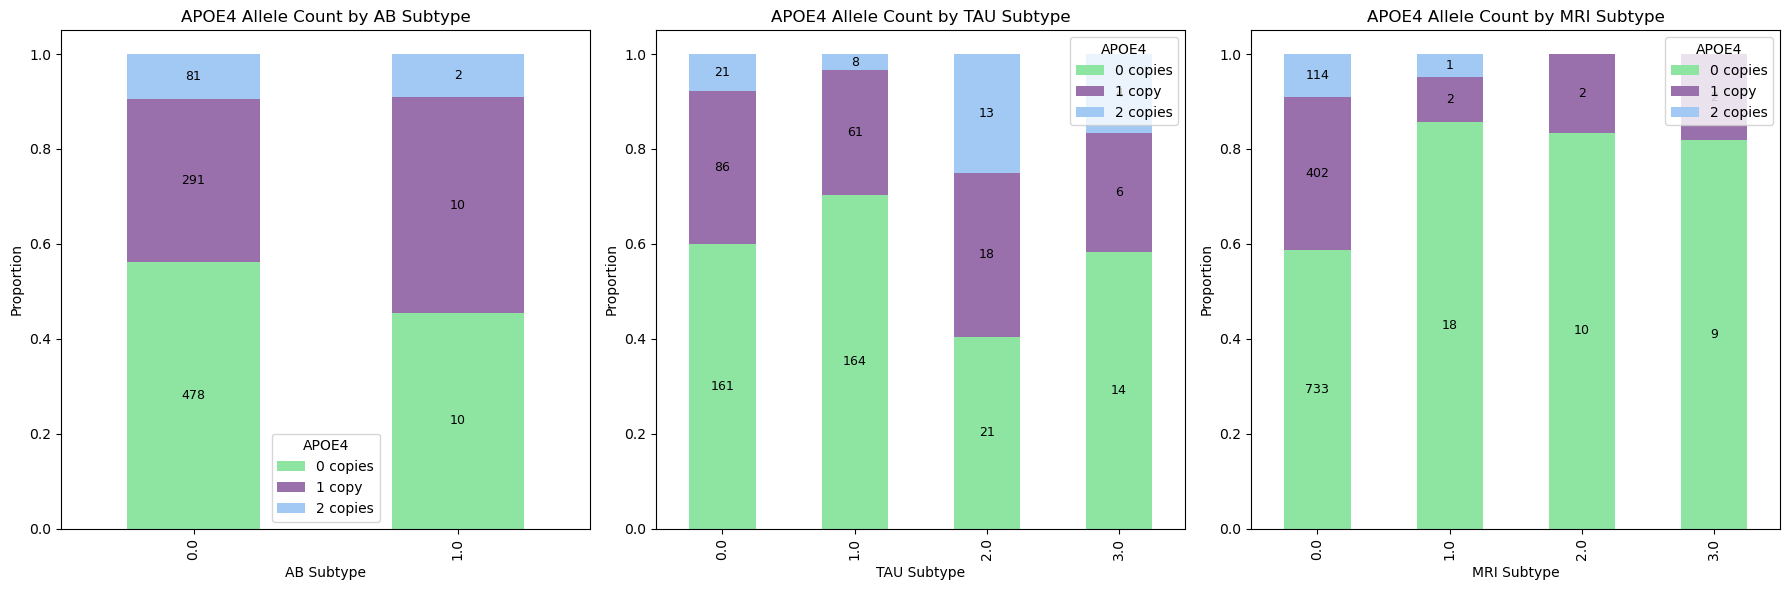


======= APOE4 Representation in AB Subtypes (Proportional to Overall) =======


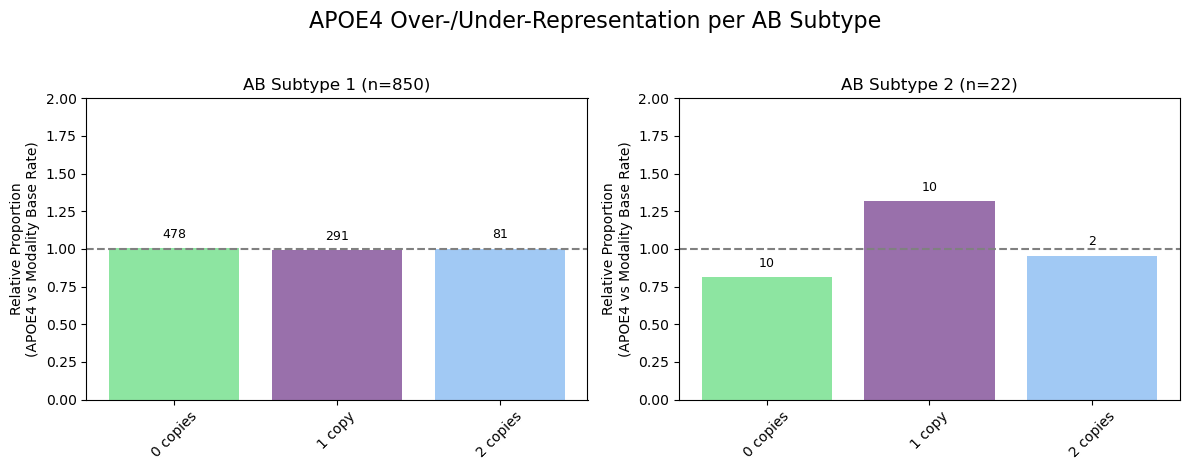


======= APOE4 Representation in TAU Subtypes (Proportional to Overall) =======


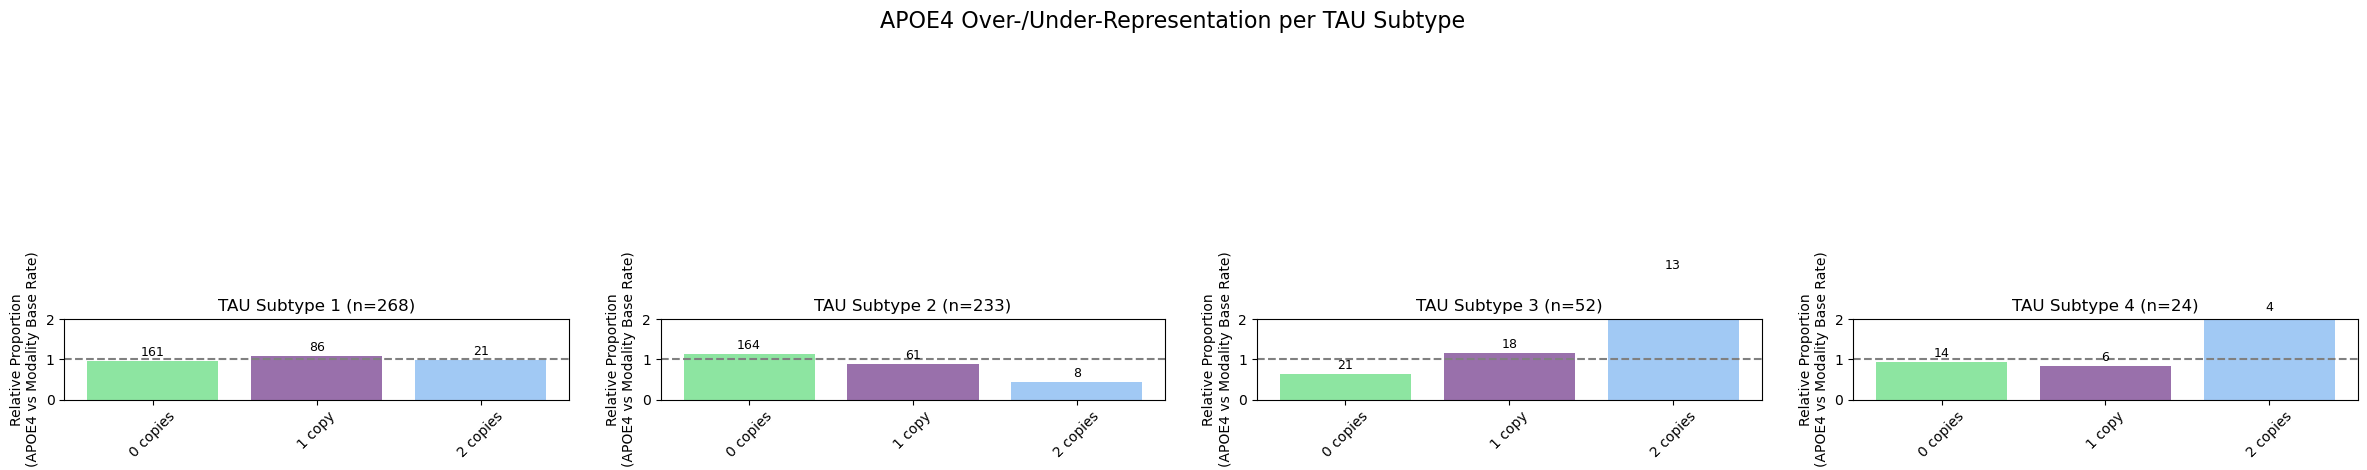


======= APOE4 Representation in MRI Subtypes (Proportional to Overall) =======


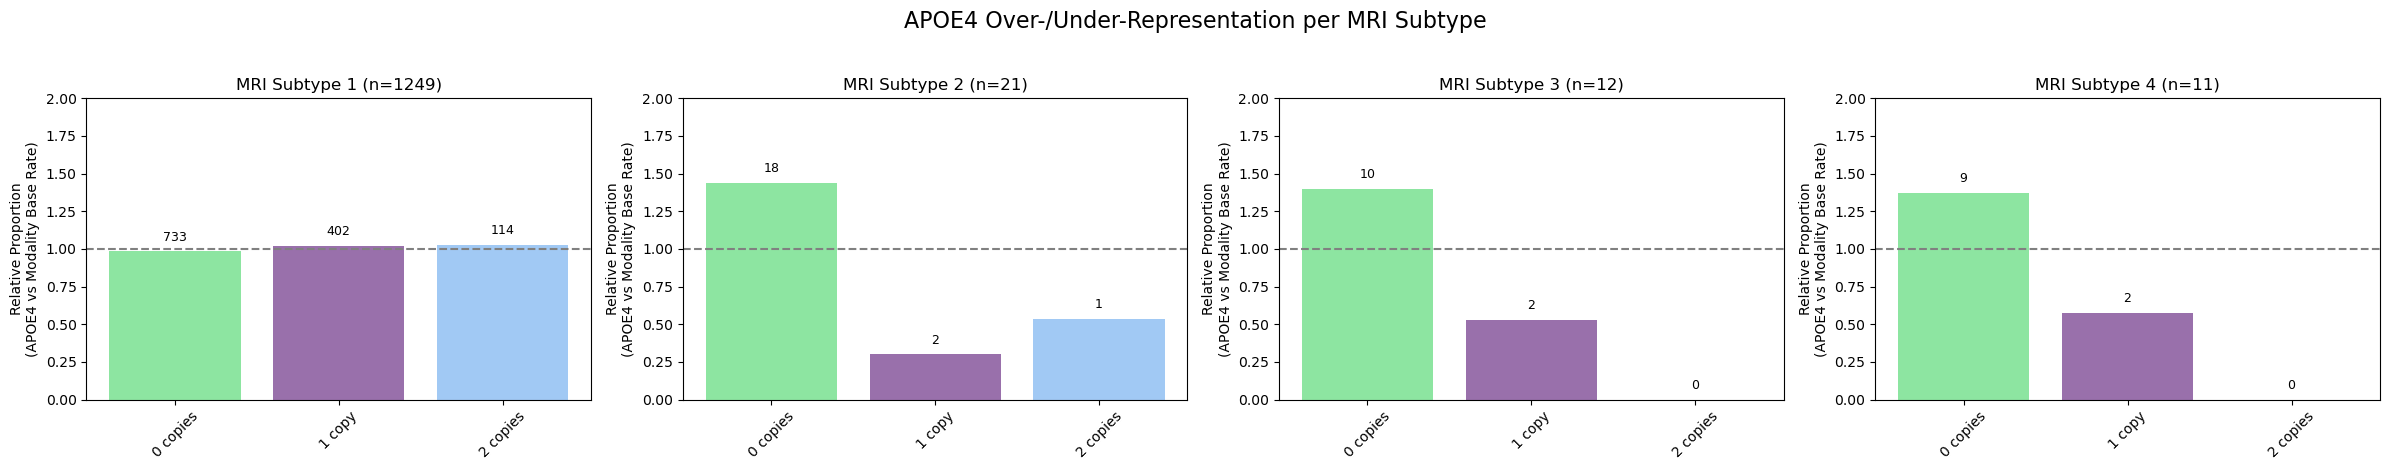


Aβ Subtype APOE4 Summary:
                0.0_count  1.0_count  2.0_count  0.0_prop  1.0_prop  2.0_prop
ml_subtype_AB                                                               
0.0                  478        291         81     0.562     0.342     0.095
1.0                   10         10          2     0.455     0.455     0.091

Tau Subtype APOE4 Summary:
                 0.0_count  1.0_count  2.0_count  0.0_prop  1.0_prop  2.0_prop
ml_subtype_TAU                                                               
0.0                   161         86         21     0.601     0.321     0.078
1.0                   164         61          8     0.704     0.262     0.034
2.0                    21         18         13     0.404     0.346     0.250
3.0                    14          6          4     0.583     0.250     0.167

MRI Subtype APOE4 Summary:
                 0.0_count  1.0_count  2.0_count  0.0_prop  1.0_prop  2.0_prop
ml_subtype_MRI                                              

In [20]:
#APOE4
# Define colors and labels for APOE4 allele count
colors = ['#8de5a1', '#9970AB', '#a1c9f4']  
labels = ['0 copies', '1 copy', '2 copies']


# Plot stacked bar plots with counts on top
plt.figure(figsize=(18, 6))
for i, (modality, (subtype_col, df)) in enumerate(modalities.items(), start=1):
    plt.subplot(1, 3, i)

    # Get proportions and counts
    apoe_counts_prop = df.groupby(subtype_col)[apoe4].value_counts(normalize=True).unstack().fillna(0)
    apoe_counts_prop = apoe_counts_prop.reindex(columns=[0,1,2], fill_value=0)

    apoe_counts_abs = df.groupby(subtype_col)[apoe4].value_counts().unstack().fillna(0)
    apoe_counts_abs = apoe_counts_abs.reindex(columns=[0,1,2], fill_value=0)

    # Plot stacked bar of proportions
    ax = apoe_counts_prop.plot(kind='bar', stacked=True, color=colors, ax=plt.gca())
    plt.title(f'APOE4 Allele Count by {modality} Subtype')
    plt.xlabel(f'{modality} Subtype')
    plt.ylabel('Proportion')
    plt.legend(title='APOE4', labels=labels)

    # Add counts on each bar segment
    for subtype_idx, subtype in enumerate(apoe_counts_prop.index):
        bottom = 0
        for allele_idx, allele in enumerate([0,1,2]):
            height = apoe_counts_prop.loc[subtype, allele]
            count = int(apoe_counts_abs.loc[subtype, allele])
            if height > 0:
                ax.text(subtype_idx, bottom + height/2, str(count), ha='center', va='center', fontsize=9, color='black')
            bottom += height

plt.tight_layout()
plt.show()

# Relative over-/under-representation plots with counts on bars
for modality, (subtype_col, df) in modalities.items():
    print(f"\n======= APOE4 Representation in {modality} Subtypes (Proportional to Overall) =======")

    base_rate = df[apoe4].value_counts(normalize=True)
    base_rate = base_rate.reindex([0,1,2], fill_value=0)

    unique_subtypes = sorted(df[subtype_col].dropna().unique())
    fig, axs = plt.subplots(1, len(unique_subtypes), figsize=(6 * len(unique_subtypes), 5))
    if len(unique_subtypes) == 1:
        axs = [axs]

    for i, subtype in enumerate(unique_subtypes):
        sub_df = df[df[subtype_col] == subtype]
        counts_prop = sub_df[apoe4].value_counts(normalize=True).reindex([0,1,2], fill_value=0)
        counts_abs = sub_df[apoe4].value_counts().reindex([0,1,2], fill_value=0)

        # Normalize relative to base rate
        norm_counts = (counts_prop / base_rate).fillna(0)

        axs[i].bar(labels, norm_counts.values, color=colors)
        axs[i].axhline(1, linestyle='--', color='gray')
        axs[i].set_ylim(0, 2)
        axs[i].set_title(f"{modality} Subtype {int(subtype)+1} (n={len(sub_df)})")
        axs[i].set_ylabel('Relative Proportion\n(APOE4 vs Modality Base Rate)')
        axs[i].tick_params(axis='x', rotation=45)

        # Add count labels above bars
        for x_pos, count in enumerate(counts_abs.values):
            axs[i].text(x_pos, norm_counts.values[x_pos] + 0.05, str(int(count)), ha='center', va='bottom', fontsize=9)

    plt.suptitle(f"APOE4 Over-/Under-Representation per {modality} Subtype", fontsize=16)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

def apoe4_proportion_summary(df, subtype_col, apoe_col='APOE4'):
    counts = df.groupby([subtype_col, apoe_col]).size().unstack(fill_value=0)
    proportions = counts.div(counts.sum(axis=1), axis=0).round(3)
    counts.columns = [f"{col}_count" for col in counts.columns]
    proportions.columns = [f"{col}_prop" for col in proportions.columns]
    return pd.concat([counts, proportions], axis=1)

# APOE4 summary for Aβ
apoe4_ab_summary = apoe4_proportion_summary(zdata_ab, 'ml_subtype_AB')
print("\nAβ Subtype APOE4 Summary:\n", apoe4_ab_summary)

# APOE4 summary for Tau
apoe4_tau_summary = apoe4_proportion_summary(zdata_tau, 'ml_subtype_TAU')
print("\nTau Subtype APOE4 Summary:\n", apoe4_tau_summary)

# APOE4 summary for MRI
apoe4_mri_summary = apoe4_proportion_summary(zdata_mri, 'ml_subtype_MRI')
print("\nMRI Subtype APOE4 Summary:\n", apoe4_mri_summary)



====== Asymmetry Across Stages in AB ======
Frontal_lobe_Asymmetry_ab_L | Subtype 0.0 | Slope = 0.000, r = 0.02, p = 0.9302
Frontal_lobe_Asymmetry_ab_L | Subtype 1.0 | Slope = 0.001, r = 0.15, p = 0.7168


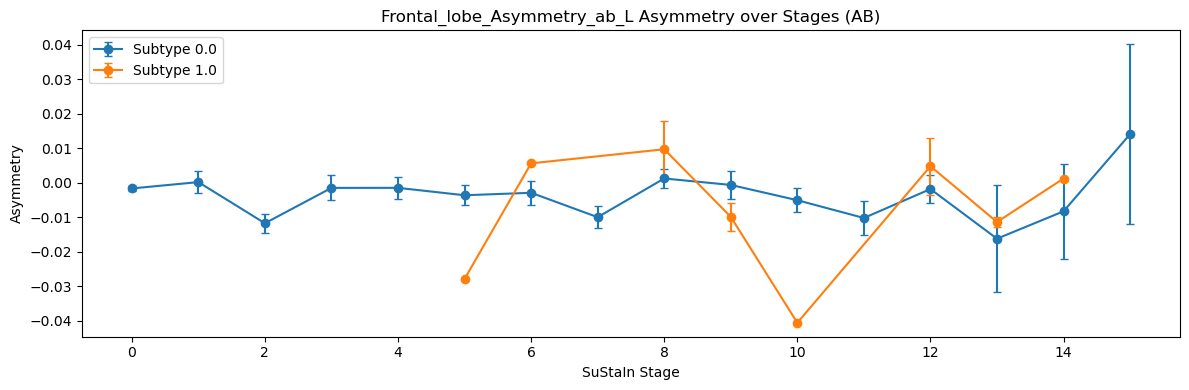

Frontal_lobe_Asymmetry_ab_R | Subtype 0.0 | Slope = -0.000, r = -0.02, p = 0.9302
Frontal_lobe_Asymmetry_ab_R | Subtype 1.0 | Slope = -0.001, r = -0.15, p = 0.7168


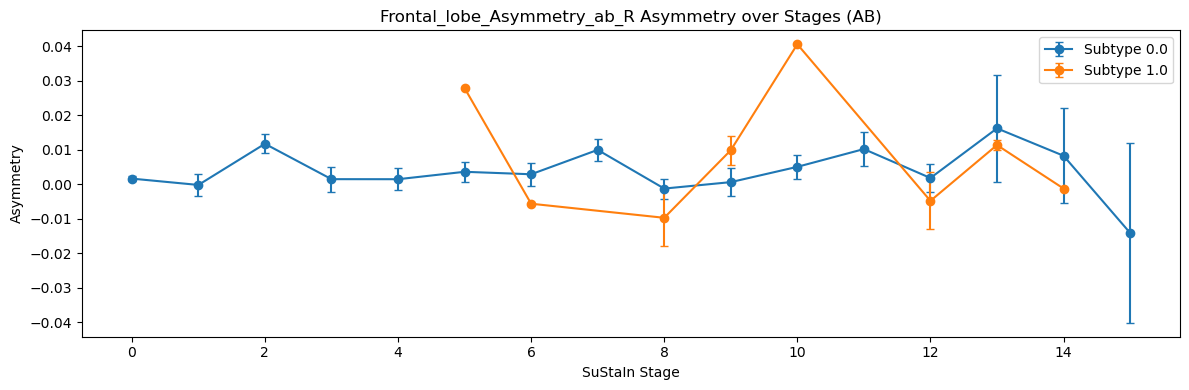

Occipital_lobe_Asymmetry_ab_L | Subtype 0.0 | Slope = -0.000, r = -0.29, p = 0.2694
Occipital_lobe_Asymmetry_ab_L | Subtype 1.0 | Slope = -0.000, r = -0.02, p = 0.9595


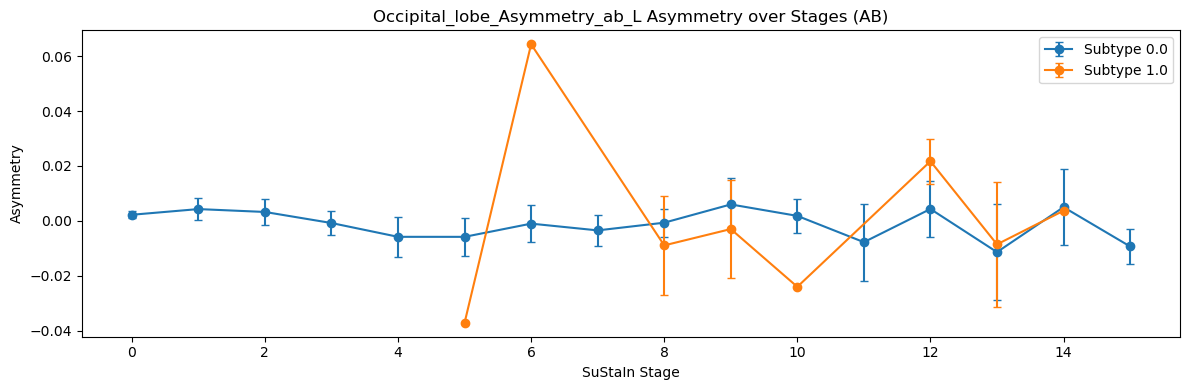

Occipital_lobe_Asymmetry_ab_R | Subtype 0.0 | Slope = 0.000, r = 0.29, p = 0.2694
Occipital_lobe_Asymmetry_ab_R | Subtype 1.0 | Slope = 0.000, r = 0.02, p = 0.9595


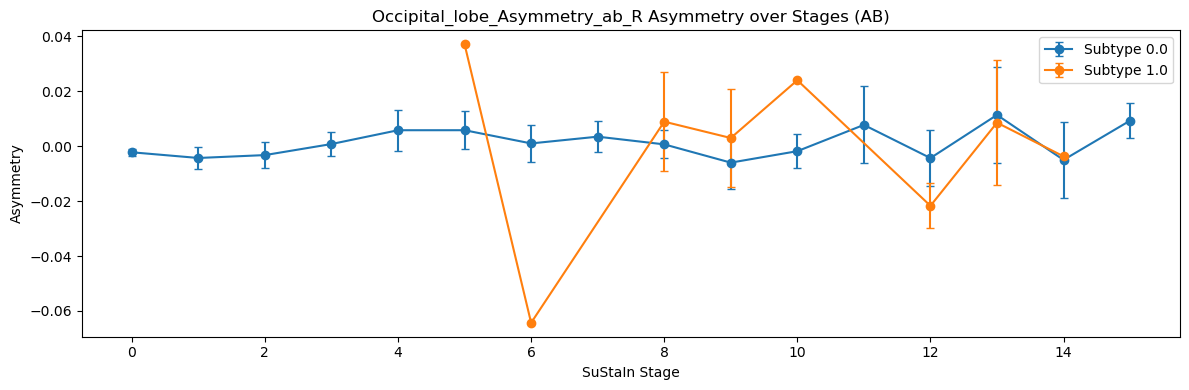

Parietal_lobe_Asymmetry_ab_L | Subtype 0.0 | Slope = 0.001, r = 0.33, p = 0.2109
Parietal_lobe_Asymmetry_ab_L | Subtype 1.0 | Slope = -0.001, r = -0.15, p = 0.7299


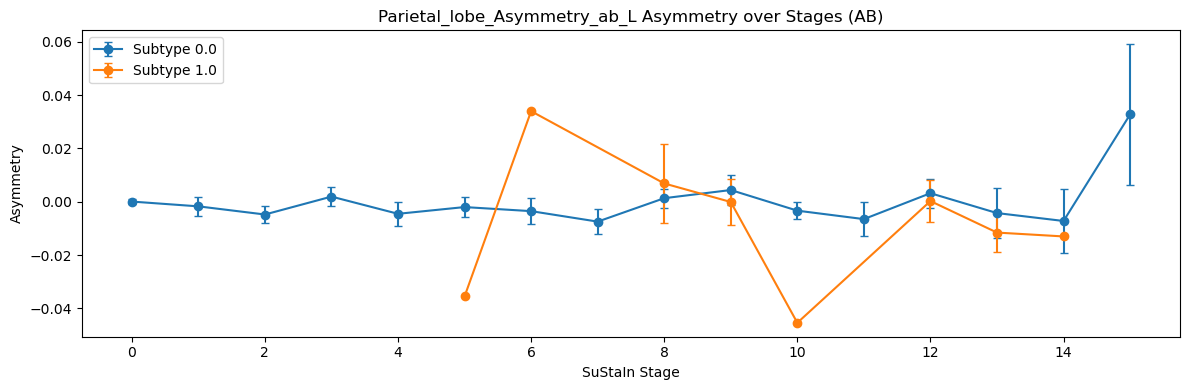

Parietal_lobe_Asymmetry_ab_R | Subtype 0.0 | Slope = -0.001, r = -0.33, p = 0.2109
Parietal_lobe_Asymmetry_ab_R | Subtype 1.0 | Slope = 0.001, r = 0.15, p = 0.7299


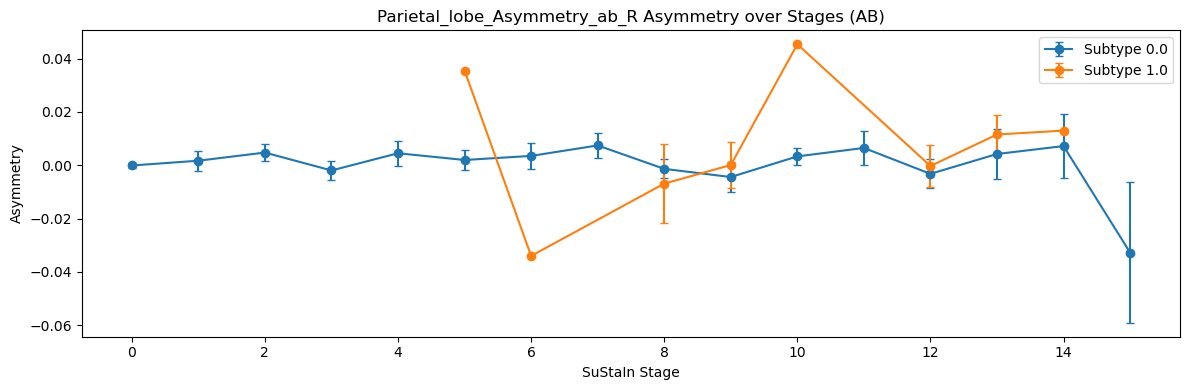

Temporal_lobe_Asymmetry_ab_L | Subtype 0.0 | Slope = 0.001, r = 0.29, p = 0.2769
Temporal_lobe_Asymmetry_ab_L | Subtype 1.0 | Slope = -0.001, r = -0.09, p = 0.8247


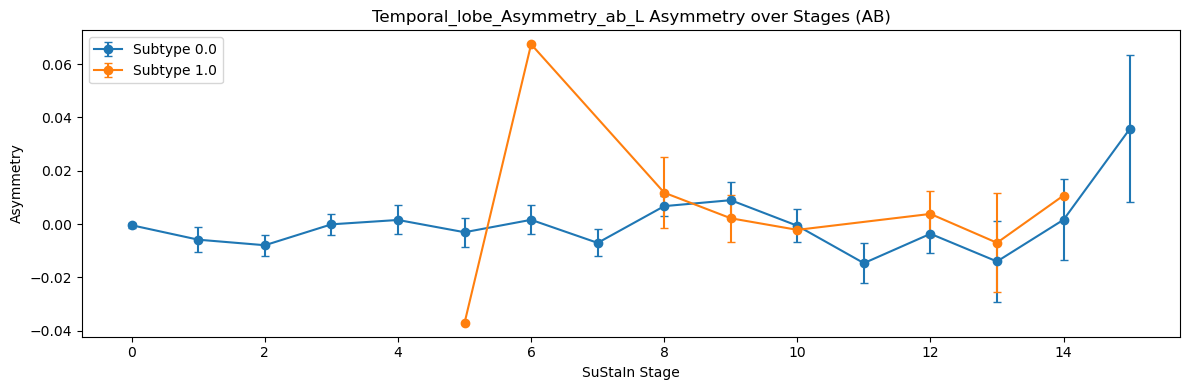

Temporal_lobe_Asymmetry_ab_R | Subtype 0.0 | Slope = -0.001, r = -0.29, p = 0.2769
Temporal_lobe_Asymmetry_ab_R | Subtype 1.0 | Slope = 0.001, r = 0.09, p = 0.8247


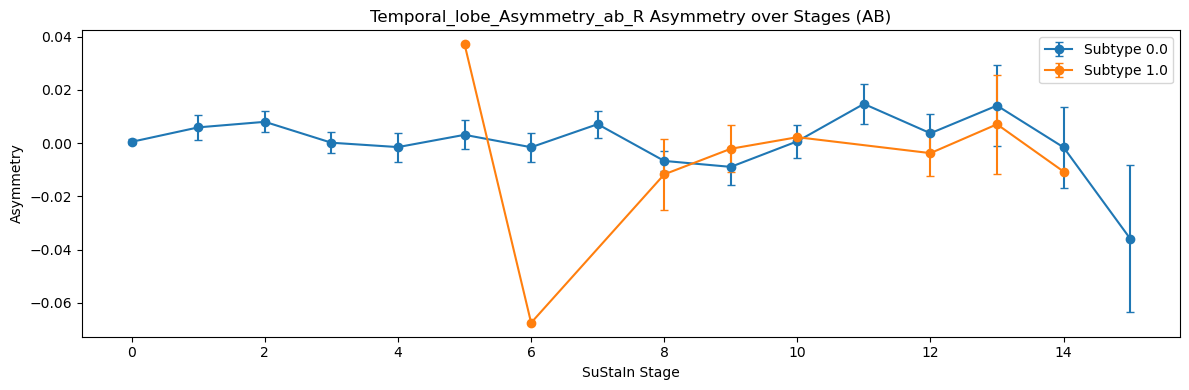

MTL_Asymmetry_ab_L | Subtype 0.0 | Slope = 0.000, r = 0.18, p = 0.5020
MTL_Asymmetry_ab_L | Subtype 1.0 | Slope = -0.001, r = -0.20, p = 0.6329


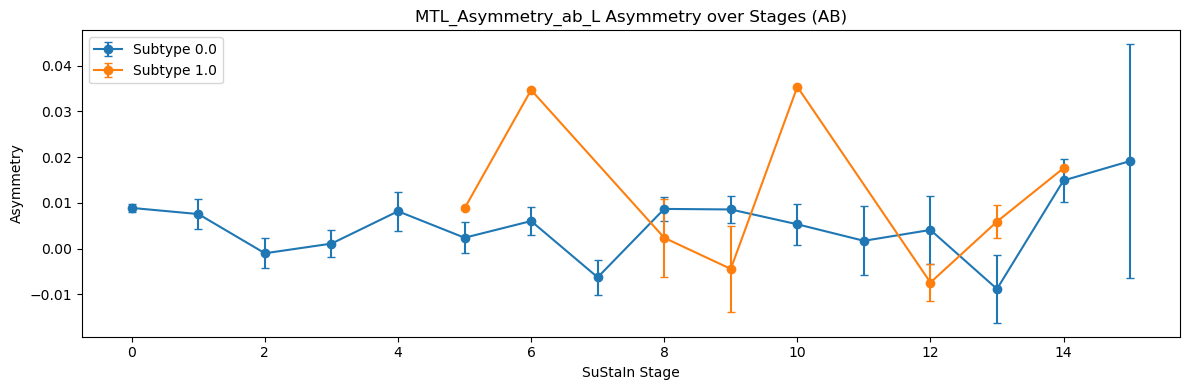

MTL_Asymmetry_ab_R | Subtype 0.0 | Slope = -0.000, r = -0.18, p = 0.5020
MTL_Asymmetry_ab_R | Subtype 1.0 | Slope = 0.001, r = 0.20, p = 0.6329


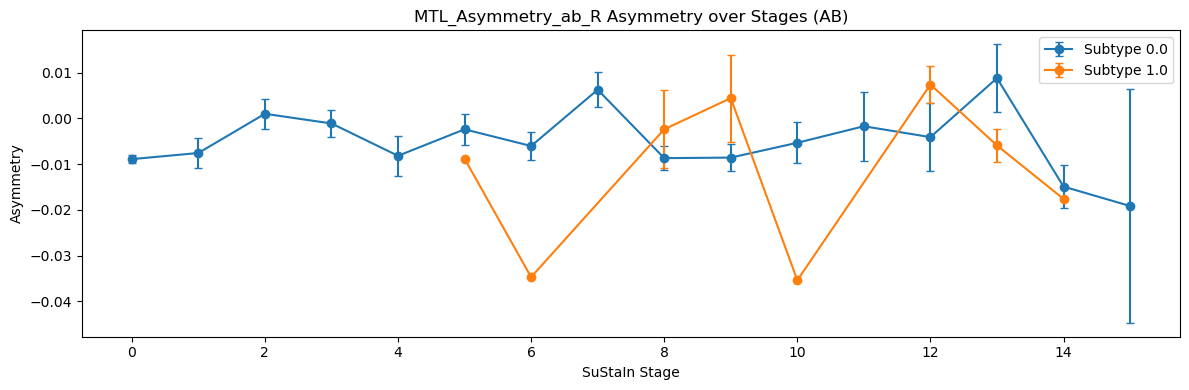


====== Asymmetry Across Stages in TAU ======
Frontal_lobe_Asymmetry_tau_L | Subtype 0.0 | Slope = 0.000, r = 0.04, p = 0.9005
Frontal_lobe_Asymmetry_tau_L | Subtype 1.0 | Slope = -0.000, r = -0.07, p = 0.8092
Frontal_lobe_Asymmetry_tau_L | Subtype 2.0 | Slope = -0.003, r = -0.23, p = 0.4249
Frontal_lobe_Asymmetry_tau_L | Subtype 3.0 | Slope = 0.002, r = 0.27, p = 0.4175


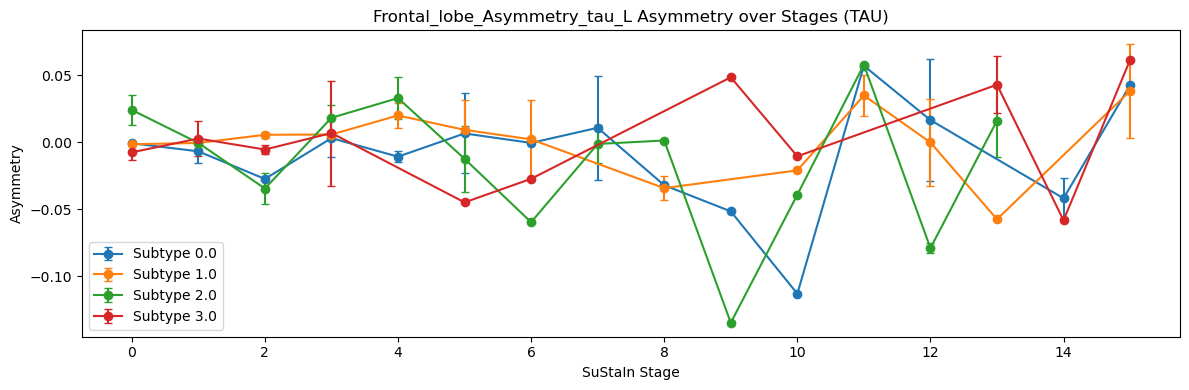

Frontal_lobe_Asymmetry_tau_R | Subtype 0.0 | Slope = -0.000, r = -0.04, p = 0.9005
Frontal_lobe_Asymmetry_tau_R | Subtype 1.0 | Slope = 0.000, r = 0.07, p = 0.8092
Frontal_lobe_Asymmetry_tau_R | Subtype 2.0 | Slope = 0.003, r = 0.23, p = 0.4249
Frontal_lobe_Asymmetry_tau_R | Subtype 3.0 | Slope = -0.002, r = -0.27, p = 0.4175


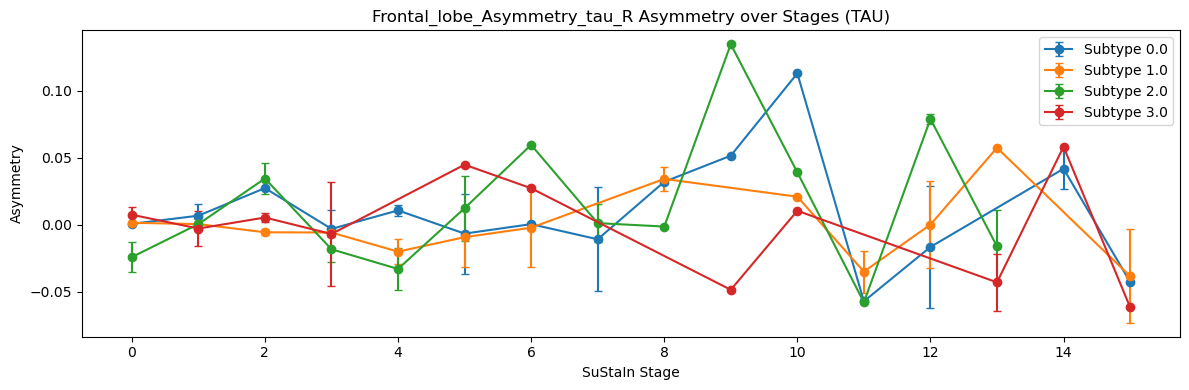

Occipital_lobe_Asymmetry_tau_L | Subtype 0.0 | Slope = 0.000, r = 0.03, p = 0.9160
Occipital_lobe_Asymmetry_tau_L | Subtype 1.0 | Slope = -0.002, r = -0.13, p = 0.6763
Occipital_lobe_Asymmetry_tau_L | Subtype 2.0 | Slope = -0.002, r = -0.15, p = 0.5982
Occipital_lobe_Asymmetry_tau_L | Subtype 3.0 | Slope = 0.002, r = 0.22, p = 0.5134


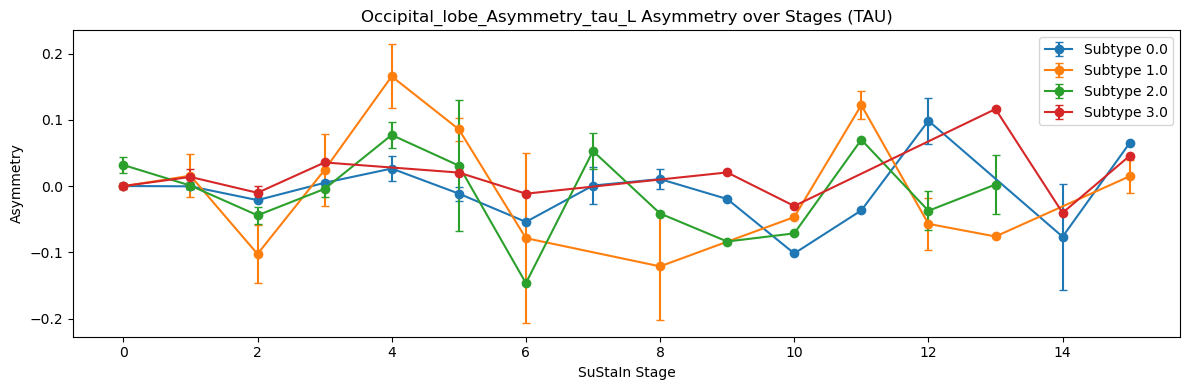

Occipital_lobe_Asymmetry_tau_R | Subtype 0.0 | Slope = -0.000, r = -0.03, p = 0.9160
Occipital_lobe_Asymmetry_tau_R | Subtype 1.0 | Slope = 0.002, r = 0.13, p = 0.6763
Occipital_lobe_Asymmetry_tau_R | Subtype 2.0 | Slope = 0.002, r = 0.15, p = 0.5982
Occipital_lobe_Asymmetry_tau_R | Subtype 3.0 | Slope = -0.002, r = -0.22, p = 0.5134


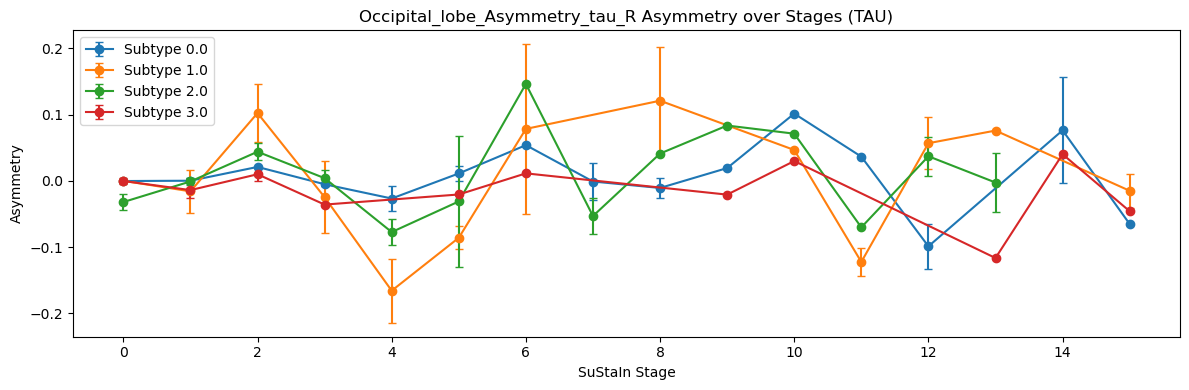

Parietal_lobe_Asymmetry_tau_L | Subtype 0.0 | Slope = 0.003, r = 0.26, p = 0.3530
Parietal_lobe_Asymmetry_tau_L | Subtype 1.0 | Slope = -0.001, r = -0.09, p = 0.7820
Parietal_lobe_Asymmetry_tau_L | Subtype 2.0 | Slope = -0.004, r = -0.28, p = 0.3344
Parietal_lobe_Asymmetry_tau_L | Subtype 3.0 | Slope = 0.002, r = 0.13, p = 0.7019


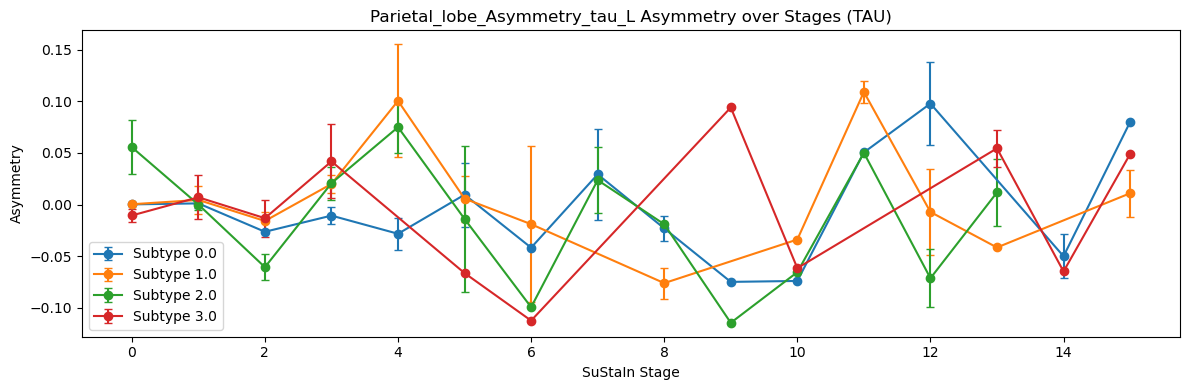

Parietal_lobe_Asymmetry_tau_R | Subtype 0.0 | Slope = -0.003, r = -0.26, p = 0.3530
Parietal_lobe_Asymmetry_tau_R | Subtype 1.0 | Slope = 0.001, r = 0.09, p = 0.7820
Parietal_lobe_Asymmetry_tau_R | Subtype 2.0 | Slope = 0.004, r = 0.28, p = 0.3344
Parietal_lobe_Asymmetry_tau_R | Subtype 3.0 | Slope = -0.002, r = -0.13, p = 0.7019


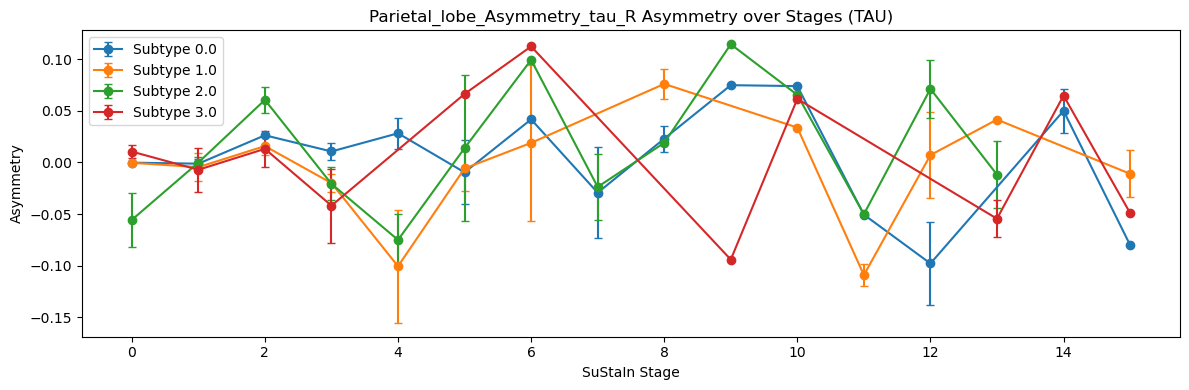

Temporal_lobe_Asymmetry_tau_L | Subtype 0.0 | Slope = 0.001, r = 0.11, p = 0.7085
Temporal_lobe_Asymmetry_tau_L | Subtype 1.0 | Slope = 0.001, r = 0.09, p = 0.7579
Temporal_lobe_Asymmetry_tau_L | Subtype 2.0 | Slope = -0.004, r = -0.28, p = 0.3273
Temporal_lobe_Asymmetry_tau_L | Subtype 3.0 | Slope = 0.002, r = 0.19, p = 0.5706


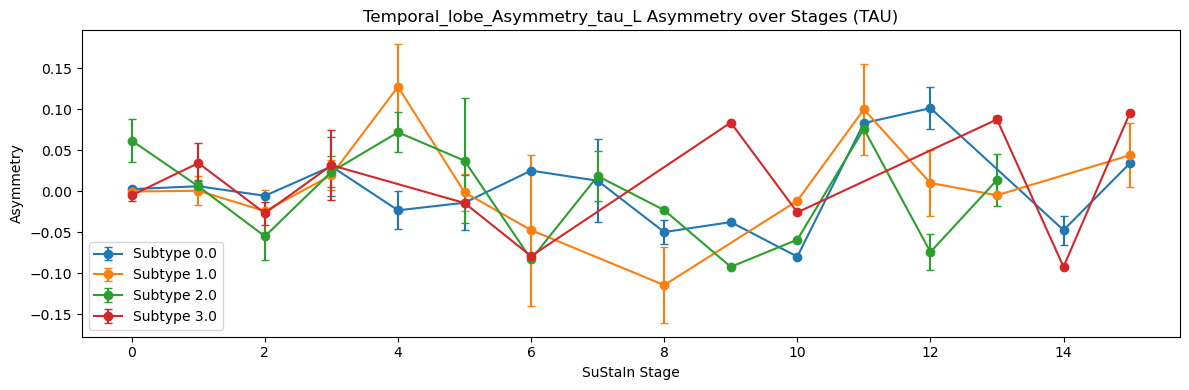

Temporal_lobe_Asymmetry_tau_R | Subtype 0.0 | Slope = -0.001, r = -0.11, p = 0.7085
Temporal_lobe_Asymmetry_tau_R | Subtype 1.0 | Slope = -0.001, r = -0.09, p = 0.7579
Temporal_lobe_Asymmetry_tau_R | Subtype 2.0 | Slope = 0.004, r = 0.28, p = 0.3273
Temporal_lobe_Asymmetry_tau_R | Subtype 3.0 | Slope = -0.002, r = -0.19, p = 0.5706


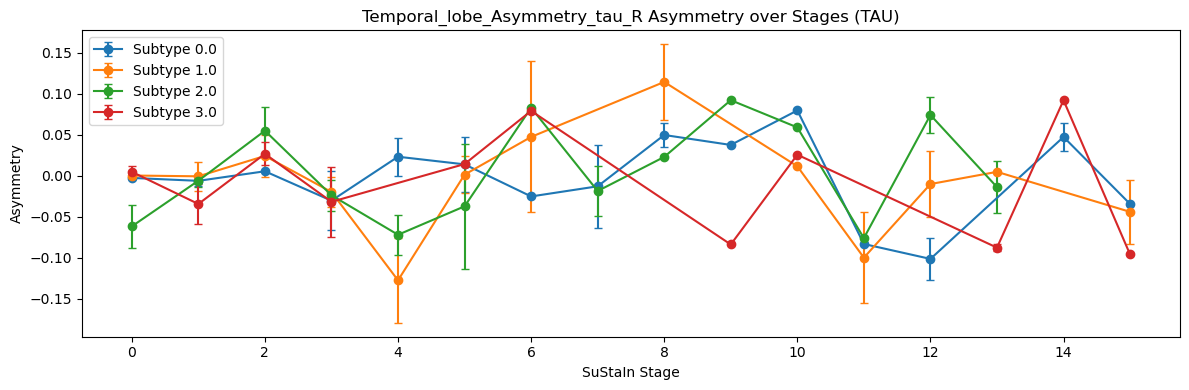

MTL_Asymmetry_tau_L | Subtype 0.0 | Slope = -0.000, r = -0.07, p = 0.8012
MTL_Asymmetry_tau_L | Subtype 1.0 | Slope = 0.000, r = 0.04, p = 0.8934
MTL_Asymmetry_tau_L | Subtype 2.0 | Slope = -0.002, r = -0.43, p = 0.1212
MTL_Asymmetry_tau_L | Subtype 3.0 | Slope = 0.000, r = 0.13, p = 0.7113


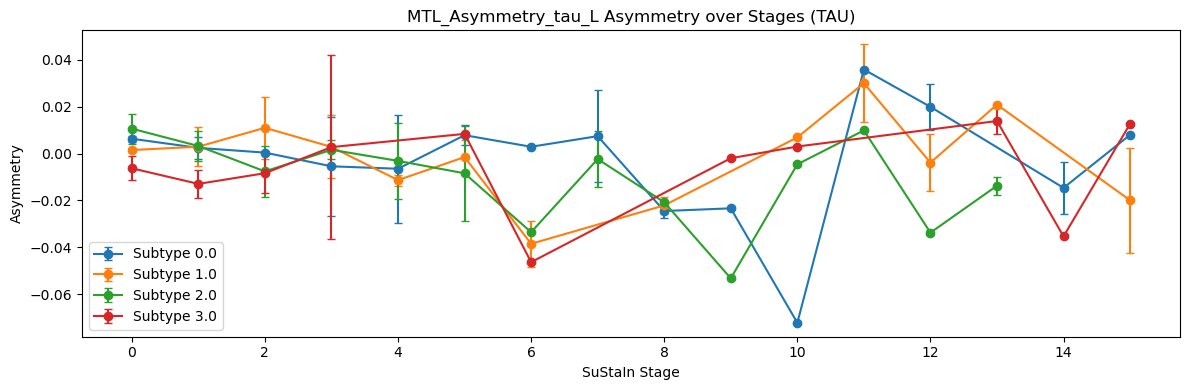

MTL_Asymmetry_tau_R | Subtype 0.0 | Slope = 0.000, r = 0.07, p = 0.8012
MTL_Asymmetry_tau_R | Subtype 1.0 | Slope = -0.000, r = -0.04, p = 0.8934
MTL_Asymmetry_tau_R | Subtype 2.0 | Slope = 0.002, r = 0.43, p = 0.1212
MTL_Asymmetry_tau_R | Subtype 3.0 | Slope = -0.000, r = -0.13, p = 0.7113


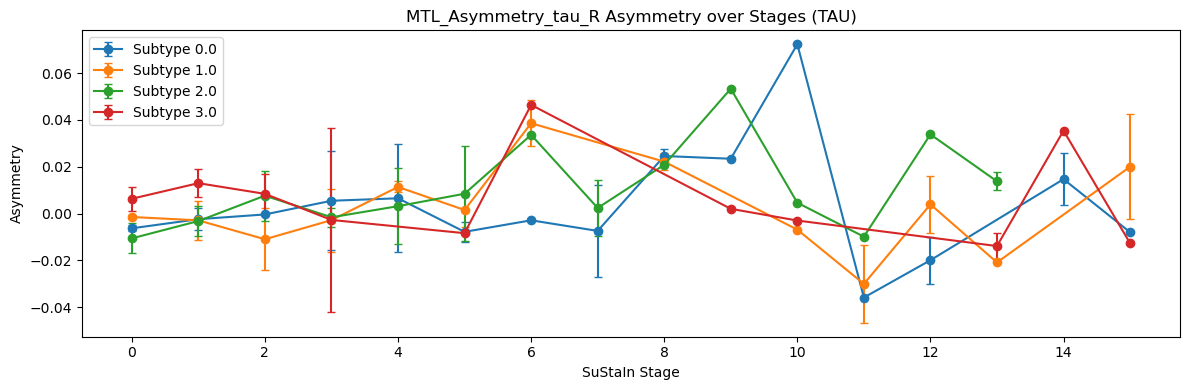


====== Asymmetry Across Stages in MRI ======
Frontal_lobe_Asymmetry_MRI_L | Subtype 0.0 | Slope = -0.000, r = -0.43, p = 0.1830
Frontal_lobe_Asymmetry_MRI_L | Subtype 1.0 | Slope = 0.002, r = 0.63, p = 0.1314
Frontal_lobe_Asymmetry_MRI_L | Subtype 2.0 | Slope = -0.003, r = -0.36, p = 0.3878
Frontal_lobe_Asymmetry_MRI_L | Subtype 3.0 | Slope = 0.001, r = 0.26, p = 0.6226


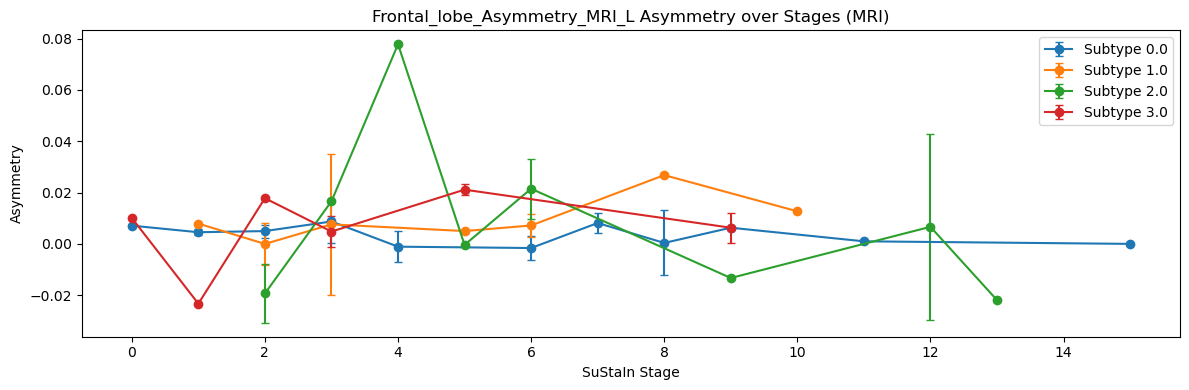

Frontal_lobe_Asymmetry_MRI_R | Subtype 0.0 | Slope = 0.000, r = 0.43, p = 0.1830
Frontal_lobe_Asymmetry_MRI_R | Subtype 1.0 | Slope = -0.002, r = -0.63, p = 0.1314
Frontal_lobe_Asymmetry_MRI_R | Subtype 2.0 | Slope = 0.003, r = 0.36, p = 0.3878
Frontal_lobe_Asymmetry_MRI_R | Subtype 3.0 | Slope = -0.001, r = -0.26, p = 0.6226


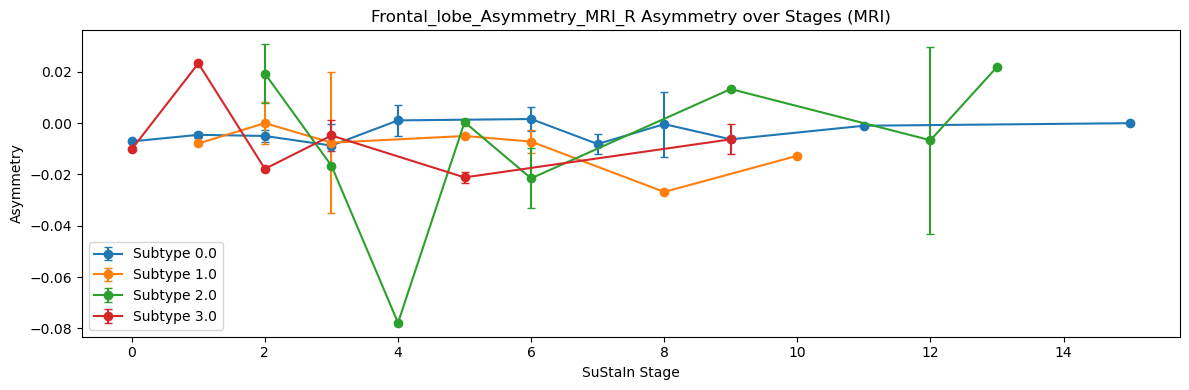

Occipital_lobe_Asymmetry_MRI_L | Subtype 0.0 | Slope = 0.002, r = 0.42, p = 0.1994
Occipital_lobe_Asymmetry_MRI_L | Subtype 1.0 | Slope = 0.000, r = 0.00, p = 1.0000
Occipital_lobe_Asymmetry_MRI_L | Subtype 2.0 | Slope = 0.004, r = 0.65, p = 0.0799
Occipital_lobe_Asymmetry_MRI_L | Subtype 3.0 | Slope = 0.011, r = 0.62, p = 0.1906


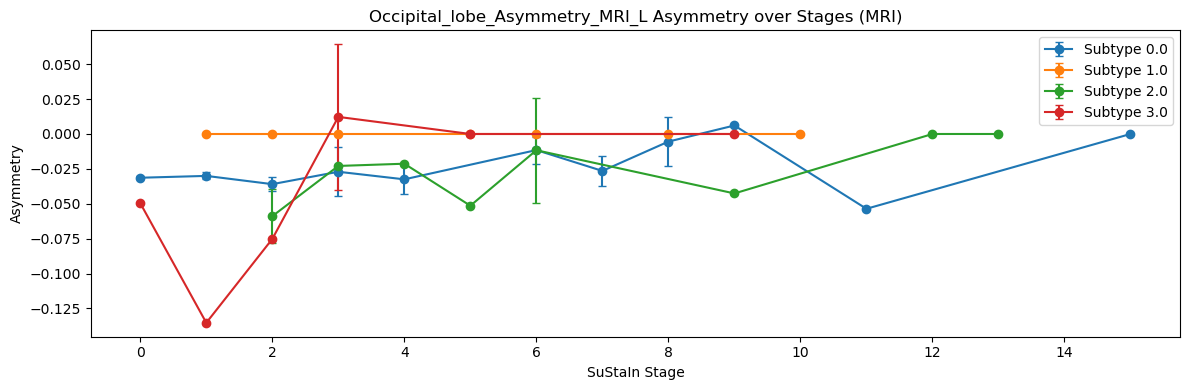

Occipital_lobe_Asymmetry_MRI_R | Subtype 0.0 | Slope = -0.002, r = -0.42, p = 0.1994
Occipital_lobe_Asymmetry_MRI_R | Subtype 1.0 | Slope = 0.000, r = 0.00, p = 1.0000
Occipital_lobe_Asymmetry_MRI_R | Subtype 2.0 | Slope = -0.004, r = -0.65, p = 0.0799
Occipital_lobe_Asymmetry_MRI_R | Subtype 3.0 | Slope = -0.011, r = -0.62, p = 0.1906


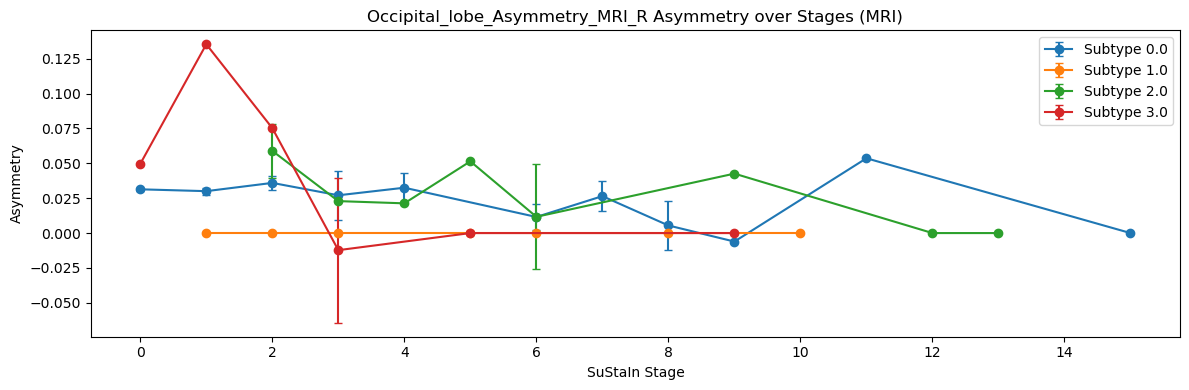

Parietal_lobe_Asymmetry_MRI_L | Subtype 0.0 | Slope = 0.000, r = 0.10, p = 0.7759
Parietal_lobe_Asymmetry_MRI_L | Subtype 1.0 | Slope = -0.001, r = -0.34, p = 0.4557
Parietal_lobe_Asymmetry_MRI_L | Subtype 2.0 | Slope = 0.004, r = 0.83, p = 0.0099
Parietal_lobe_Asymmetry_MRI_L | Subtype 3.0 | Slope = -0.000, r = -0.02, p = 0.9636


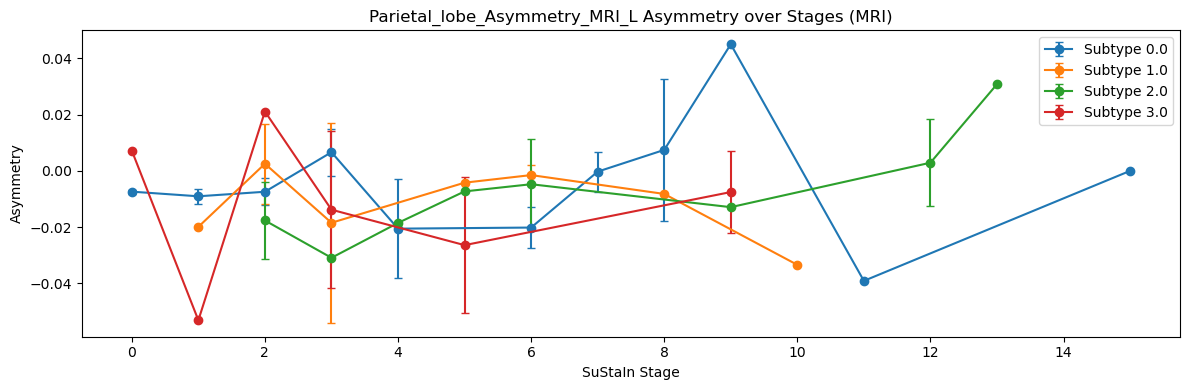

Parietal_lobe_Asymmetry_MRI_R | Subtype 0.0 | Slope = -0.000, r = -0.10, p = 0.7759
Parietal_lobe_Asymmetry_MRI_R | Subtype 1.0 | Slope = 0.001, r = 0.34, p = 0.4557
Parietal_lobe_Asymmetry_MRI_R | Subtype 2.0 | Slope = -0.004, r = -0.83, p = 0.0099
Parietal_lobe_Asymmetry_MRI_R | Subtype 3.0 | Slope = 0.000, r = 0.02, p = 0.9636


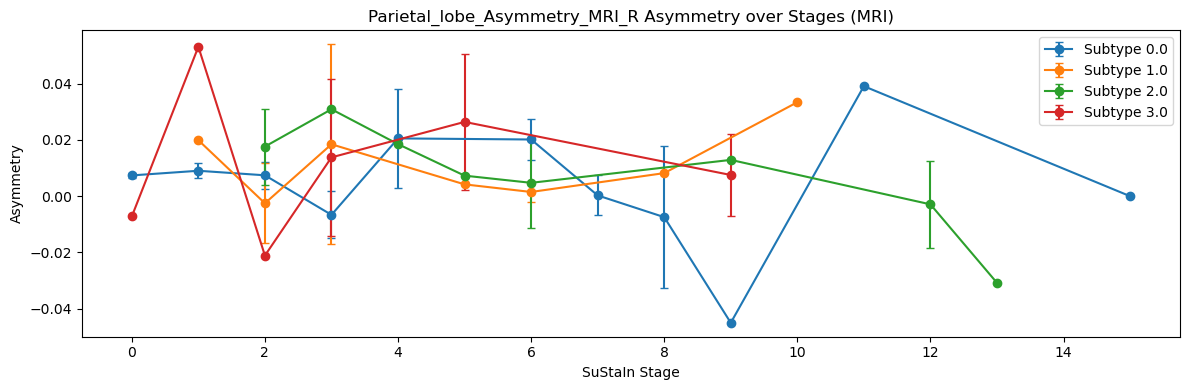

Temporal_lobe_Asymmetry_MRI_L | Subtype 0.0 | Slope = -0.000, r = -0.04, p = 0.9159
Temporal_lobe_Asymmetry_MRI_L | Subtype 1.0 | Slope = 0.011, r = 0.70, p = 0.0809
Temporal_lobe_Asymmetry_MRI_L | Subtype 2.0 | Slope = 0.003, r = 0.24, p = 0.5712
Temporal_lobe_Asymmetry_MRI_L | Subtype 3.0 | Slope = 0.001, r = 0.06, p = 0.9047


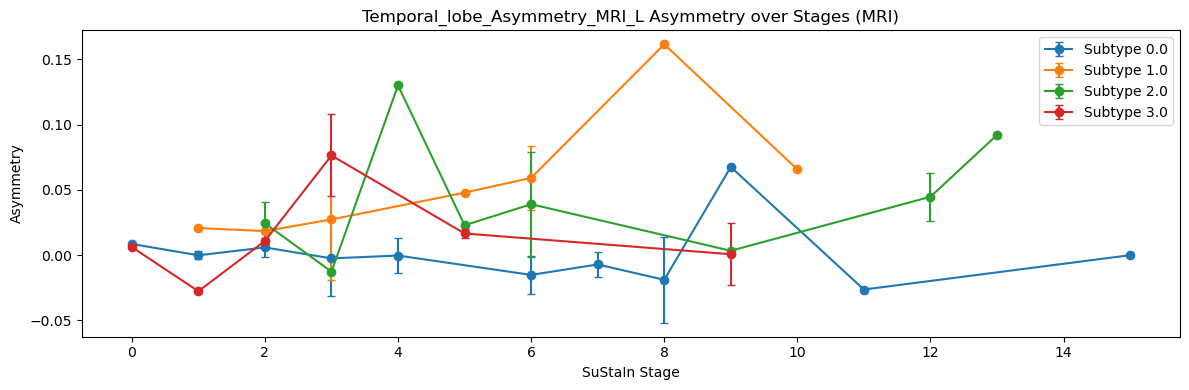

Temporal_lobe_Asymmetry_MRI_R | Subtype 0.0 | Slope = 0.000, r = 0.04, p = 0.9159
Temporal_lobe_Asymmetry_MRI_R | Subtype 1.0 | Slope = -0.011, r = -0.70, p = 0.0809
Temporal_lobe_Asymmetry_MRI_R | Subtype 2.0 | Slope = -0.003, r = -0.24, p = 0.5712
Temporal_lobe_Asymmetry_MRI_R | Subtype 3.0 | Slope = -0.001, r = -0.06, p = 0.9047


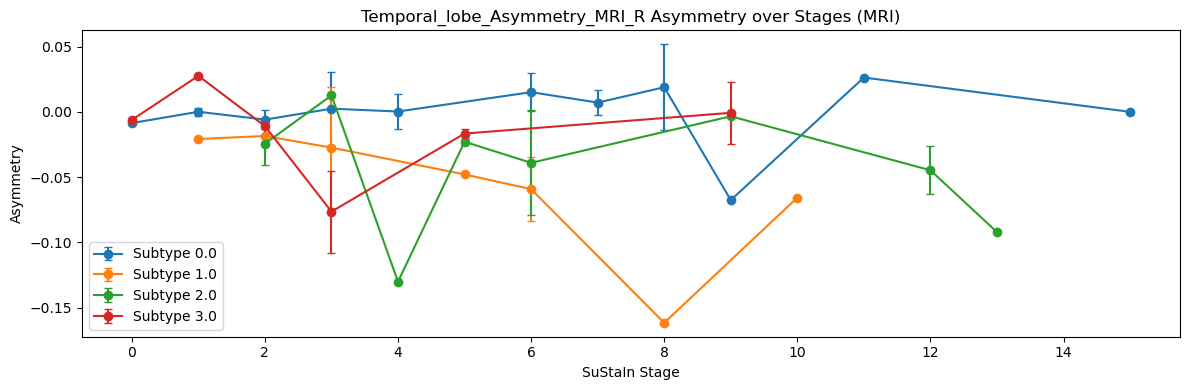

MTL_Asymmetry_MRI_L | Subtype 0.0 | Slope = 0.003, r = 0.49, p = 0.1277
MTL_Asymmetry_MRI_L | Subtype 1.0 | Slope = 0.000, r = 0.01, p = 0.9869
MTL_Asymmetry_MRI_L | Subtype 2.0 | Slope = -0.003, r = -0.64, p = 0.0900
MTL_Asymmetry_MRI_L | Subtype 3.0 | Slope = -0.001, r = -0.30, p = 0.5696


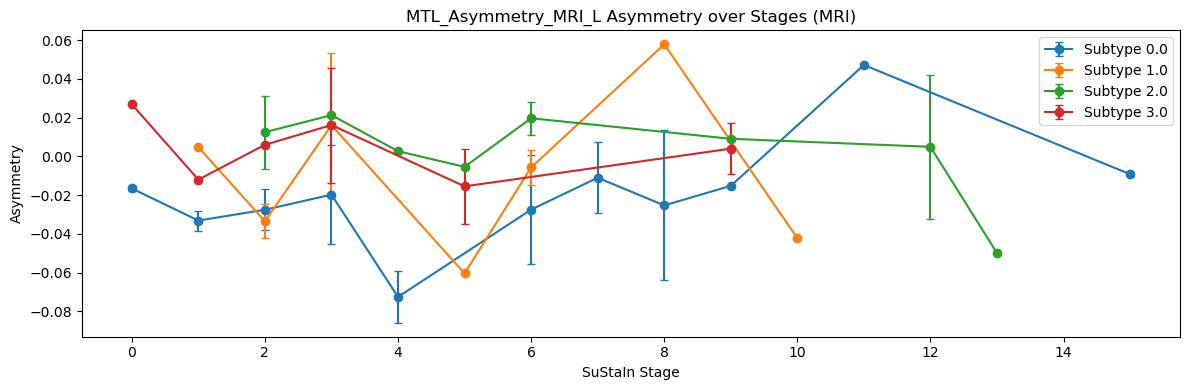

MTL_Asymmetry_MRI_R | Subtype 0.0 | Slope = -0.003, r = -0.49, p = 0.1277
MTL_Asymmetry_MRI_R | Subtype 1.0 | Slope = -0.000, r = -0.01, p = 0.9869
MTL_Asymmetry_MRI_R | Subtype 2.0 | Slope = 0.003, r = 0.64, p = 0.0900
MTL_Asymmetry_MRI_R | Subtype 3.0 | Slope = 0.001, r = 0.30, p = 0.5696


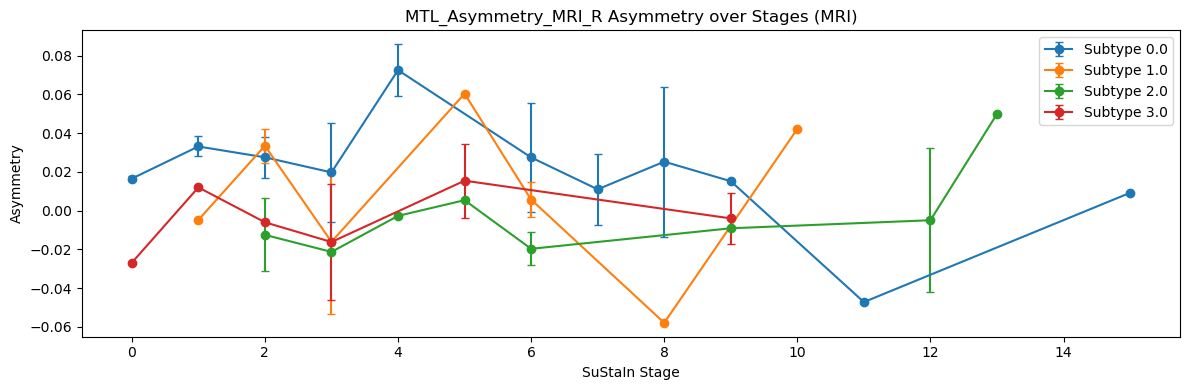

In [21]:
# Asymmetry variable lists assumed already defined
asymmetry_vars = {
    'MRI': asym_mri,
    'AB': asym_ab,
    'TAU': asym_tau
}

# Add explicit stage column names
modality_stage_cols = {
    'MRI': 'ml_stage_MRI',
    'AB': 'ml_stage_AB',
    'TAU': 'ml_stage_TAU'
}

# Plot asymmetry across SuStaIn stages by subtype
for modality, (subtype_col, df) in modalities.items():
    print(f"\n====== Asymmetry Across Stages in {modality} ======")

    stage_col = modality_stage_cols.get(modality)
    if stage_col not in df.columns:
        print(f"  Stage column '{stage_col}' not found in DataFrame.")
        continue

    asym_vars = asymmetry_vars[modality]
    subtypes = sorted(df[subtype_col].dropna().unique())

    for region in asym_vars:
        plt.figure(figsize=(12, 4))
        for subtype in subtypes:
            sub_df = df[df[subtype_col] == subtype]
            grouped = sub_df.groupby(stage_col)[region]
            means = grouped.mean()
            sems = grouped.sem()

            if means.empty:
                continue

            plt.errorbar(means.index, means.values, yerr=sems, label=f'Subtype {subtype}',
                         marker='o', capsize=3)

            # Linear trend stats (optional)
            if len(means) > 1:
                slope, _, r, pval, _ = linregress(means.index, means.values)
                print(f"{region} | Subtype {subtype} | Slope = {slope:.3f}, r = {r:.2f}, p = {pval:.4f}")

        plt.title(f"{region} Asymmetry over Stages ({modality})")
        plt.xlabel('SuStaIn Stage')
        plt.ylabel('Asymmetry')
        plt.legend()
        plt.tight_layout()
        plt.show()


In [58]:
# significant_results = []

# for modality, (subtype_col, df) in modalities.items():
#     #print(f"\n====== Asymmetry Across Stages in {modality} ======")

#     stage_col = modality_stage_cols.get(modality)
#     if stage_col not in df.columns:
#         print(f"  Stage column '{stage_col}' not found in DataFrame.")
#         continue

#     asym_vars = asymmetry_vars[modality]
#     subtypes = sorted(df[subtype_col].dropna().unique())

#     for region in asym_vars:
#         for subtype in subtypes:
#             sub_df = df[df[subtype_col] == subtype]
#             grouped = sub_df.groupby(stage_col)[region]
#             means = grouped.mean()

#             if len(means) > 1:
#                 slope, _, r, pval, _ = linregress(means.index, means.values)
#                 #print(f"{region} | Subtype {subtype} | Slope = {slope:.3f}, r = {r:.2f}, p = {pval:.4f}")

#                 if pval < 0.05:
#                     significant_results.append({
#                         'Modality': modality,
#                         'Region': region,
#                         'Subtype': subtype,
#                         'Slope': slope,
#                         'r': r,
#                         'p': pval
#                     })

# # Convert to DataFrame and display
# sig_df = pd.DataFrame(significant_results)
# if not sig_df.empty:
#     print("\n====== Statistically Significant Asymmetry Findings (p < 0.05) ======")
#     print(sig_df.sort_values(['Modality', 'p']))
# else:
#     print("\nNo statistically significant asymmetry trends detected (p < 0.05).")


In [59]:
# Store onset stages
asym_onsets = []

for modality, (subtype_col, df) in modalities.items():
    stage_col = modality_stage_cols.get(modality)
    if stage_col not in df.columns:
        continue

    asym_vars = asymmetry_vars[modality]
    subtypes = sorted(df[subtype_col].dropna().unique())

    for region in asym_vars:
        for subtype in subtypes:
            sub_df = df[df[subtype_col] == subtype]
            grouped = sub_df.groupby(stage_col)[region]

            for stage, values in grouped:
                values = values.dropna()
                if len(values) < 5:
                    continue  # too few samples for t-test

                t_stat, p_val = ttest_1samp(values, 0)
                mean_val = values.mean()

                if p_val < 0.05 and abs(mean_val) > 0.05:
                    asym_onsets.append({
                        'Modality': modality,
                        'Region': region,
                        'Subtype': subtype,
                        'Stage': stage,
                        'MeanAsym': round(mean_val, 3),
                        'p': round(p_val, 4)
                    })
                    break  # First significant stage = onset

onset_df = pd.DataFrame(asym_onsets)
onset_df = onset_df.sort_values(by=['Subtype', 'Stage'])

# Example: Count early asymmetry by region
early_asym_counts = onset_df.groupby(['Modality', 'Subtype', 'Region'])['Stage'].min().sort_values()
print(early_asym_counts)



Modality  Subtype  Region                       
TAU       2.00     Parietal_lobe_Asymmetry_tau_L    2
                   Parietal_lobe_Asymmetry_tau_R    2
MRI       0.00     MTL_Asymmetry_MRI_L              4
                   MTL_Asymmetry_MRI_R              4
Name: Stage, dtype: int64


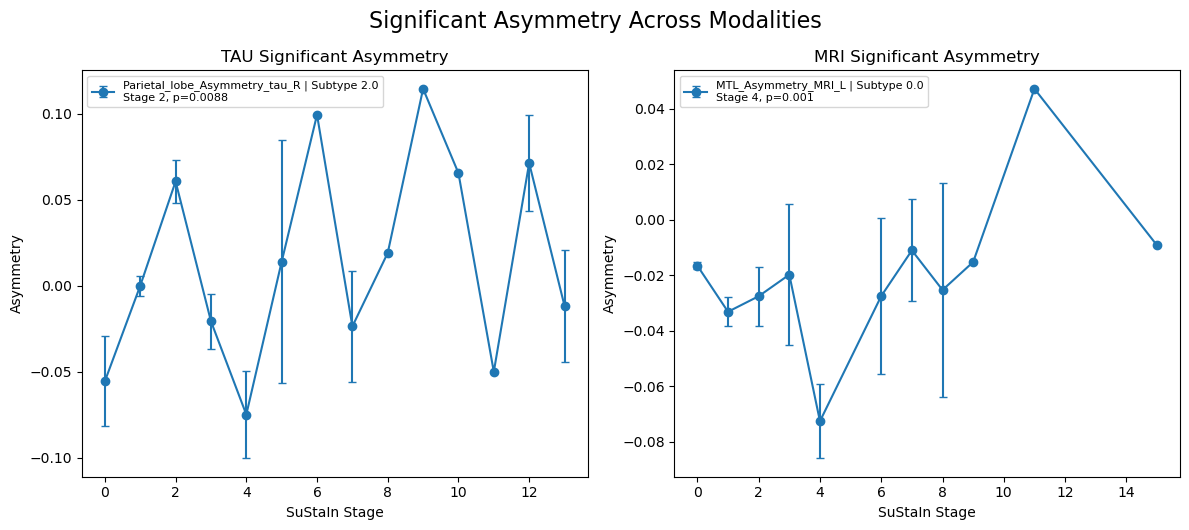

In [68]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Filter modalities with significant regions
sig_modalities = [mod for mod in modalities if not onset_df[onset_df['Modality'] == mod].empty]
n_modalities = len(sig_modalities)

fig, axes = plt.subplots(1, n_modalities, figsize=(6 * n_modalities, 5), squeeze=False)
axes = axes.flatten()

for ax_idx, modality in enumerate(sig_modalities):
    ax = axes[ax_idx]
    stage_col = modality_stage_cols.get(modality)
    df = modalities[modality][1]

    significant_onsets = onset_df[onset_df['Modality'] == modality]
    if significant_onsets.empty:
        ax.axis('off')
        continue

    plotted_any = False
    for _, row in significant_onsets.iterrows():
        region = row['Region']
        subtype = row['Subtype']
        sig_stage = row['Stage']
        sig_pval = row['p']

        sub_df = df[df[modalities[modality][0]] == subtype]
        grouped = sub_df.groupby(stage_col)[region]
        means = grouped.mean()
        sems = grouped.sem()

        if means.empty or len(means) < 2:
            continue

        slope, _, r_value, p_value, _ = linregress(means.index, means.values)
        if slope <= 0:
            continue

        plotted_any = True
        ax.errorbar(
            means.index,
            means.values,
            yerr=sems,
            label=f"{region} | Subtype {subtype}\nStage {sig_stage}, p={sig_pval}",
            marker='o',
            capsize=3
        )

    if plotted_any:
        ax.set_title(f"{modality} Significant Asymmetry")
        ax.set_xlabel("SuStaIn Stage")
        ax.set_ylabel("Asymmetry")
        ax.legend(fontsize=8)
    else:
        ax.axis('off')

plt.tight_layout()
plt.suptitle("Significant Asymmetry Across Modalities", fontsize=16, y=1.05)
plt.savefig("side_by_side_significant_asymmetry.png", bbox_inches='tight')
plt.show()



====== Memory Score Across Stages in AB ======
Subtype 0.0 | Slope = -0.146, r = -0.23, p = 0.3967
Subtype 1.0 | Slope = -1.177, r = -0.43, p = 0.2894


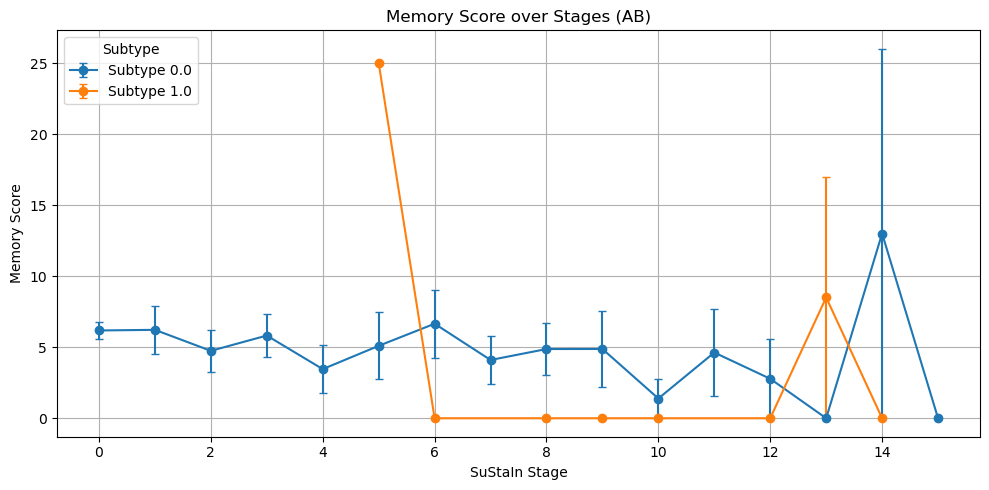


====== Memory Score Across Stages in TAU ======
Subtype 0.0 | Slope = -0.142, r = -0.07, p = 0.8294
Subtype 1.0 | Slope = -0.243, r = -0.43, p = 0.1471
Subtype 2.0 | Slope = 0.046, r = 0.02, p = 0.9520
Subtype 3.0 | Slope = 0.013, r = 0.01, p = 0.9697


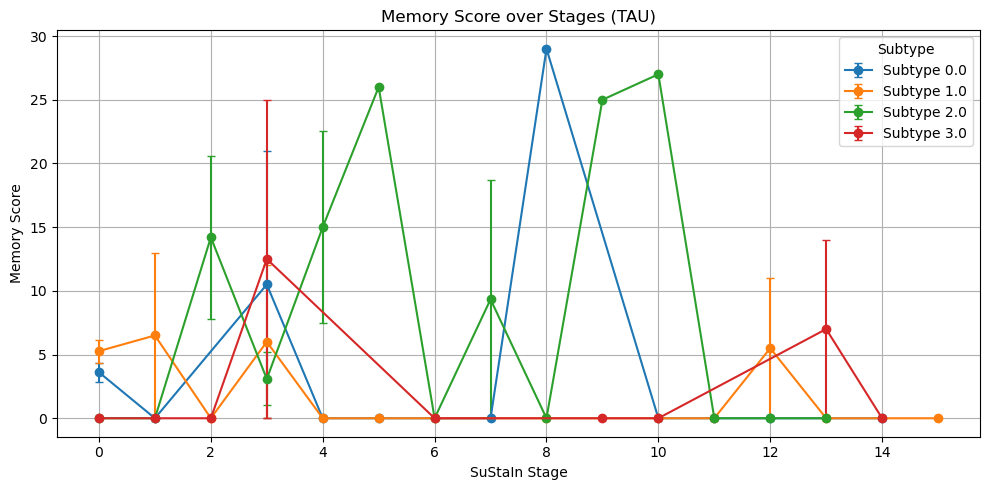


====== Memory Score Across Stages in MRI ======
Subtype 0.0 | Slope = -0.269, r = -0.35, p = 0.2957
Subtype 1.0 | Slope = -0.026, r = -0.02, p = 0.9681
Subtype 2.0 | Slope = -0.212, r = -0.45, p = 0.2643
Subtype 3.0 | Slope = 0.164, r = 0.18, p = 0.7396


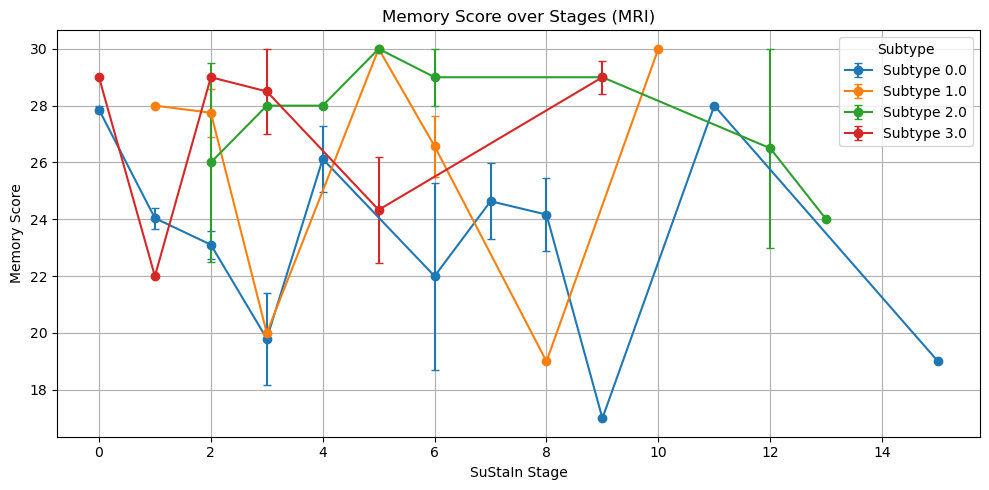

In [24]:
modalities_clean = {
    "AB": ('ml_subtype_AB', zdata_ab_clean),
    "TAU": ('ml_subtype_TAU', zdata_tau_clean),
    "MRI": ('ml_subtype_MRI', zdata_mri)
}

# Define memory score column (you can change 'MEMORY' to your column name like 'ADNI_MEM')
memory_col = mmse_score

# Plot memory score across SuStaIn stages by subtype
for modality, (subtype_col, df) in modalities_clean.items():
    print(f"\n====== Memory Score Across Stages in {modality} ======")

    stage_col = modality_stage_cols.get(modality)
    if stage_col not in df.columns:
        print(f"  Stage column '{stage_col}' not found in DataFrame.")
        continue

    if memory_col not in df.columns:
        print(f"  Memory column '{memory_col}' not found in DataFrame.")
        continue

    subtypes = sorted(df[subtype_col].dropna().unique())

    plt.figure(figsize=(10, 5))
    for subtype in subtypes:
        sub_df = df[df[subtype_col] == subtype]
        grouped = sub_df.groupby(stage_col)[memory_col]
        means = grouped.mean()
        sems = grouped.sem()

        if means.empty:
            continue

        plt.errorbar(means.index, means.values, yerr=sems, label=f'Subtype {subtype}',
                     marker='o', capsize=3)

        # Linear trend stats (optional)
        if len(means) > 1:
            slope, _, r, pval, _ = linregress(means.index, means.values)
            print(f"Subtype {subtype} | Slope = {slope:.3f}, r = {r:.2f}, p = {pval:.4f}")

    plt.title(f"Memory Score over Stages ({modality})")
    plt.xlabel('SuStaIn Stage')
    plt.ylabel('Memory Score')
    plt.legend(title='Subtype')
    plt.grid(True)
    plt.tight_layout()
    plt.show()




====== AB Diagnosis Distribution by Stage within Subtypes ======


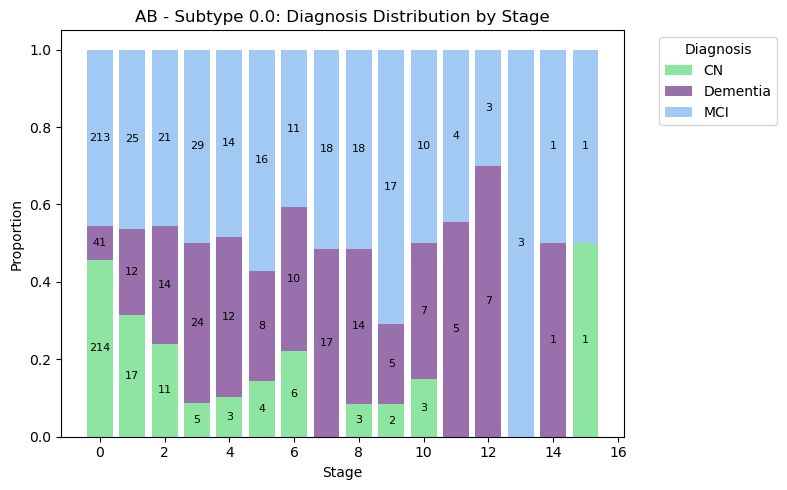

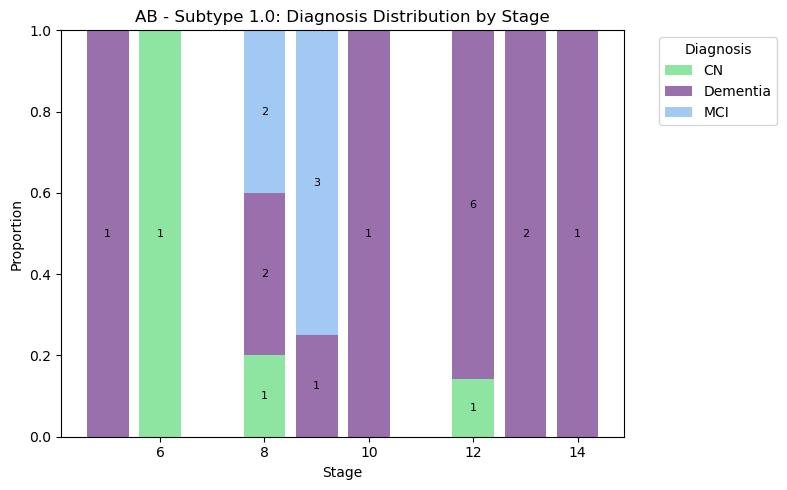



====== TAU Diagnosis Distribution by Stage within Subtypes ======


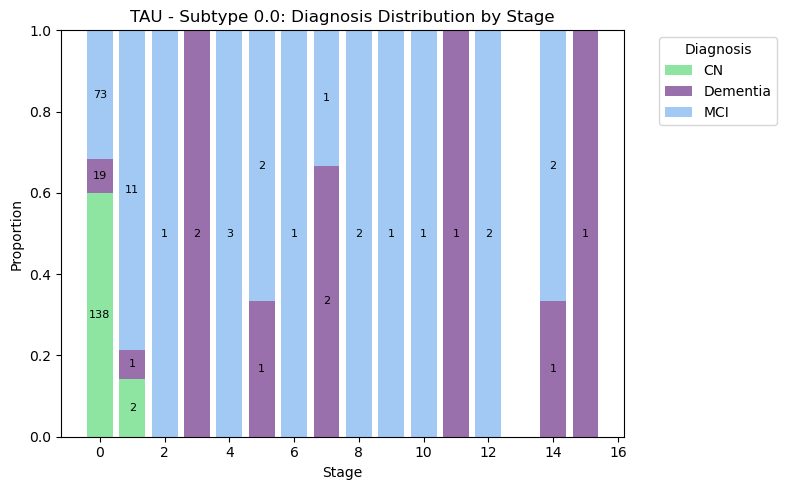

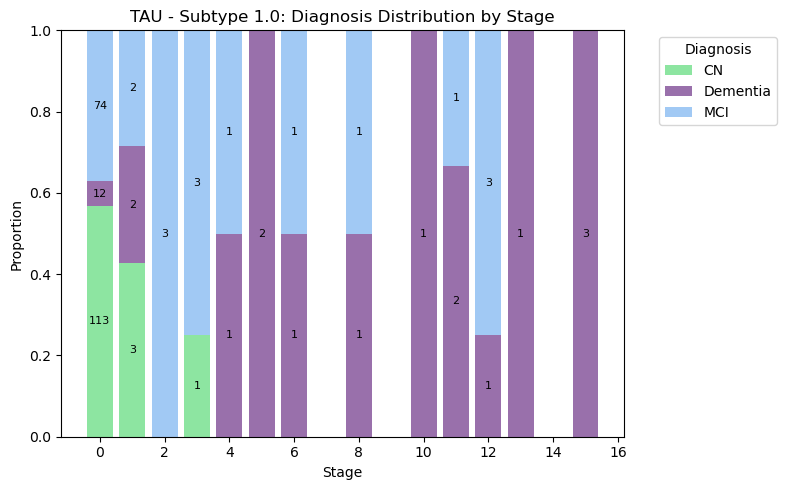

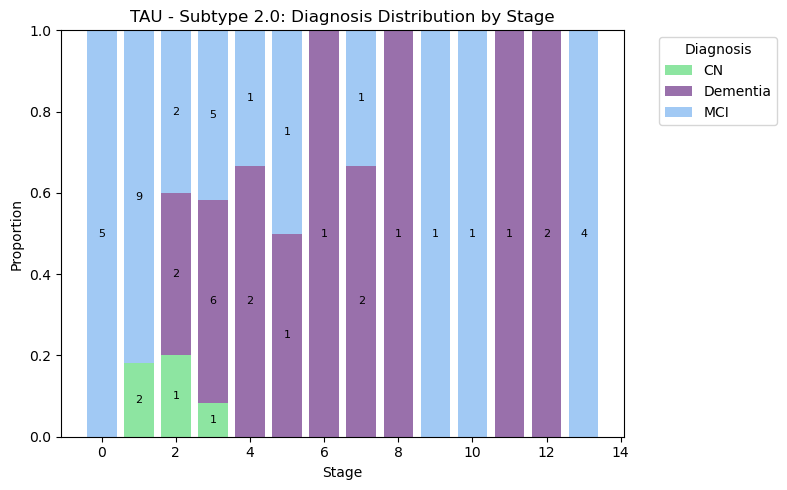

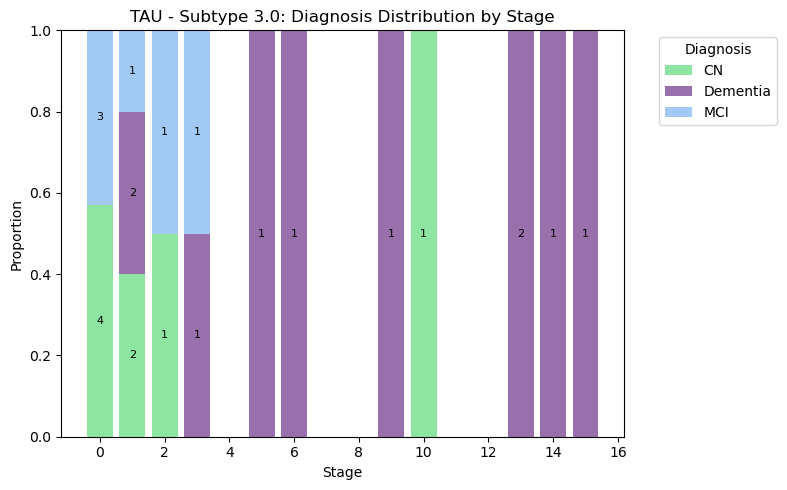



====== MRI Diagnosis Distribution by Stage within Subtypes ======


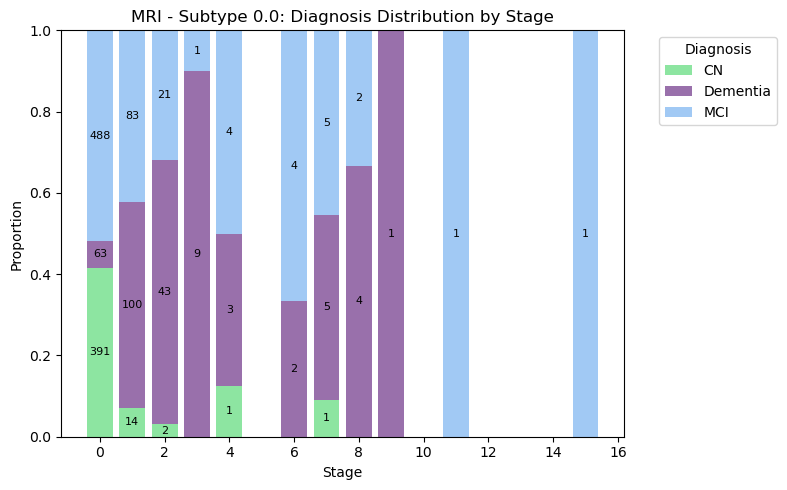

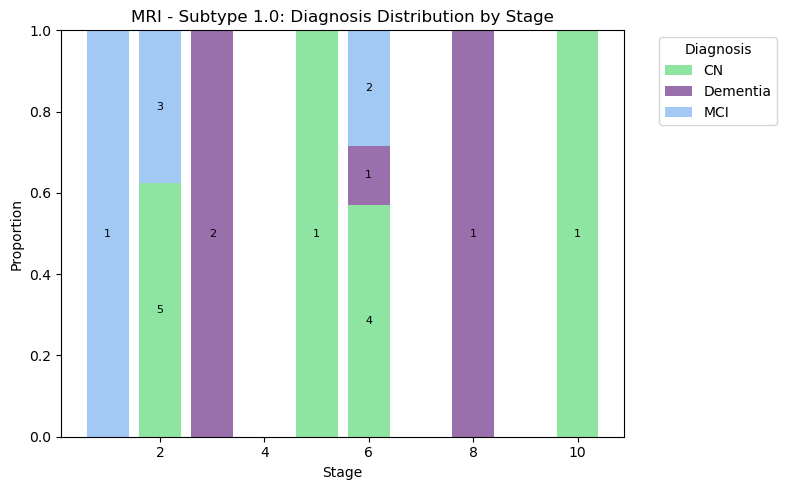

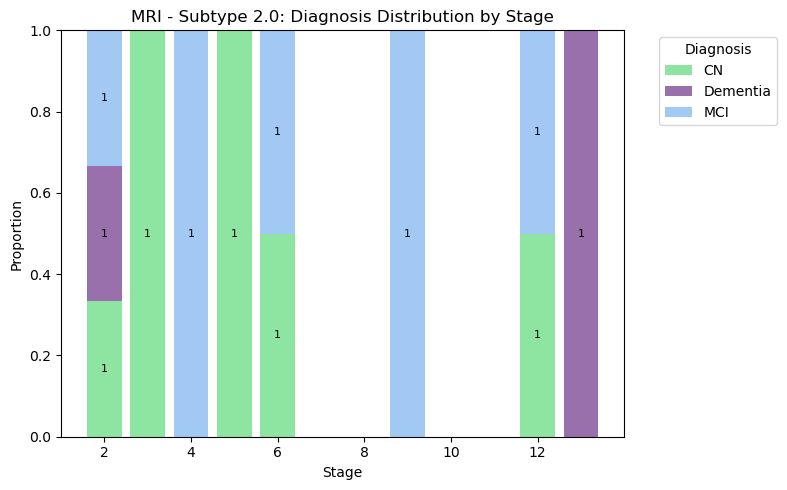

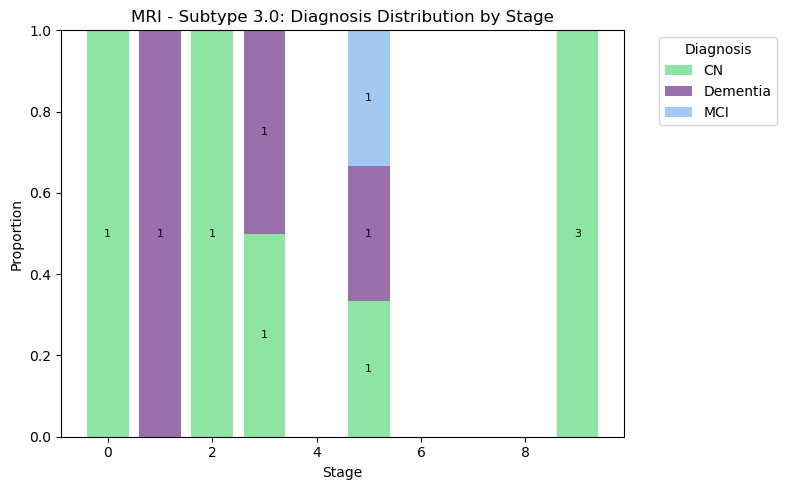



====== AB Stage Distribution Within Each Diagnosis per Subtype ======

Subtype 1.0:

Counts:
ml_stage_AB        0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  \
DIAGNOSIS_STRING                                                                
CN                214  17  11   5   3   4   6   0   3   2   3   0   0   0   0   
Dementia           41  12  14  24  12   8  10  17  14   5   7   5   7   0   1   
MCI               213  25  21  29  14  16  11  18  18  17  10   4   3   3   1   

ml_stage_AB       15  
DIAGNOSIS_STRING      
CN                 1  
Dementia           0  
MCI                1  

Proportions within each diagnosis (row-wise):
ml_stage_AB         0     1     2     3     4     5     6     7     8     9   \
DIAGNOSIS_STRING                                                               
CN                0.80  0.06  0.04  0.02  0.01  0.01  0.02  0.00  0.01  0.01   
Dementia          0.23  0.07  0.08  0.14  0.07  0.05  0.06  0.10  0.08  0.03   
MCI              

In [25]:
colors = ['#8de5a1', '#9970AB', '#a1c9f4', '#FFB347', '#D36C6C']  # Extend if more than 3 diagnoses
diagnosis_col = 'DIAGNOSIS_STRING'  # Update if needed

for modality, (subtype_col, df) in modalities.items():
    print(f"\n\n====== {modality} Diagnosis Distribution by Stage within Subtypes ======")

    # Ensure stage column is integer
    stage_col = subtype_col.replace("subtype", "stage")
    df[stage_col] = df[stage_col].astype(int)

    subtypes = sorted(df[subtype_col].dropna().unique())

    for subtype in subtypes:
        sub_df = df[df[subtype_col] == subtype]
        
        # Crosstab of stage vs diagnosis
        ctab = pd.crosstab(sub_df[stage_col], sub_df[diagnosis_col])

        # Normalize for proportions
        prop = ctab.div(ctab.sum(1), axis=0)

        fig, ax = plt.subplots(figsize=(8, 5))
        bottom = np.zeros(len(prop))

        for i, diag in enumerate(prop.columns):
            values = prop[diag].values
            counts = ctab[diag].values
            bars = ax.bar(prop.index, values, bottom=bottom, label=diag, color=colors[i % len(colors)])

            # Annotate with counts
            for j, bar in enumerate(bars):
                count = counts[j]
                if count > 0:
                    ax.text(bar.get_x() + bar.get_width() / 2,
                            bar.get_y() + bar.get_height() / 2,
                            f'{int(count)}',
                            ha='center', va='center', fontsize=8)

            bottom += values

        ax.set_title(f'{modality} - Subtype {subtype}: Diagnosis Distribution by Stage')
        ax.set_xlabel("Stage")
        ax.set_ylabel("Proportion")
        ax.legend(title="Diagnosis", bbox_to_anchor=(1.05, 1))
        plt.tight_layout()
        plt.show()

for modality, (subtype_col, df) in modalities.items():
    print(f"\n\n====== {modality} Stage Distribution Within Each Diagnosis per Subtype ======")

    stage_col = subtype_col.replace("subtype", "stage")
    df[stage_col] = df[stage_col].astype(int)

    subtypes = sorted(df[subtype_col].dropna().unique())

    for subtype in subtypes:
        sub_df = df[df[subtype_col] == subtype]

        print(f"\nSubtype {subtype+1}:")

        # Crosstab: counts of stages per diagnosis
        ctab = pd.crosstab(sub_df[diagnosis_col], sub_df[stage_col])  # rows = diagnosis, cols = stage
        print("\nCounts:")
        print(ctab)

        # Normalize across rows (i.e., per diagnosis group)
        prop = ctab.div(ctab.sum(axis=1), axis=0)
        print("\nProportions within each diagnosis (row-wise):")
        print(prop.round(2))  # rounded to 2 decimals

    # ✅ Now compute overall stage distribution within each diagnosis group for this modality
    print(f"\n📊 Overall Stage Distribution Within Each Diagnosis Group for {modality}:")

    # Use only rows with non-null subtype/stage
    full_df = df[df[subtype_col].notna() & df[stage_col].notna()]
    
    # Crosstab: total counts of stages per diagnosis
    ctab_overall = pd.crosstab(full_df[diagnosis_col], full_df[stage_col])
    print("\nCounts (overall):")
    print(ctab_overall)

    # Row-wise proportion: within each diagnosis group
    prop_overall = ctab_overall.div(ctab_overall.sum(axis=1), axis=0)
    print("\nProportions within each diagnosis group (row-wise, overall):")
    print(prop_overall.round(2))




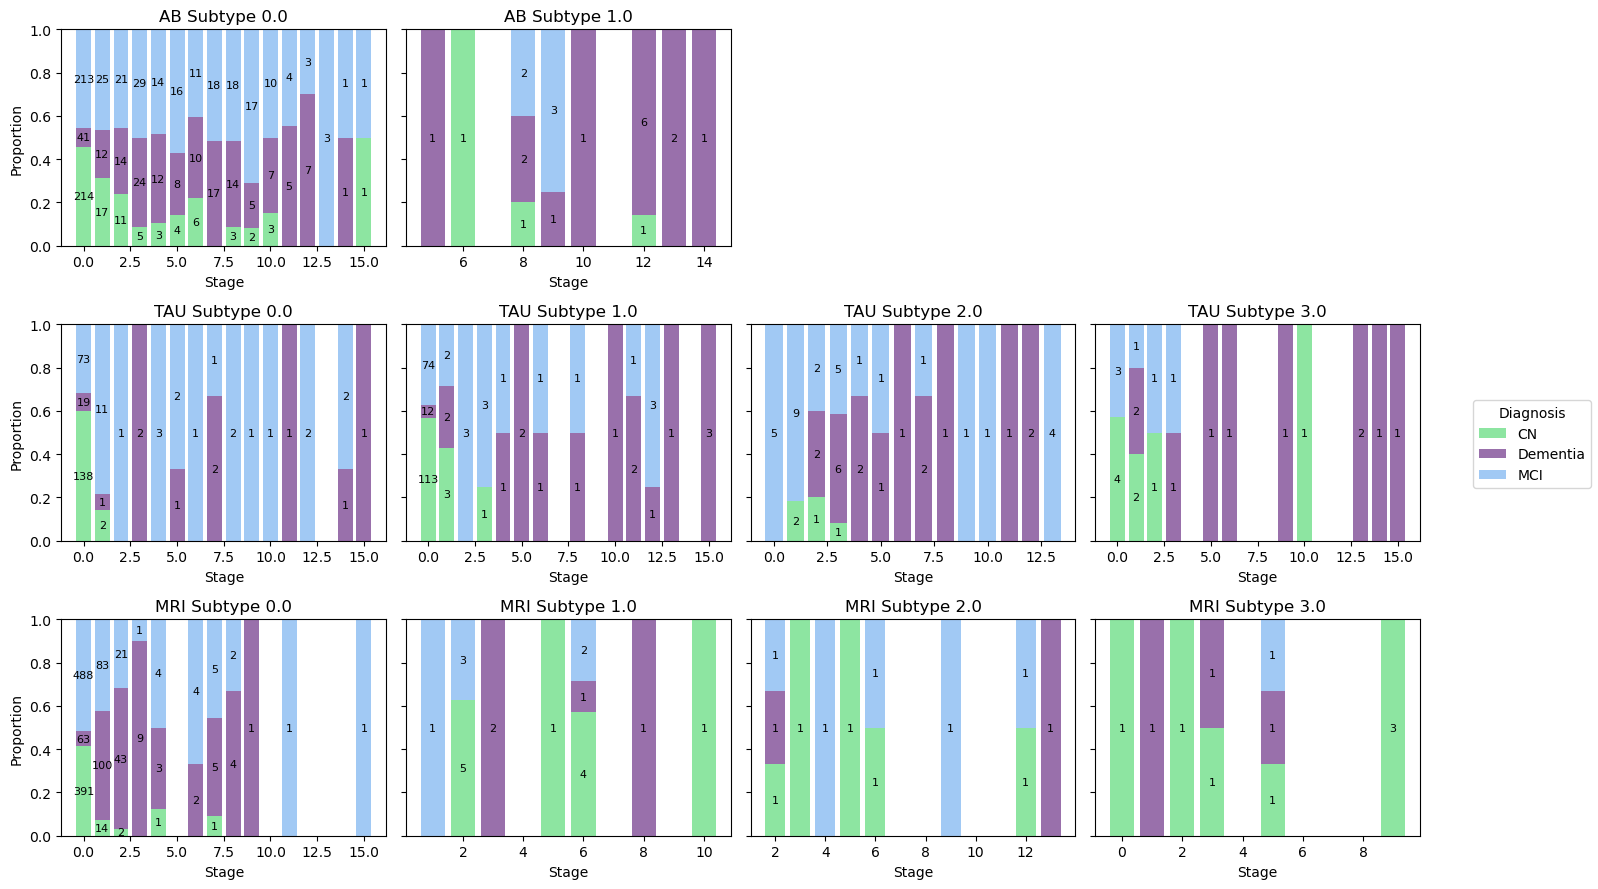

In [45]:
fig, axes = plt.subplots(
    nrows=3, ncols=max_subtypes,
    figsize=(4 * max_subtypes, 3 * 3),  # reduced height from 5*3 to 3*3
    sharey='row'
)

for row_i, modality in enumerate(modalities_order):
    subtype_col, df = modalities[modality]
    stage_col = subtype_col.replace("subtype", "stage")
    df[stage_col] = df[stage_col].astype(int)

    subtypes = sorted(df[subtype_col].dropna().unique())
    n_subtypes = len(subtypes)

    for col_i in range(max_subtypes):
        ax = axes[row_i, col_i] if max_subtypes > 1 else axes[row_i]
        if col_i < n_subtypes:
            subtype = subtypes[col_i]
            sub_df = df[df[subtype_col] == subtype]

            ctab = pd.crosstab(sub_df[stage_col], sub_df[diagnosis_col])
            prop = ctab.div(ctab.sum(1), axis=0)

            bottom = np.zeros(len(prop))
            for i, diag in enumerate(prop.columns):
                values = prop[diag].values
                counts = ctab[diag].values
                bars = ax.bar(prop.index, values, bottom=bottom, label=diag, color=colors[i % len(colors)])

                # Annotate counts
                for j, bar in enumerate(bars):
                    count = counts[j]
                    if count > 0:
                        ax.text(bar.get_x() + bar.get_width()/2,
                                bar.get_y() + bar.get_height()/2,
                                f'{int(count)}',
                                ha='center', va='center', fontsize=8)
                bottom += values

            ax.set_ylim(0, 1)  # limit y-axis
            ax.set_title(f'{modality} Subtype {subtype}')
            ax.set_xlabel('Stage')
            if col_i == 0:
                ax.set_ylabel('Proportion')
        else:
            ax.axis('off')

fig.legend(handles, labels, loc='center right', title='Diagnosis')

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig("diagnosis_distribution_by_stage_all_modalities_shorter.png", dpi=300, bbox_inches='tight')
plt.show()


## 3. Characterise paired subtypes:

In [26]:
# Merge AB + MRI
merged_ab_mri = pd.merge(
    zdata_ab[['RID', 'ml_subtype_AB', 'ml_stage_AB', dx, diagnosis_num, age, mmse_score, apoe4, educ, gender, retire_age] + asymmetry_vars['AB']],
    zdata_mri[['RID', 'ml_subtype_MRI', 'ml_stage_MRI'] + asymmetry_vars['MRI']],
    on='RID'
)

# Merge TAU + MRI
merged_tau_mri = pd.merge(
    zdata_tau[['RID', 'ml_subtype_TAU', 'ml_stage_TAU', dx, diagnosis_num, age, mmse_score, apoe4, educ, gender, retire_age] + asymmetry_vars['TAU']],
    zdata_mri[['RID', 'ml_subtype_MRI', 'ml_stage_MRI'] + asymmetry_vars['MRI']],
    on='RID'
)

# Merge AB + TAU
merged_ab_tau = pd.merge(
    zdata_ab[['RID', 'ml_subtype_AB', 'ml_stage_AB', dx, diagnosis_num, age, mmse_score, apoe4, educ, gender, retire_age] + asymmetry_vars['AB']],
    zdata_tau[['RID', 'ml_subtype_TAU', 'ml_stage_TAU'] + asymmetry_vars['TAU']],
    on='RID'
)




====== AB_TAU Combined Subtype Analysis ======

 AGE (Continuous)
  Group sizes: {'AB_1__TAU_1': 106, 'AB_1__TAU_2': 88, 'AB_1__TAU_3': 23, 'AB_1__TAU_4': 11}
→ ANOVA p = 0.6575 | Eta² = 0.007


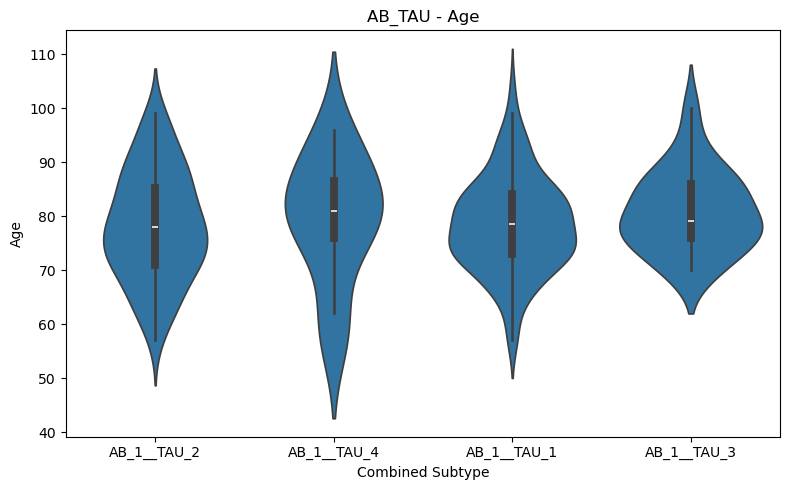


 MMSCORE (Continuous)
  Group sizes: {'AB_1__TAU_1': 9, 'AB_1__TAU_2': 15, 'AB_1__TAU_3': 2, 'AB_1__TAU_4': 2}
 Small sample size detected in at least one group.
→ Kruskal-Wallis p = 0.7222 | Epsilon² = -0.070


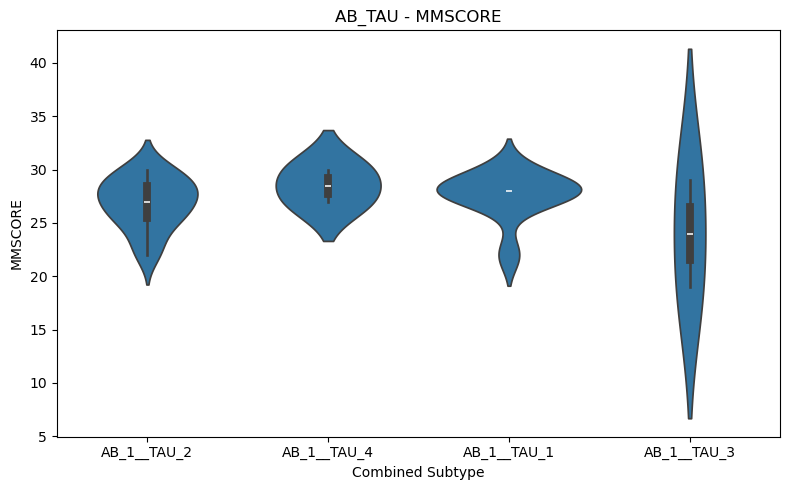


 PTEDUCAT (Continuous)
  Group sizes: {'AB_1__TAU_1': 106, 'AB_1__TAU_2': 88, 'AB_1__TAU_3': 23, 'AB_1__TAU_4': 11}
→ Kruskal-Wallis p = 0.0272 | Epsilon² = 0.027

Post hoc pairwise Mann-Whitney U test results (Bonferroni corrected):
No significant pairwise differences found.


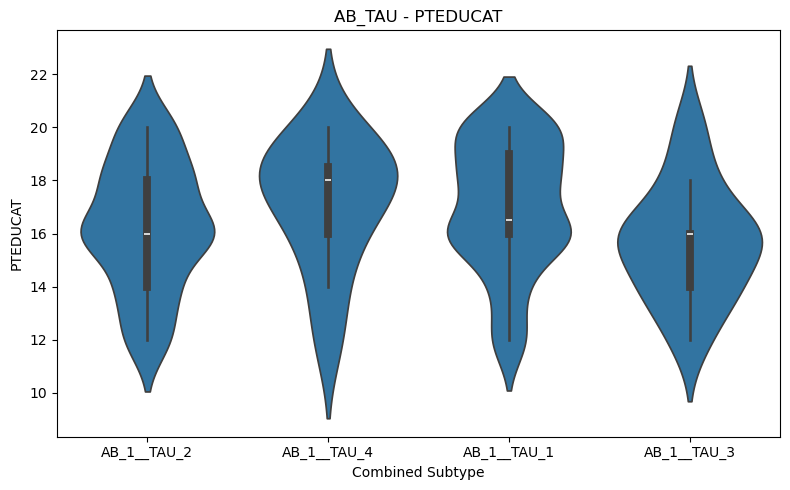


 AGE_RETIRE (Continuous)
  Group sizes: {'AB_1__TAU_1': 77, 'AB_1__TAU_2': 68, 'AB_1__TAU_3': 21, 'AB_1__TAU_4': 7}
→ Kruskal-Wallis p = 0.4809 | Epsilon² = -0.003


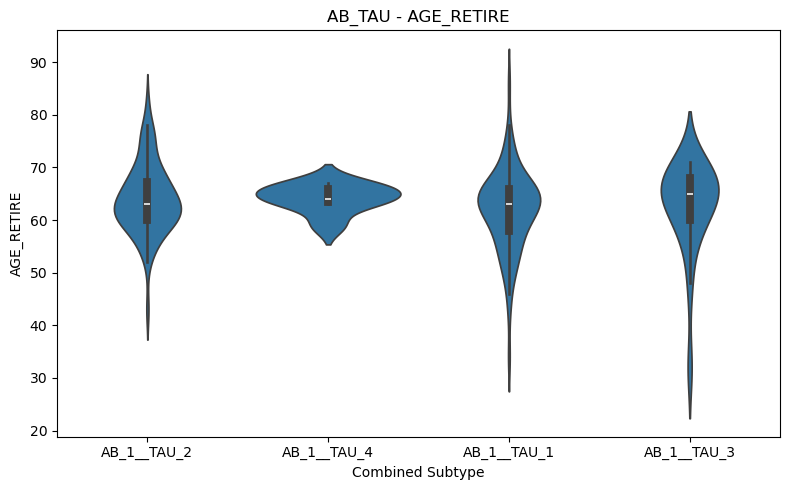


 DIAGNOSIS_STRING (Categorical)
→ Chi-squared p = 0.0262 | Cramér’s V = 0.136

Post hoc (adjusted residuals with Bonferroni correction):
No significant residuals after correction.


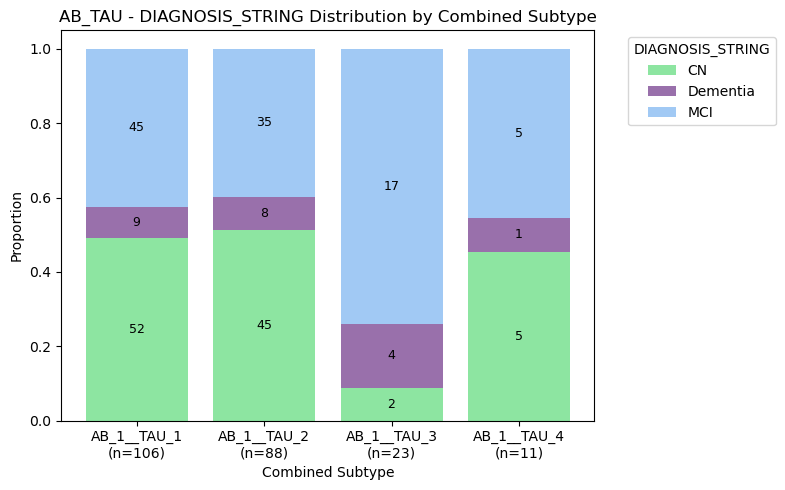


 PTGENDER (Categorical)
→ Chi-squared p = 0.3105 | Cramér’s V = 0.050


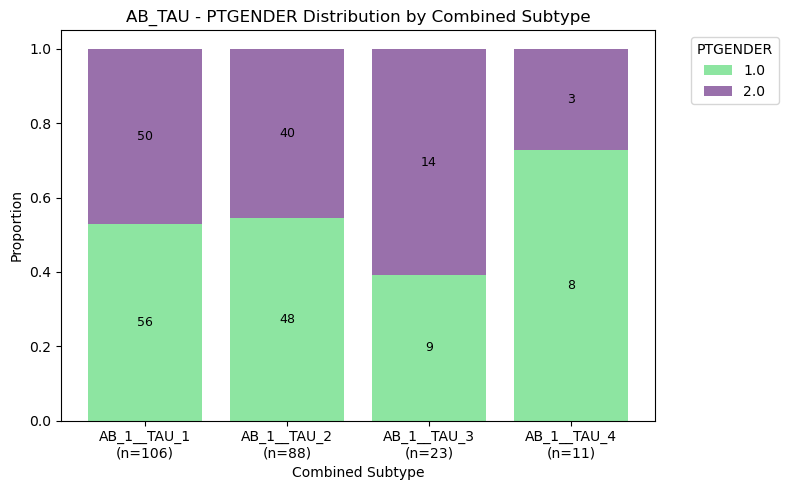


 APOE4 (Categorical)
→ Chi-squared p = 0.0463 | Cramér’s V = 0.122

Post hoc (adjusted residuals with Bonferroni correction):
No significant residuals after correction.


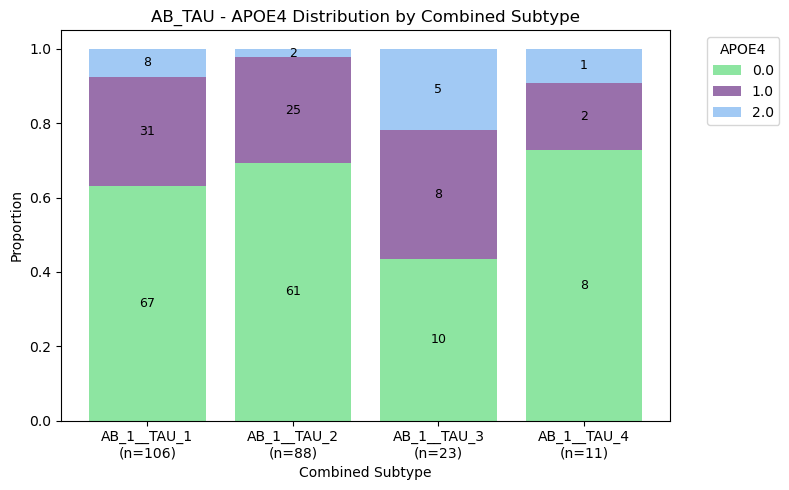



====== TAU_MRI Combined Subtype Analysis ======

 AGE (Continuous)
  Group sizes: {'TAU_1__MRI_1': 207, 'TAU_2__MRI_1': 181, 'TAU_3__MRI_1': 46, 'TAU_4__MRI_1': 19}
→ ANOVA p = 0.4669 | Eta² = 0.006


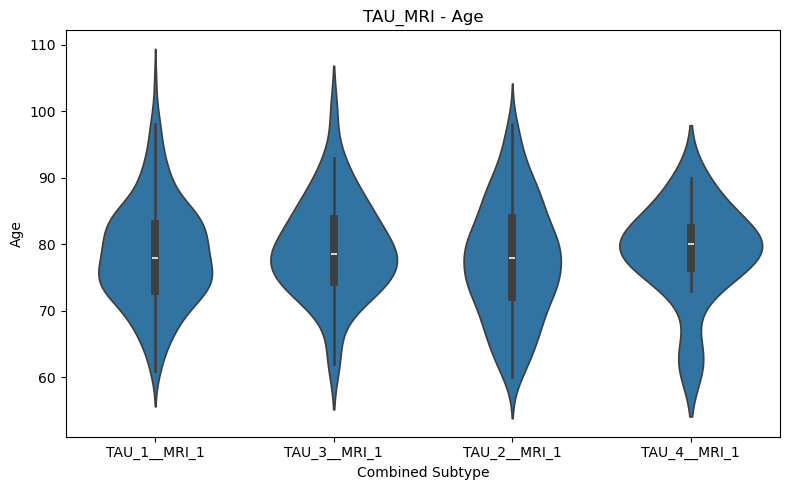


 MMSCORE (Continuous)
  Group sizes: {'TAU_1__MRI_1': 25, 'TAU_2__MRI_1': 25, 'TAU_3__MRI_1': 9, 'TAU_4__MRI_1': 2}
 Small sample size detected in at least one group.
→ Kruskal-Wallis p = 0.0133 | Epsilon² = 0.135

Post hoc pairwise Mann-Whitney U test results (Bonferroni corrected):
                           pair  p_uncorrected  p_bonferroni  significant
0  TAU_1__MRI_1 vs TAU_3__MRI_1       0.001532      0.009194         True


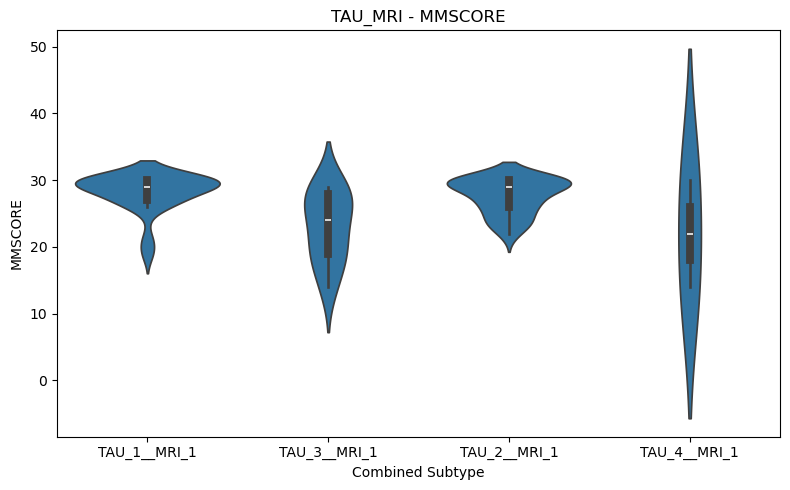


 PTEDUCAT (Continuous)
  Group sizes: {'TAU_1__MRI_1': 207, 'TAU_2__MRI_1': 181, 'TAU_3__MRI_1': 46, 'TAU_4__MRI_1': 19}
→ Kruskal-Wallis p = 0.0130 | Epsilon² = 0.017

Post hoc pairwise Mann-Whitney U test results (Bonferroni corrected):
                           pair  p_uncorrected  p_bonferroni  significant
0  TAU_1__MRI_1 vs TAU_3__MRI_1       0.001568      0.009408         True


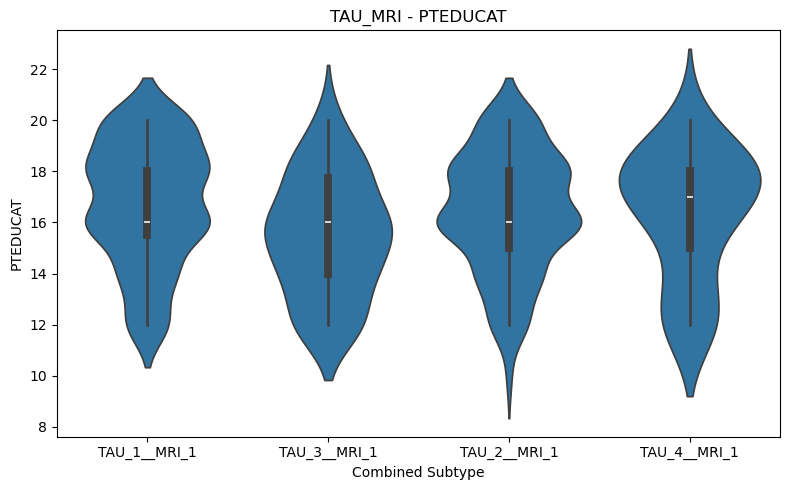


 AGE_RETIRE (Continuous)
  Group sizes: {'TAU_1__MRI_1': 158, 'TAU_2__MRI_1': 141, 'TAU_3__MRI_1': 41, 'TAU_4__MRI_1': 15}
→ Kruskal-Wallis p = 0.6515 | Epsilon² = -0.004


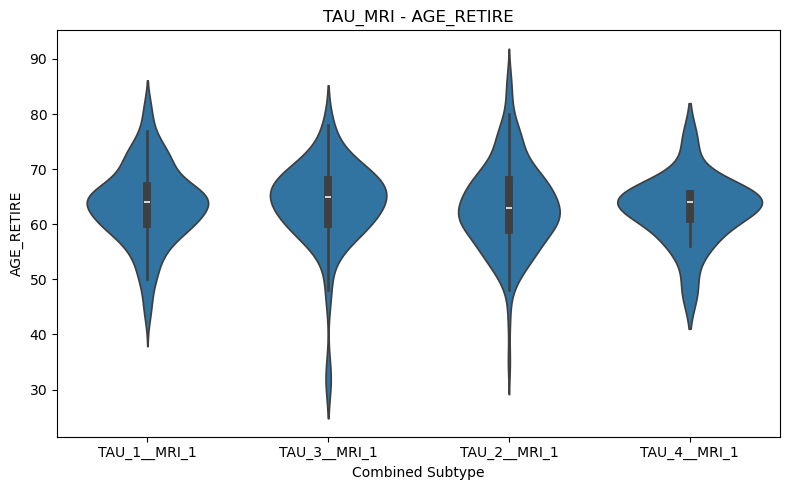


 DIAGNOSIS_STRING (Categorical)
→ Chi-squared p = 0.0000 | Cramér’s V = 0.219

Post hoc (adjusted residuals with Bonferroni correction):
         Subtype DIAGNOSIS_STRING         p     p_adj         direction
6   TAU_3__MRI_1               CN  0.000168  0.002018  Underrepresented
10  TAU_4__MRI_1         Dementia  0.000484  0.005803   Overrepresented
7   TAU_3__MRI_1         Dementia  0.001061  0.012736   Overrepresented


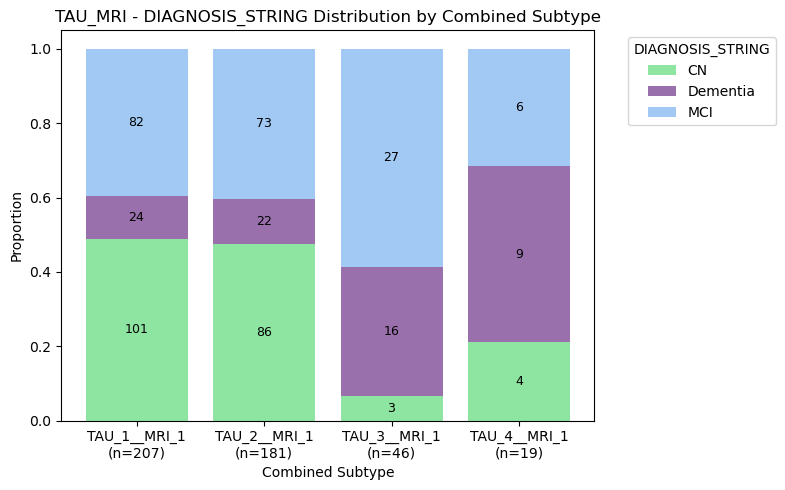


 PTGENDER (Categorical)
→ Chi-squared p = 0.4893 | Cramér’s V = 0.000


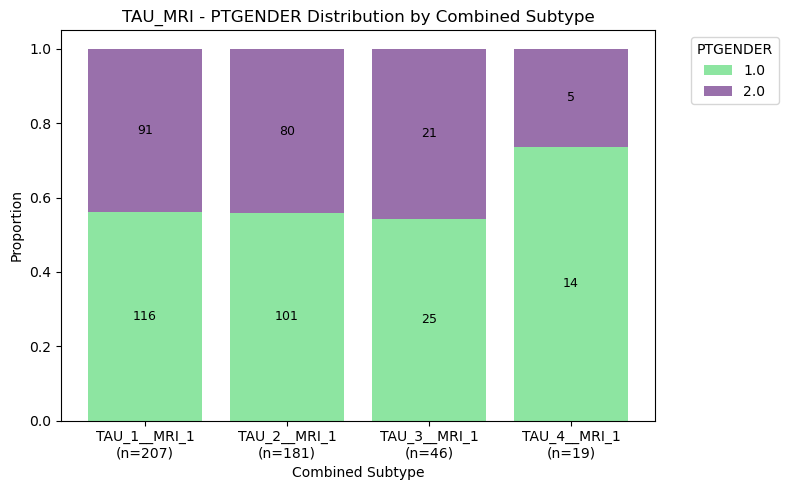


 APOE4 (Categorical)
→ Chi-squared p = 0.0000 | Cramér’s V = 0.173

Post hoc (adjusted residuals with Bonferroni correction):
        Subtype  APOE4         p     p_adj        direction
8  TAU_3__MRI_1    2.0  0.000036  0.000432  Overrepresented


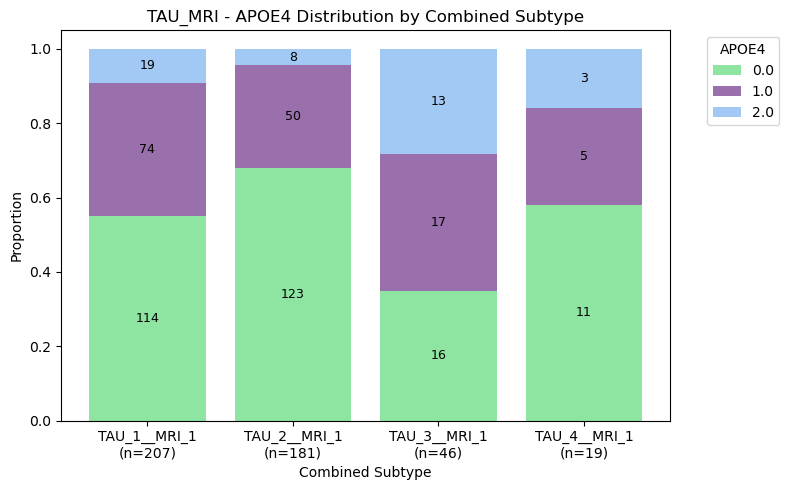



====== AB_MRI Combined Subtype Analysis ======

 AGE (Continuous)
  Group sizes: {'AB_1__MRI_1': 635, 'AB_2__MRI_1': 17}
→ Mann-Whitney U test p = 0.4141


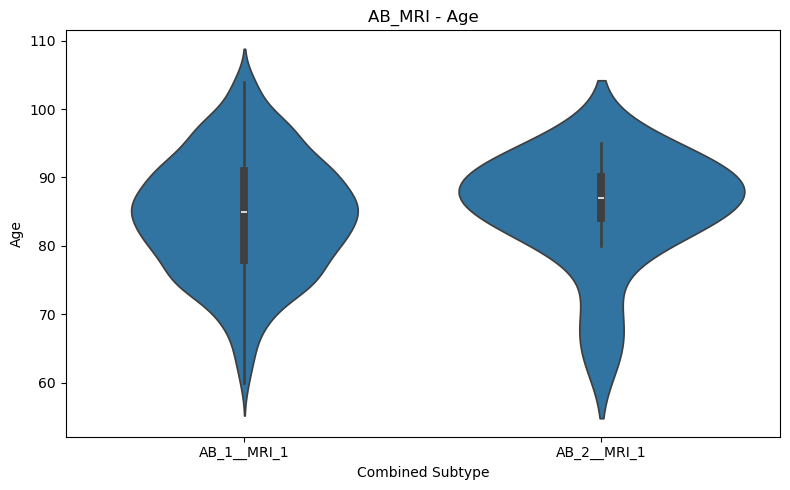


 MMSCORE (Continuous)
  Group sizes: {'AB_1__MRI_1': 91, 'AB_2__MRI_1': 1}
 Small sample size detected in at least one group.
→ Mann-Whitney U test p = 0.3134


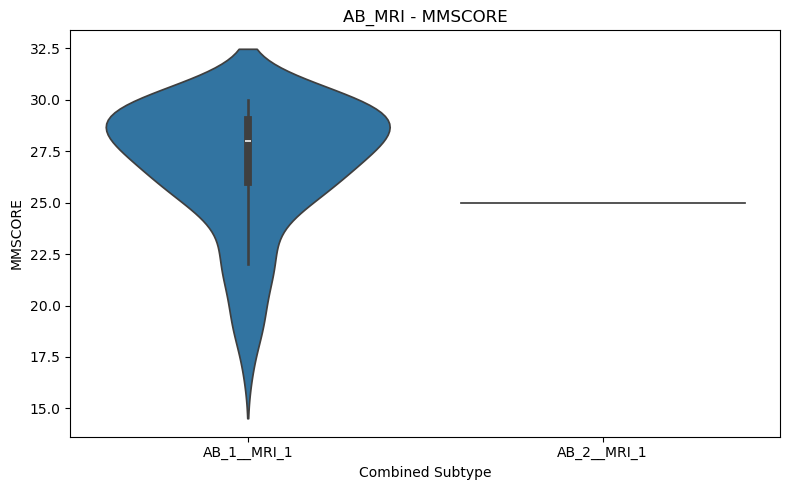


 PTEDUCAT (Continuous)
  Group sizes: {'AB_1__MRI_1': 635, 'AB_2__MRI_1': 17}
→ Mann-Whitney U test p = 0.6659


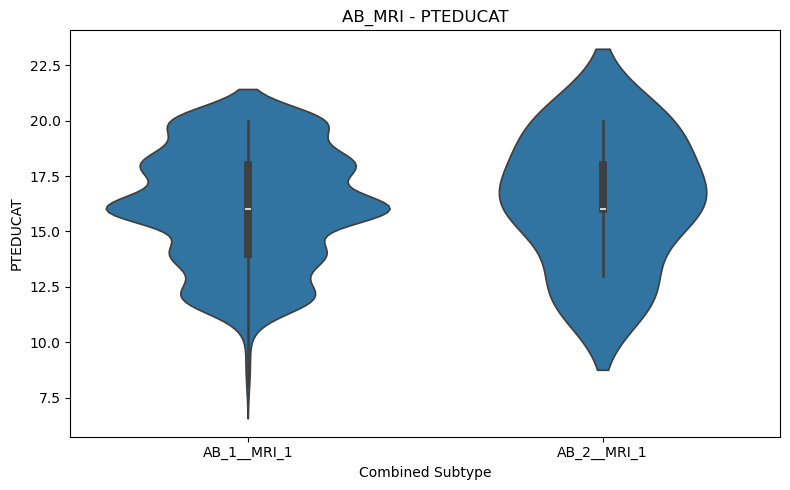


 AGE_RETIRE (Continuous)
  Group sizes: {'AB_1__MRI_1': 505, 'AB_2__MRI_1': 15}
→ Mann-Whitney U test p = 0.5148


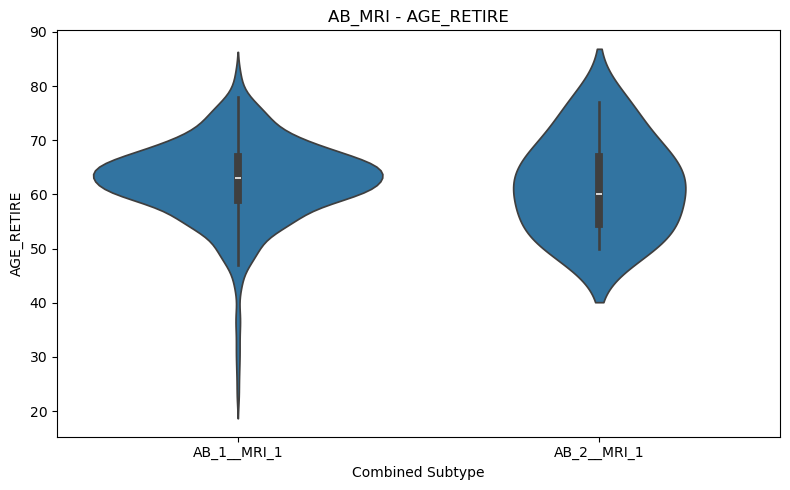


 DIAGNOSIS_STRING (Categorical)
→ Chi-squared p = 0.0000 | Cramér’s V = 0.181

Post hoc (adjusted residuals with Bonferroni correction):
       Subtype DIAGNOSIS_STRING         p     p_adj        direction
4  AB_2__MRI_1         Dementia  0.000021  0.000125  Overrepresented


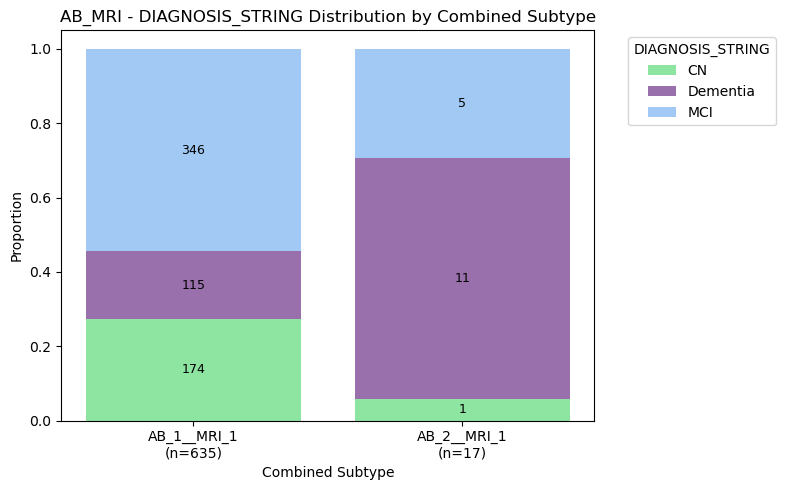


 PTGENDER (Categorical)
→ Chi-squared p = 0.0180 | Cramér’s V = 0.073

Post hoc (adjusted residuals with Bonferroni correction):
No significant residuals after correction.


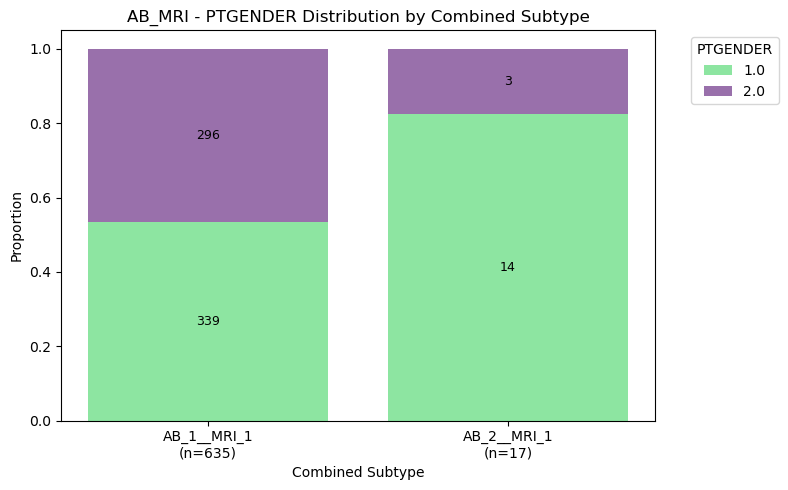


 APOE4 (Categorical)
→ Chi-squared p = 0.3765 | Cramér’s V = 0.000


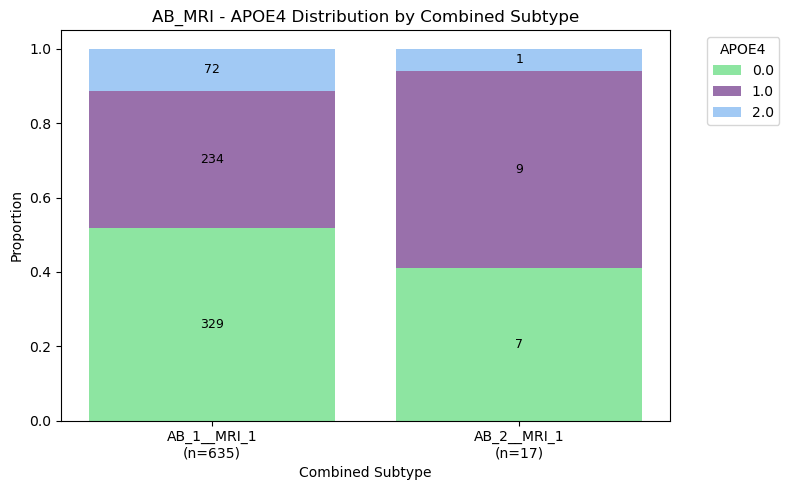

In [27]:
def combined_subtype_analysis(merged_pairs, pair_subtype_cols, continuous_vars, categorical_vars, mmse_score, retire_age):
    colors = ['#8de5a1', '#9970AB', '#a1c9f4']

    for pair_name, df in merged_pairs.items():
        print(f"\n\n====== {pair_name} Combined Subtype Analysis ======")
        sub1_col, sub2_col = pair_subtype_cols[pair_name]

        df = df.copy()
        # Add 1 to subtype labels and convert to int, then to str
        sub1_mod = df[sub1_col].add(1).astype(int).astype(str)
        sub2_mod = df[sub2_col].add(1).astype(int).astype(str)

        # Use modality names in label (e.g., AB1_MRI2)
        modality1 = sub1_col.split('_')[-1]
        modality2 = sub2_col.split('_')[-1]
        df['combined_subtype'] = f"{modality1}_" + sub1_mod + f"__{modality2}_" + sub2_mod

        # Filter out subtypes with fewer than 10 subjects
        subtype_counts = df['combined_subtype'].value_counts()
        valid_subtypes = subtype_counts[subtype_counts >= 10].index.tolist()
        df = df[df['combined_subtype'].isin(valid_subtypes)]
        combined_subtypes = sorted(valid_subtypes)
        k = len(combined_subtypes)

        if k < 2:
            print("Not enough valid subtypes with ≥10 subjects. Skipping this pair.")
            continue

        # CONTINUOUS VARIABLES
        for var in continuous_vars:
            print(f"\n {var.upper()} (Continuous)")
            df_var = df.dropna(subset=[var, 'combined_subtype'])

            if var == mmse_score:
                df_var = df_var[df_var[var] > 0]
            if var == retire_age:
                df_var = df_var[df_var[var] > 0]

            grouped = [df_var[df_var['combined_subtype'] == s][var] for s in combined_subtypes]
            sizes = [len(g) for g in grouped]
            print(f"  Group sizes: {dict(zip(combined_subtypes, sizes))}")
            if any(n < 5 for n in sizes):
                print(" Small sample size detected in at least one group.")

            normal = all(shapiro(g)[1] > 0.05 for g in grouped if len(g) >= 3)

            if k == 2:
                x, y = grouped
                if normal:
                    stat, p = ttest_ind(x, y, equal_var=False)
                    d = cohen_d(x, y)
                    print(f"→ Welch's t-test p = {p:.4f} | Cohen’s d = {d:.3f}")
                else:
                    stat, p = mannwhitneyu(x, y)
                    print(f"→ Mann-Whitney U test p = {p:.4f}")
            else:
                if normal:
                    stat, p = f_oneway(*grouped)
                    df1, df2 = k - 1, len(df_var) - k
                    eta2 = eta_squared(stat, (df1, df2))
                    print(f"→ ANOVA p = {p:.4f} | Eta² = {eta2:.3f}")
                    if p < 0.05:
                        tukey_data = pd.concat([
                            pd.Series(g, name=var).to_frame().assign(subtype=s)
                            for g, s in zip(grouped, combined_subtypes)
                        ])
                        tukey = pairwise_tukeyhsd(tukey_data[var], tukey_data['subtype'])
                        print("\nTukey HSD post hoc results:")
                        print(tukey.summary())
                else:
                    stat, p = kruskal(*grouped)
                    eps2 = epsilon_squared(stat, len(df_var), k)
                    print(f"→ Kruskal-Wallis p = {p:.4f} | Epsilon² = {eps2:.3f}")
                    if p < 0.05:
                        posthoc_results = pairwise_posthoc_mannwhitney(df_var, var, 'combined_subtype')
                        sig_pairs = posthoc_results[posthoc_results['significant']]
                        print("\nPost hoc pairwise Mann-Whitney U test results (Bonferroni corrected):")
                        print(sig_pairs if not sig_pairs.empty else "No significant pairwise differences found.")

            # Plot
            plt.figure(figsize=(8, 5))
            sns.violinplot(x='combined_subtype', y=var, data=df_var)
            plt.title(f'{pair_name} - {var}')
            plt.xlabel("Combined Subtype")
            plt.ylabel(var)
            plt.tight_layout()
            plt.show()

        # CATEGORICAL VARIABLES
        for var in categorical_vars:
            print(f"\n {var.upper()} (Categorical)")
            if df[var].isnull().all():
                print(" Variable missing entirely.")
                continue

            table = pd.crosstab(df['combined_subtype'], df[var])
            chi2, p, _, expected = chi2_contingency(table, correction=False)
            v = cramers_v(table)
            print(f"→ Chi-squared p = {p:.4f} | Cramér’s V = {v:.3f}")

            if p < 0.05:
                print("\nPost hoc (adjusted residuals with Bonferroni correction):")
                residuals = (table - expected) / np.sqrt(expected)
                
                # Flatten residuals to long format
                flattened = residuals.stack().reset_index()
                flattened.columns = ['Subtype', var, 'z']
                
                # Calculate two-sided p-values from z-scores
                flattened['p'] = 2 * (1 - norm.cdf(np.abs(flattened['z'])))
                
                # Bonferroni correction
                flattened['p_adj'] = np.minimum(flattened['p'] * len(flattened), 1.0)
                
                # Significant results only
                sig = flattened[flattened['p_adj'] < 0.05].copy()
                
                if not sig.empty:
                    # Add direction column based on sign of residual (z)
                    sig['direction'] = np.where(sig['z'] > 0, 'Overrepresented', 'Underrepresented')
                    sig = sig.sort_values('p_adj')
                    print(sig[['Subtype', var, 'p', 'p_adj', 'direction']])
                else:
                    print("No significant residuals after correction.")

            # Barplot
            prop_df = table.div(table.sum(1), axis=0)
            subtype_counts = table.sum(axis=1)
            new_labels = [f"{s}\n(n={n})" for s, n in subtype_counts.items()]

            fig, ax = plt.subplots(figsize=(8, 5))
            bottom = np.zeros(len(prop_df))

            for i, category in enumerate(prop_df.columns):
                proportions = prop_df[category].values
                counts = table[category].values
                bars = ax.bar(
                    x=np.arange(len(prop_df)),
                    height=proportions,
                    bottom=bottom,
                    label=category,
                    color=colors[i % len(colors)]
                )

                # Add counts
                for j, bar in enumerate(bars):
                    count = counts[j]
                    if count > 0:
                        ax.text(
                            bar.get_x() + bar.get_width() / 2,
                            bar.get_y() + bar.get_height() / 2,
                            f'{int(count)}',
                            ha='center', va='center',
                            fontsize=9,
                            color='black'
                        )
                bottom += proportions

            ax.set_title(f'{pair_name} - {var} Distribution by Combined Subtype')
            ax.set_ylabel("Proportion")
            ax.set_xlabel("Combined Subtype")
            ax.set_xticks(range(len(new_labels)))
            ax.set_xticklabels(new_labels)
            ax.legend(title=var, bbox_to_anchor=(1.05, 1))
            plt.tight_layout()
            plt.show()



# === Usage example ===
merged_pairs = {
    'AB_TAU': merged_ab_tau,
    'TAU_MRI': merged_tau_mri,
    'AB_MRI': merged_ab_mri
}
# Define subtype columns per pair
pair_subtype_cols = {
    'AB_TAU': ('ml_subtype_AB', 'ml_subtype_TAU'),
    'TAU_MRI': ('ml_subtype_TAU', 'ml_subtype_MRI'),
    'AB_MRI': ('ml_subtype_AB', 'ml_subtype_MRI')
}


#Call function:
combined_subtype_analysis(merged_pairs, pair_subtype_cols, continuous_vars, categorical_vars, mmse_score, retire_age)


/var/folders/nl/7qp9kcyn5c965d6fjctkjyd00000gn/T/ipykernel_22681/2307484250.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(groups[0], groups[1], equal_var=False)
/opt/anaconda3/envs/sustain_env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/opt/anaconda3/envs/sustain_env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


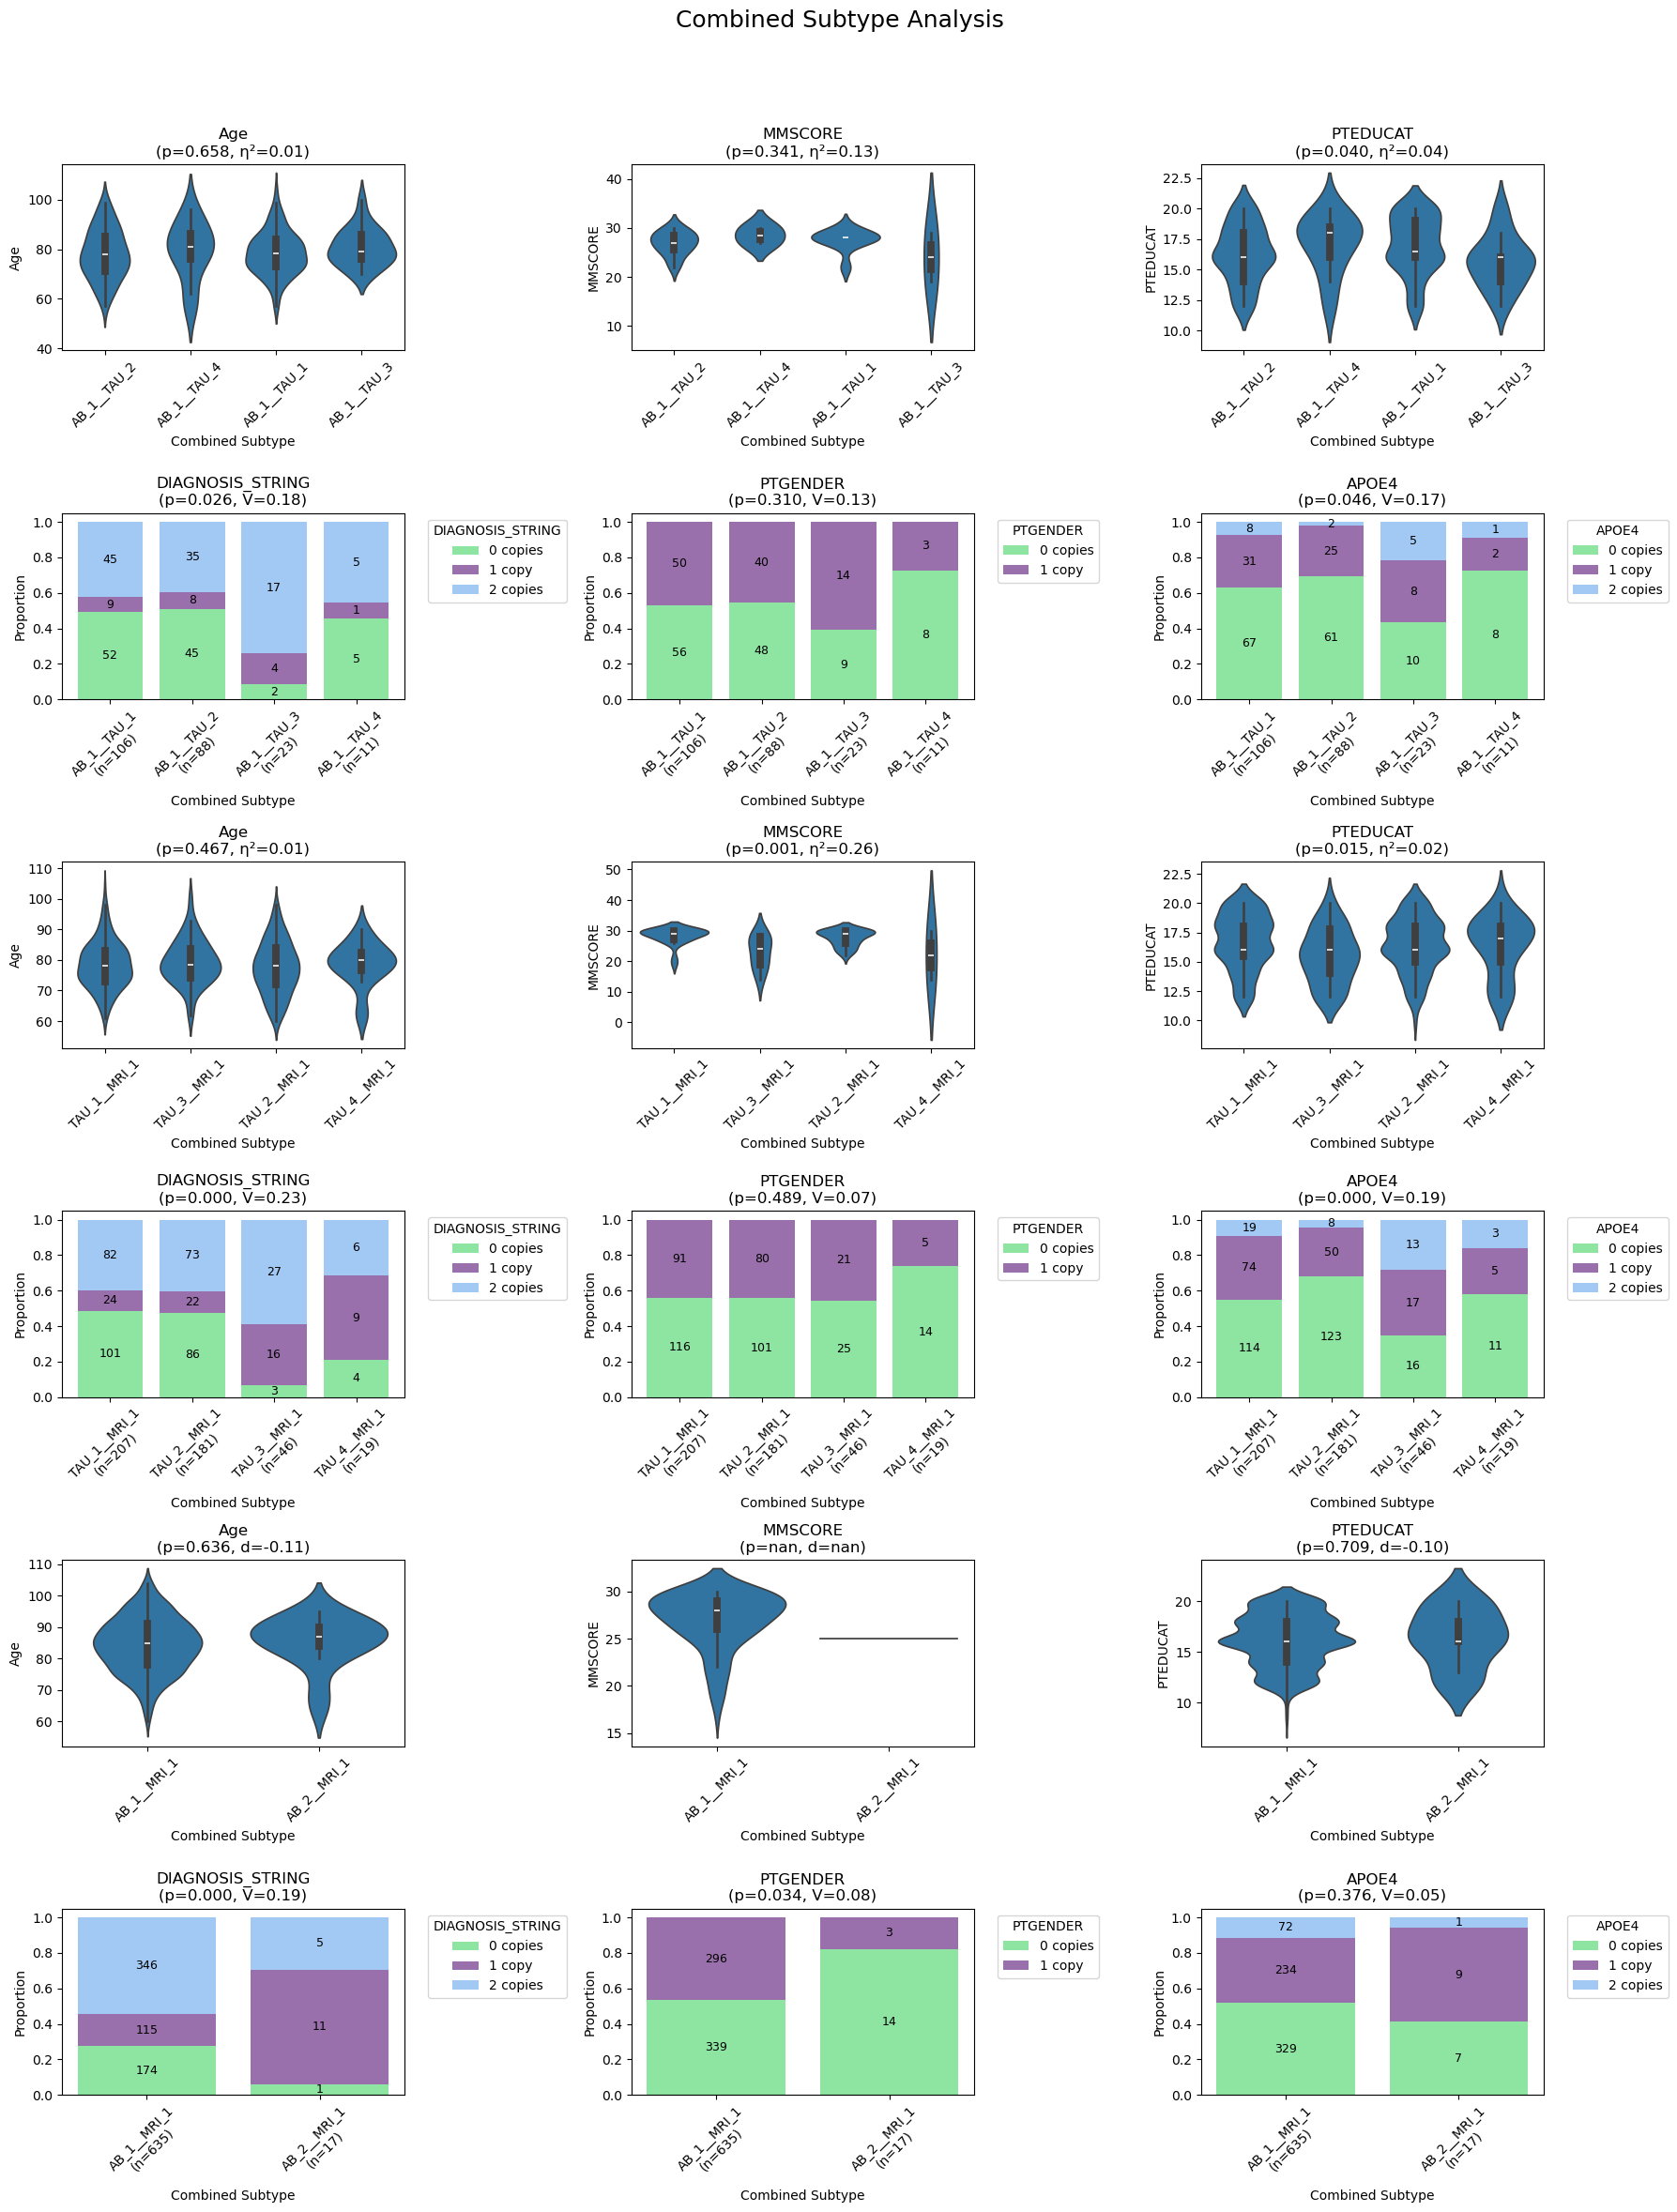

In [86]:
# --- Settings ---
colors = ['#8de5a1', '#9970AB', '#a1c9f4']  # Custom colors
labels = ['0 copies', '1 copy', '2 copies']  # Custom labels

merged_pairs = {
    'AB_TAU': merged_ab_tau,   
    'TAU_MRI': merged_tau_mri,
    'AB_MRI': merged_ab_mri
}

pair_subtype_cols = {
    'AB_TAU': ('ml_subtype_AB', 'ml_subtype_TAU'),
    'TAU_MRI': ('ml_subtype_TAU', 'ml_subtype_MRI'),
    'AB_MRI': ('ml_subtype_AB', 'ml_subtype_MRI')
}

# --- Figure setup ---
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(18, 24))  # 3 per row, 6 rows
axes = axes.flatten()  # Flatten to 1D array for linear indexing
ax_idx = 0  # Counter for current axis

for pair_name, df in merged_pairs.items():
    sub1_col, sub2_col = pair_subtype_cols[pair_name]
    df = df.copy()
    
    # Convert subtypes to strings
    sub1_mod = df[sub1_col].add(1).astype(int).astype(str)
    sub2_mod = df[sub2_col].add(1).astype(int).astype(str)
    modality1 = sub1_col.split('_')[-1]
    modality2 = sub2_col.split('_')[-1]
    df['combined_subtype'] = f"{modality1}_" + sub1_mod + f"__{modality2}_" + sub2_mod

    # Filter subtypes with >=10 subjects
    subtype_counts = df['combined_subtype'].value_counts()
    valid_subtypes = subtype_counts[subtype_counts >= 10].index.tolist()
    df = df[df['combined_subtype'].isin(valid_subtypes)]
    combined_subtypes = sorted(valid_subtypes)
    if len(combined_subtypes) < 2:
        print(f"Not enough valid subtypes for {pair_name}. Skipping.")
        continue

    # --- Continuous variables ---
    for var in continuous_vars:
        if ax_idx >= len(axes):
            break
        ax = axes[ax_idx]
        ax_idx += 1

        df_var = df.dropna(subset=[var, 'combined_subtype'])
        if var.lower() == mmse_score:
            df_var = df_var[df_var[var] > 0]  # Exclude zero MMSE if needed

        groups = [df_var[df_var['combined_subtype'] == s][var] for s in combined_subtypes]
        if len(groups) == 2:
            diff = groups[0].mean() - groups[1].mean()
            pooled_sd = np.sqrt((groups[0].var() + groups[1].var()) / 2)
            d = diff / pooled_sd
            t_stat, p_val = stats.ttest_ind(groups[0], groups[1], equal_var=False)
            title = f"{var}\n(p={p_val:.3f}, d={d:.2f})"
        else:
            f_stat, p_val = stats.f_oneway(*groups)
            ss_between = sum([len(g)*(g.mean() - df_var[var].mean())**2 for g in groups])
            ss_total = sum((df_var[var] - df_var[var].mean())**2)
            eta2 = ss_between / ss_total
            title = f"{var}\n(p={p_val:.3f}, η²={eta2:.2f})"

        sns.violinplot(x='combined_subtype', y=var, data=df_var, ax=ax)
        ax.set_title(title)
        ax.set_xlabel("Combined Subtype")
        ax.set_ylabel(var)
        ax.tick_params(axis='x', rotation=45)

    # --- Categorical variables ---
    for var in categorical_vars:
        if ax_idx >= len(axes):
            break
        ax = axes[ax_idx]
        ax_idx += 1

        if df[var].isnull().all():
            ax.axis('off')
            continue

        table = pd.crosstab(df['combined_subtype'], df[var])
        prop_df = table.div(table.sum(1), axis=0)
        subtype_counts = table.sum(axis=1)
        new_labels = [f"{s}\n(n={n})" for s, n in subtype_counts.items()]

        chi2, p, dof, expected = stats.chi2_contingency(table)
        n_total = table.sum().sum()
        cramers_v = np.sqrt(chi2 / (n_total * (min(table.shape)-1)))
        title = f"{var}\n(p={p:.3f}, V={cramers_v:.2f})"

        bottom = np.zeros(len(prop_df))
        for j, category in enumerate(prop_df.columns):
            proportions = prop_df[category].values
            counts = table[category].values
            bars = ax.bar(np.arange(len(prop_df)), proportions, bottom=bottom,
                          label=labels[j % len(labels)], color=colors[j % len(colors)])
            for k_idx, bar in enumerate(bars):
                count = counts[k_idx]
                if count > 0:
                    ax.text(bar.get_x() + bar.get_width()/2,
                            bar.get_y() + bar.get_height()/2,
                            f'{int(count)}', ha='center', va='center', fontsize=9)
            bottom += proportions

        ax.set_title(title)
        ax.set_xticks(range(len(new_labels)))
        ax.set_xticklabels(new_labels, rotation=45)
        ax.set_ylabel("Proportion")
        ax.set_xlabel("Combined Subtype")
        ax.legend(title=var, bbox_to_anchor=(1.05, 1))

# Hide any unused axes
for i in range(ax_idx, len(axes)):
    axes[i].axis('off')

plt.suptitle('Combined Subtype Analysis', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('combined_subtype_analysis.png', dpi=300, bbox_inches='tight')
plt.show()



In [38]:
# AB + TAU subtypes

summary = (merged_ab_tau.groupby(['ml_subtype_AB', 'ml_subtype_TAU'])[[diagnosis_num, age, mmse_score, apoe4, educ, gender, retire_age]].describe().unstack())

# To display fewer decimal places (optional)
pd.options.display.float_format = '{:.2f}'.format
print(summary)



               DIAGNOSIS                                                  ...  \
                   count                   mean                 std       ...   
ml_subtype_TAU      0.00  1.00  2.00  3.00 0.00 1.00 2.00 3.00 0.00 1.00  ...   
ml_subtype_AB                                                             ...   
0.00              106.00 88.00 23.00 11.00 1.59 1.58 2.09 1.64 0.64 0.66  ...   
1.00                 NaN  6.00   NaN  1.00  NaN 2.33  NaN 3.00  NaN 0.82  ...   

               AGE_RETIRE                                                  \
                      50%         75%                     max               
ml_subtype_TAU       2.00  3.00  0.00  1.00  2.00  3.00  0.00  1.00  2.00   
ml_subtype_AB                                                               
0.00                64.00 63.00 65.00 66.00 68.00 65.00 86.00 82.00 71.00   
1.00                  NaN 75.00   NaN 66.00   NaN 75.00   NaN 77.00   NaN   

                      
                      
ml_s

In [42]:
# TAU + MRI subtypes

summary = (merged_tau_mri.groupby(['ml_subtype_TAU', 'ml_subtype_MRI'])[[diagnosis_num, age, mmse_score, apoe4, educ, gender, retire_age]].describe().unstack())

# To display fewer decimal places (optional)
pd.options.display.float_format = '{:.2f}'.format
print(summary)



               DIAGNOSIS                                               ...  \
                   count                mean                 std       ...   
ml_subtype_MRI      0.00 1.00 2.00 3.00 0.00 1.00 2.00 3.00 0.00 1.00  ...   
ml_subtype_TAU                                                         ...   
0.00              207.00 2.00 5.00 1.00 1.63 1.50 1.20 3.00 0.68 0.71  ...   
1.00              181.00 4.00 1.00 2.00 1.65 2.50 2.00 1.50 0.69 0.58  ...   
2.00               46.00  NaN 1.00  NaN 2.28  NaN 3.00  NaN 0.58  NaN  ...   
3.00               19.00  NaN  NaN  NaN 2.26  NaN  NaN  NaN 0.81  NaN  ...   

               AGE_RETIRE                                                  \
                      50%         75%                     max               
ml_subtype_MRI       2.00  3.00  0.00  1.00  2.00  3.00  0.00  1.00  2.00   
ml_subtype_TAU                                                              
0.00                63.00 58.00 66.00 58.25 65.00 58.00 81.00 59.00

In [40]:
# AB + MRI subtypes

summary = (merged_ab_mri.groupby(['ml_subtype_AB', 'ml_subtype_MRI'])[[diagnosis_num, age, mmse_score, apoe4, educ, gender, retire_age]].describe().unstack())

# To display fewer decimal places (optional)
pd.options.display.float_format = '{:.2f}'.format
print(summary)



               DIAGNOSIS                                               ...  \
                   count                mean                 std       ...   
ml_subtype_MRI      0.00 1.00 2.00 3.00 0.00 1.00 2.00 3.00 0.00 1.00  ...   
ml_subtype_AB                                                          ...   
0.00              635.00 4.00 4.00 1.00 1.91 2.25 1.25 1.00 0.67 0.50  ...   
1.00               17.00 1.00  NaN 1.00 2.59 3.00  NaN 3.00 0.62  NaN  ...   

               AGE_RETIRE                                                  \
                      50%         75%                     max               
ml_subtype_MRI       2.00  3.00  0.00  1.00  2.00  3.00  0.00  1.00  2.00   
ml_subtype_AB                                                               
0.00                31.00  0.00 66.00 63.50 62.25  0.00 82.00 65.00 63.00   
1.00                  NaN 69.00 67.00 60.00   NaN 69.00 77.00 60.00   NaN   

                      
                      
ml_subtype_MRI  3.00  


======= Plotting for AB_MRI Subtype Combinations =======



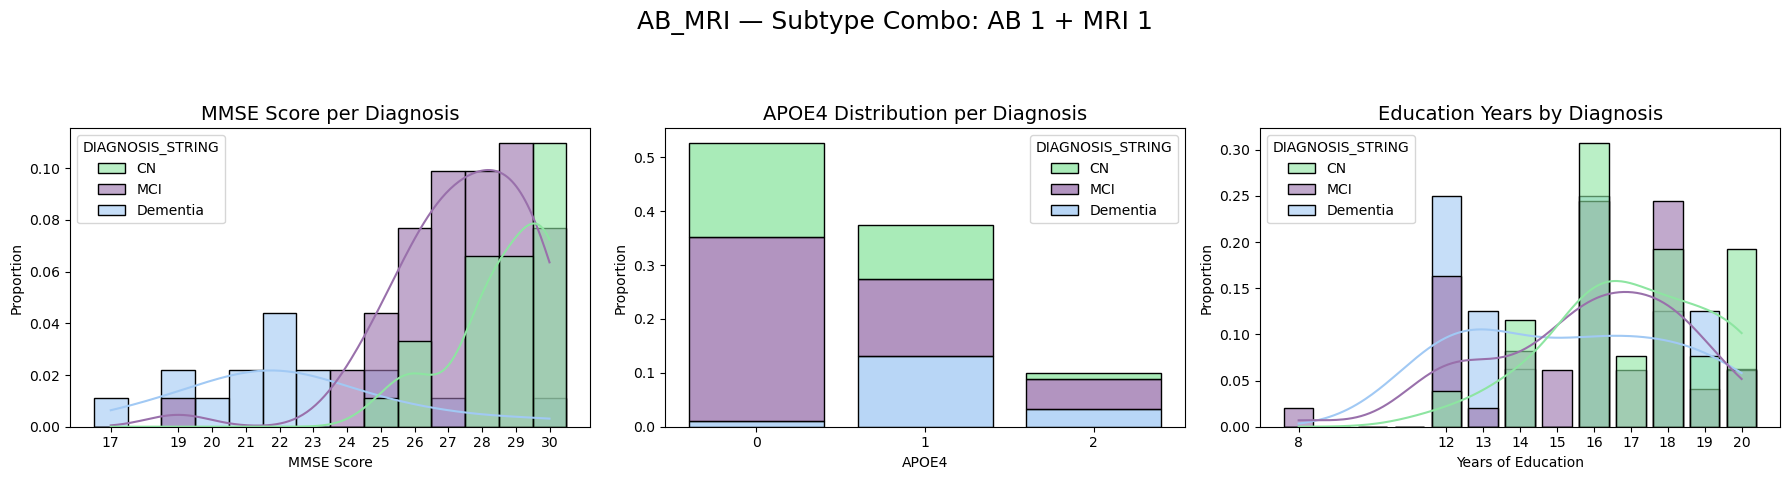


======= Plotting for TAU_MRI Subtype Combinations =======



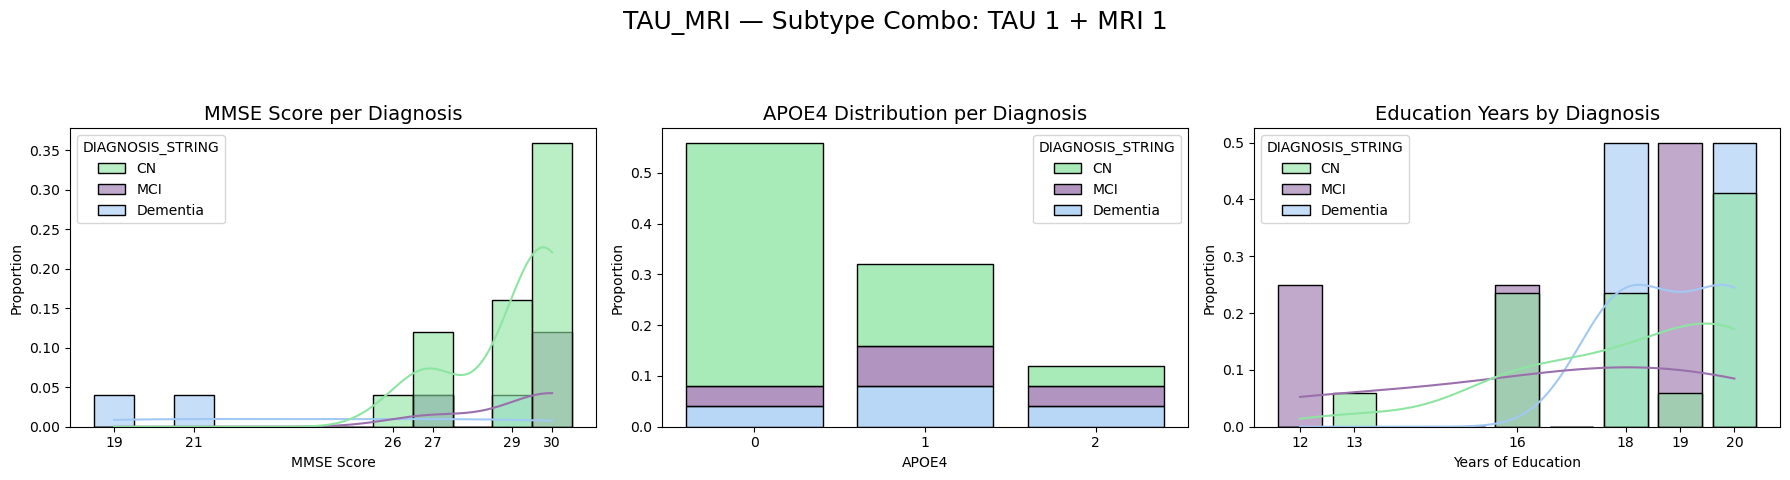

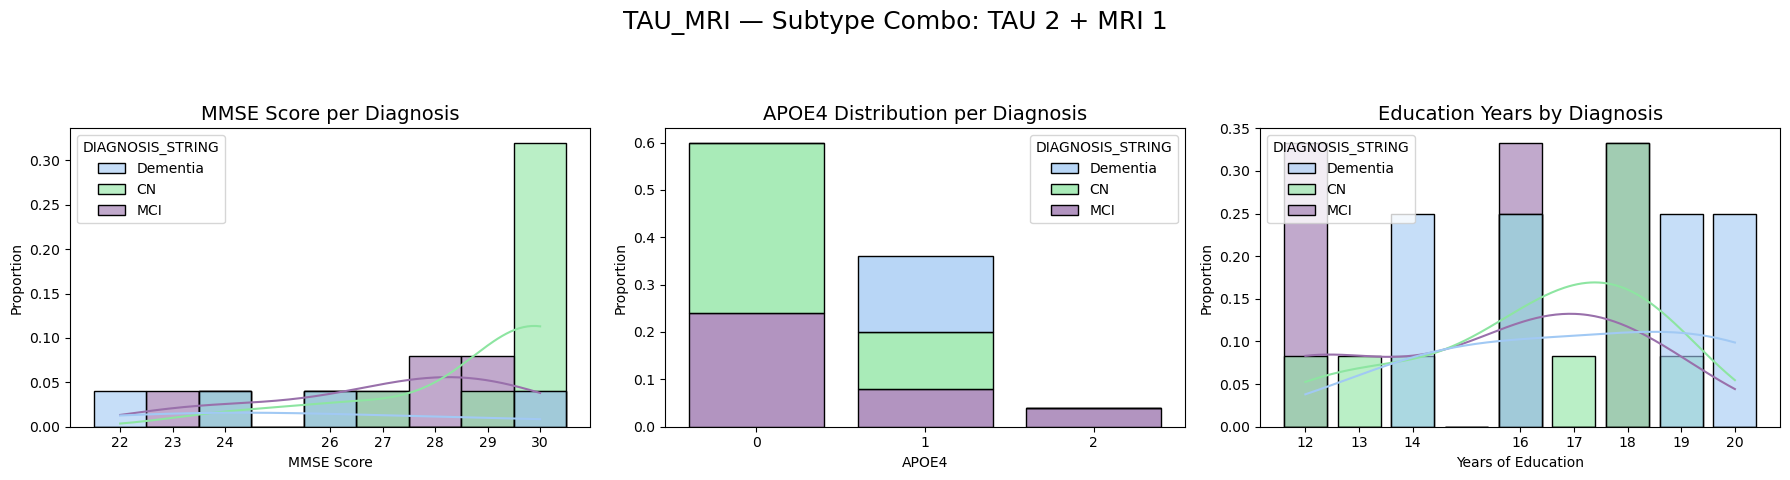


======= Plotting for AB_TAU Subtype Combinations =======



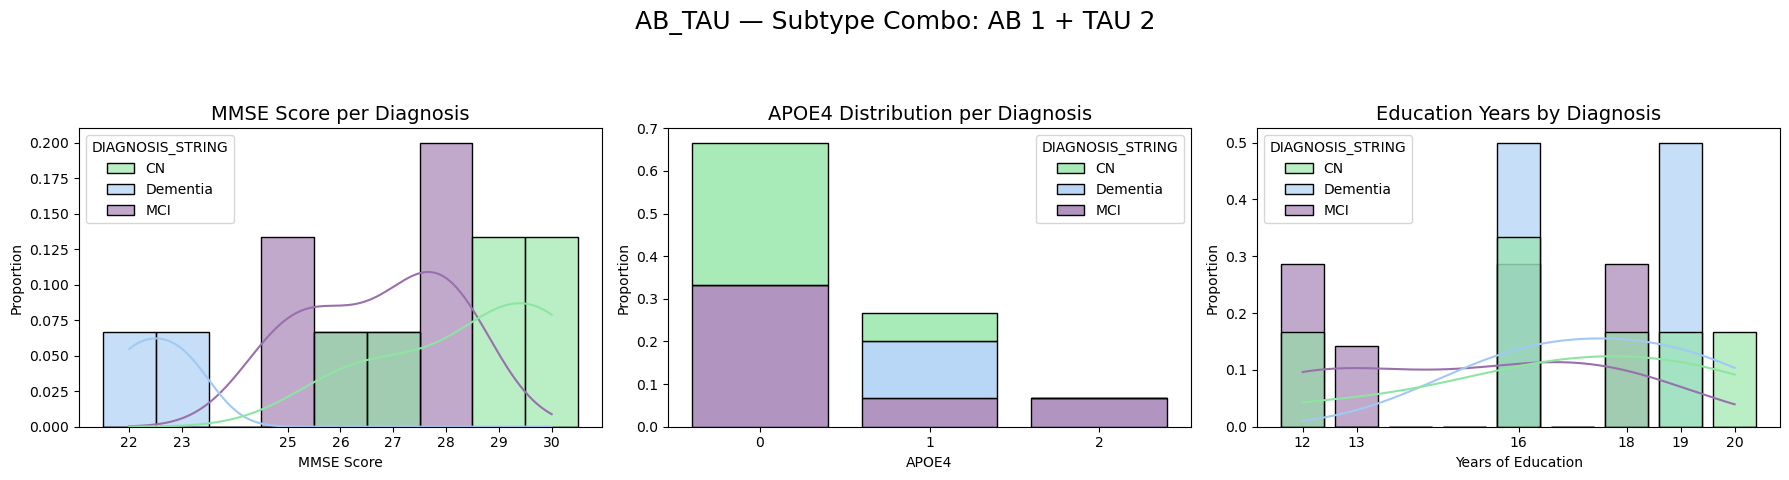

In [31]:
# Dictionary: (dataset, modality1 subtype, modality2 subtype, label)
merged_sets = {
    "AB_MRI": (merged_ab_mri, "ml_subtype_AB", "ml_subtype_MRI"),
    "TAU_MRI": (merged_tau_mri, "ml_subtype_TAU", "ml_subtype_MRI"),
    "AB_TAU": (merged_ab_tau, "ml_subtype_AB", "ml_subtype_TAU"),
}

diagnosis_palette = {
    'CN': '#8de5a1',       
    'MCI': '#9970AB',      
    'Dementia': '#a1c9f4'  
}


for name, (df, subtype1, subtype2) in merged_sets.items():
    print(f"\n======= Plotting for {name} Subtype Combinations =======\n")

    # Filter MMSE > 0
    df = df[df[mmse_score] > 0]

    for sub1 in sorted(df[subtype1].dropna().unique()):
        for sub2 in sorted(df[subtype2].dropna().unique()):
            subset_df = df[(df[subtype1] == sub1) & (df[subtype2] == sub2)]

            if len(subset_df) < 10:
                continue  # Skip small groups

            fig, axs = plt.subplots(1, 3, figsize=(18, 5))
            fig.suptitle(f"{name} — Subtype Combo: {subtype1.split('_')[-1]} {int(sub1)+1} + {subtype2.split('_')[-1]} {int(sub2)+1}", fontsize=18)
            plt.subplots_adjust(wspace=0.3)

            # MMSE
            sns.histplot(data=subset_df, x=mmse_score, hue=dx, kde=True, multiple="layer", palette=diagnosis_palette,
                         alpha=0.6, ax=axs[0], stat="probability", discrete=True)
            axs[0].set_title("MMSE Score per Diagnosis", fontsize=14)
            axs[0].set_xlabel("MMSE Score")
            axs[0].set_ylabel("Proportion")
            axs[0].set_xticks(sorted(subset_df[mmse_score].dropna().unique()))

            # APOE4
            sns.histplot(data=subset_df, x=apoe4, hue=dx, multiple="stack", palette=diagnosis_palette,
                         ax=axs[1], stat="probability", discrete=True, shrink=0.8)
            axs[1].set_title("APOE4 Distribution per Diagnosis", fontsize=14)
            axs[1].set_xlabel("APOE4")
            axs[1].set_ylabel("Proportion")
            axs[1].set_xticks(sorted(subset_df[apoe4].dropna().unique()))

            # Education
            sns.histplot(data=subset_df, x=educ, hue=dx, kde=True, multiple="layer", palette=diagnosis_palette,
                         alpha=0.6, ax=axs[2], stat="probability", common_norm=False,
                         discrete=True, shrink=0.8)
            axs[2].set_title("Education Years by Diagnosis", fontsize=14)
            axs[2].set_xlabel("Years of Education")
            axs[2].set_ylabel("Proportion")
            axs[2].set_xticks(sorted(subset_df[educ].dropna().unique()))

            plt.tight_layout(rect=[0, 0.03, 1, 0.90])
            plt.show()



======= Gender Representation in AB_MRI Combined Subtypes (Proportional to Overall) =======


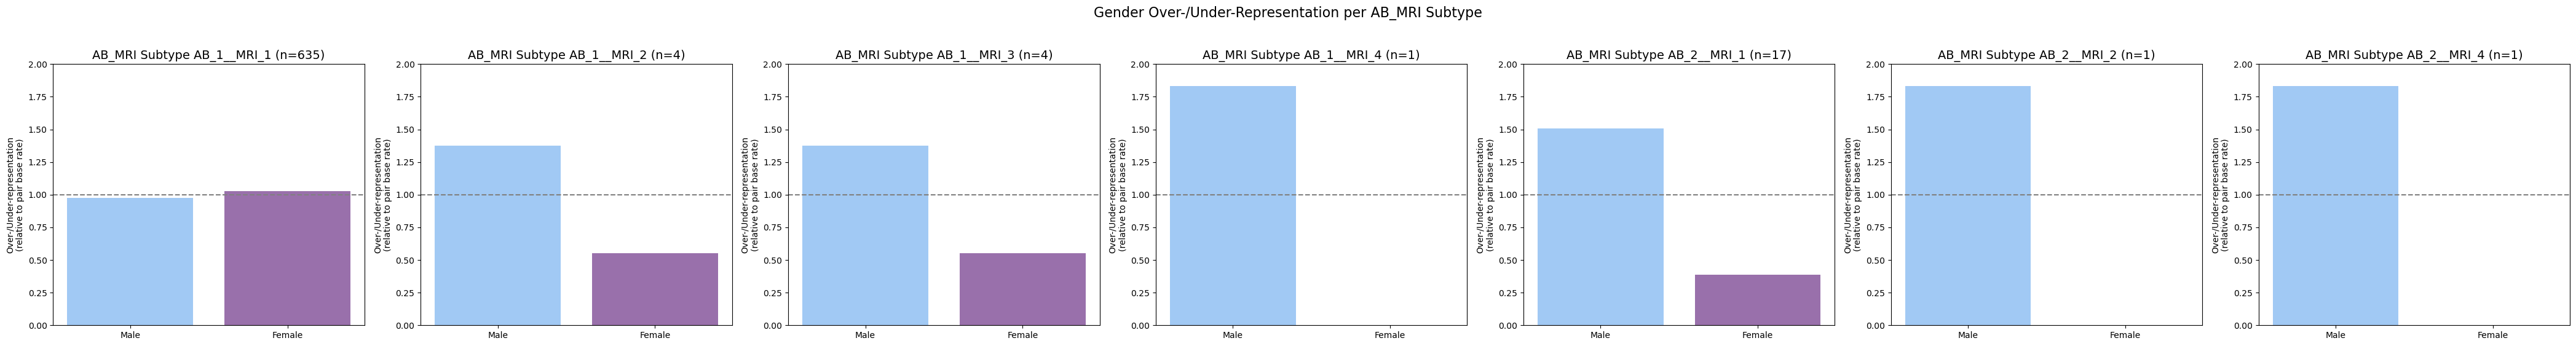


======= Gender Representation in AB_TAU Combined Subtypes (Proportional to Overall) =======


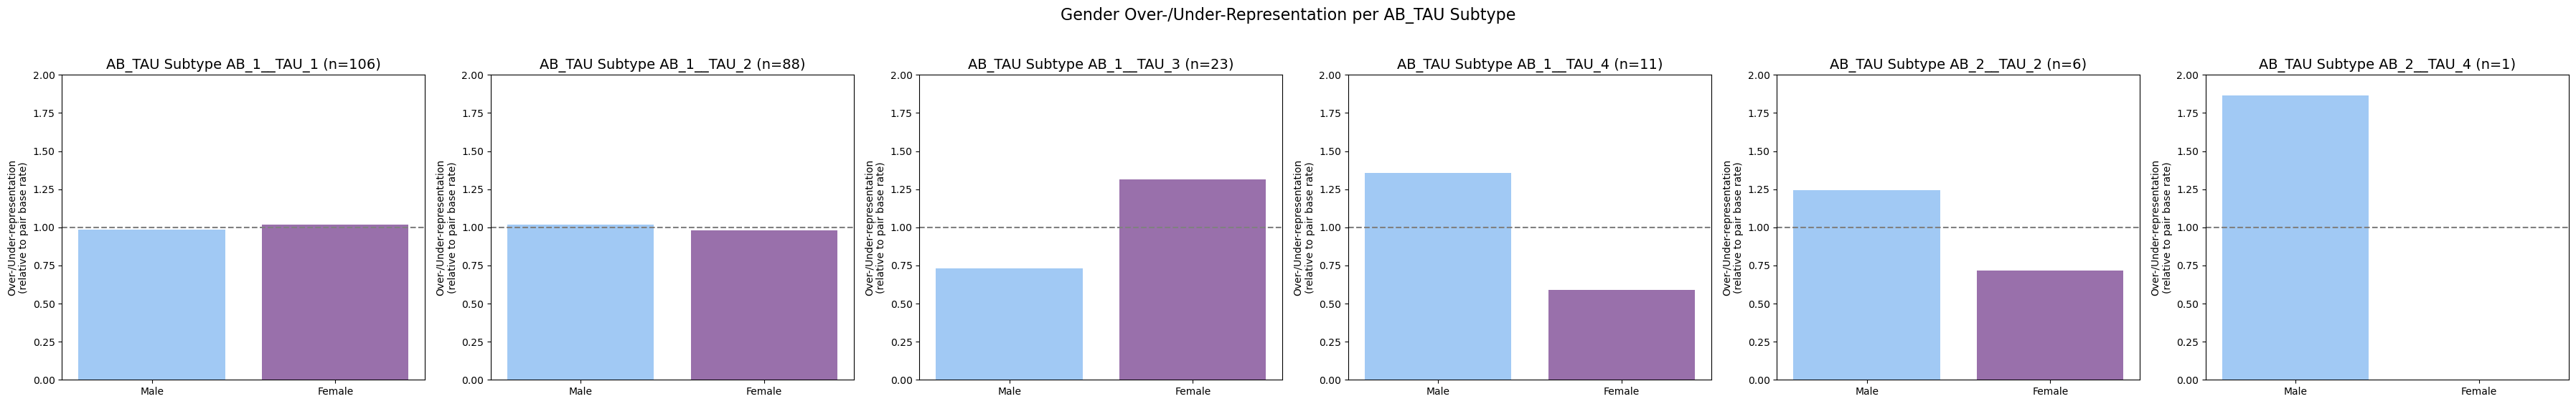


======= Gender Representation in TAU_MRI Combined Subtypes (Proportional to Overall) =======


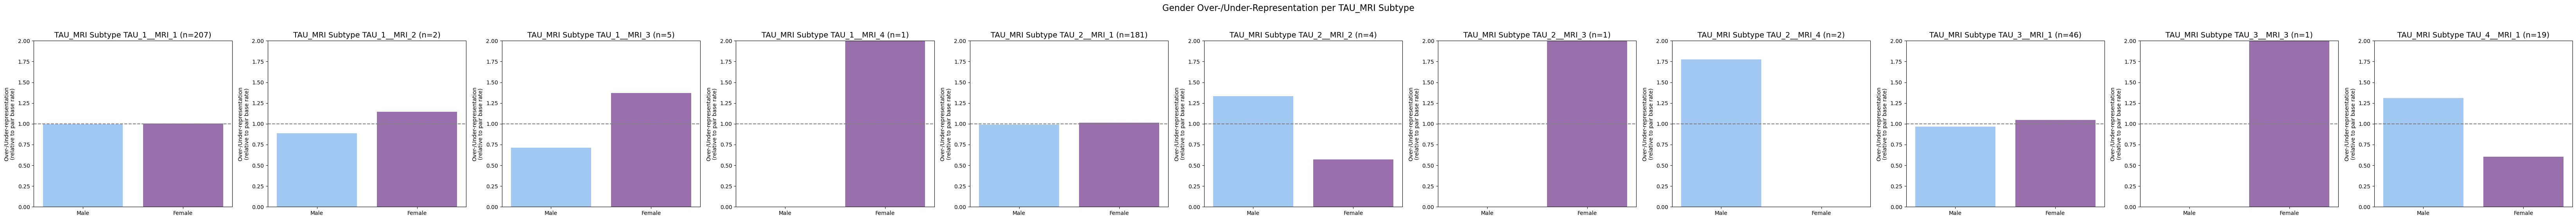

In [32]:
# Gender map: 1 = Male, 2 = Female
gender_map = {1.0: 'Male', 2.0: 'Female'}
gender_order = ['Male', 'Female']
gender_colors = ['#a1c9f4', '#9970AB']  # Blue for Male, Red for Female

# Merged pairs: dataframe, subtype cols, stage col
merged_pairs = {
    'AB_MRI': (merged_ab_mri, 'ml_subtype_AB', 'ml_subtype_MRI'),
    'AB_TAU': (merged_ab_tau, 'ml_subtype_AB', 'ml_subtype_TAU'),
    'TAU_MRI': (merged_tau_mri, 'ml_subtype_TAU', 'ml_subtype_MRI')
}

for pair_name, (df, sub1_col, sub2_col) in merged_pairs.items():
    print(f"\n======= Gender Representation in {pair_name} Combined Subtypes (Proportional to Overall) =======")
    
    df = df.copy()
    df['GenderStr'] = df[gender].map(gender_map)
    # Add 1 to subtype labels and convert to int, then to str
    sub1_mod = df[sub1_col].add(1).astype(int).astype(str)
    sub2_mod = df[sub2_col].add(1).astype(int).astype(str)
    # Use modality names in label (e.g., AB1_MRI2)
    modality1 = sub1_col.split('_')[-1]
    modality2 = sub2_col.split('_')[-1]
    df['combined_subtype'] = f"{modality1}_" + sub1_mod + f"__{modality2}_" + sub2_mod


    # Drop missing genders
    df = df.dropna(subset=['GenderStr', 'combined_subtype'])

    # Overall gender base rates
    overall_counts = df['GenderStr'].value_counts()
    overall_total = overall_counts.sum()
    overall_props = overall_counts / overall_total

    unique_subtypes = sorted(df['combined_subtype'].unique())
    n_subtypes = len(unique_subtypes)
    fig, axs = plt.subplots(1, n_subtypes, figsize=(6 * n_subtypes, 6))
    if n_subtypes == 1:
        axs = [axs]

    for i, subtype in enumerate(unique_subtypes):
        subset_df = df[df['combined_subtype'] == subtype]
        gender_counts = subset_df['GenderStr'].value_counts()
        total = gender_counts.sum()

        # Proportion relative to overall (normalized)
        normalized_props = (gender_counts / total) / overall_props

        # Ensure consistent gender order
        normalized_props = normalized_props.reindex(gender_order).fillna(0)

        axs[i].bar(gender_order, normalized_props.values, color=gender_colors)
        axs[i].set_ylim(0, 2)
        axs[i].axhline(1.0, color='gray', linestyle='--')
        axs[i].set_title(f"{pair_name} Subtype {subtype} (n={total})", fontsize=14)
        axs[i].set_ylabel("Over-/Under-representation\n(relative to pair base rate)")

    plt.suptitle(f"Gender Over-/Under-Representation per {pair_name} Subtype", fontsize=16)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()



======= APOE4 Representation in AB_MRI Combined Subtypes (Proportional to Overall) =======


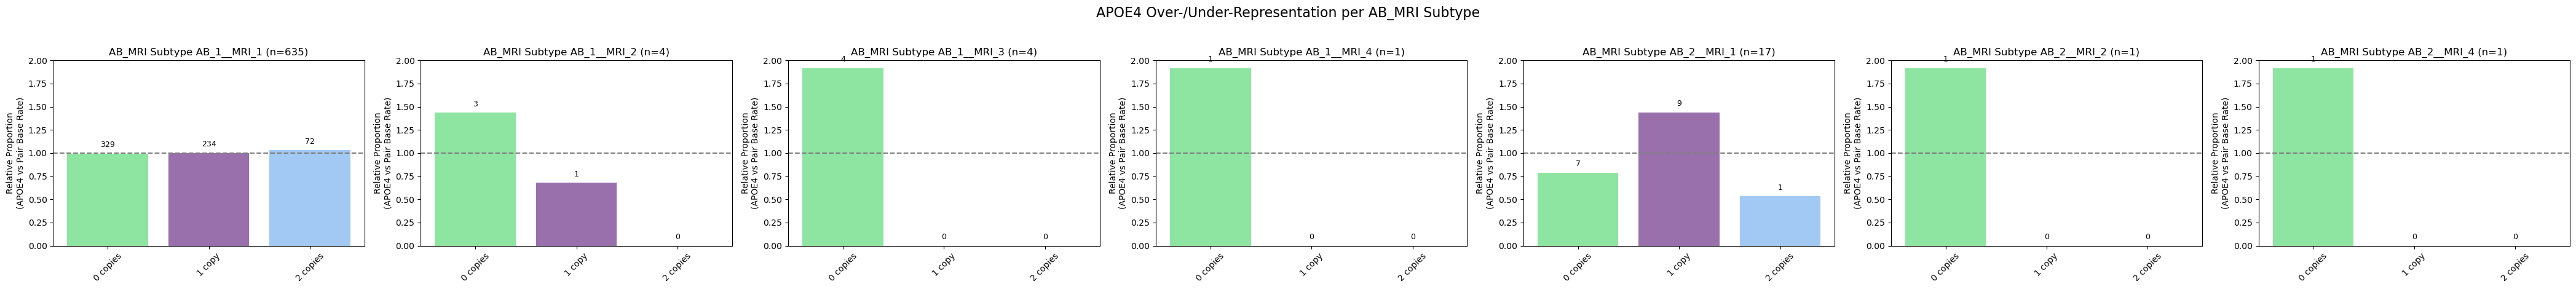


======= APOE4 Representation in AB_TAU Combined Subtypes (Proportional to Overall) =======


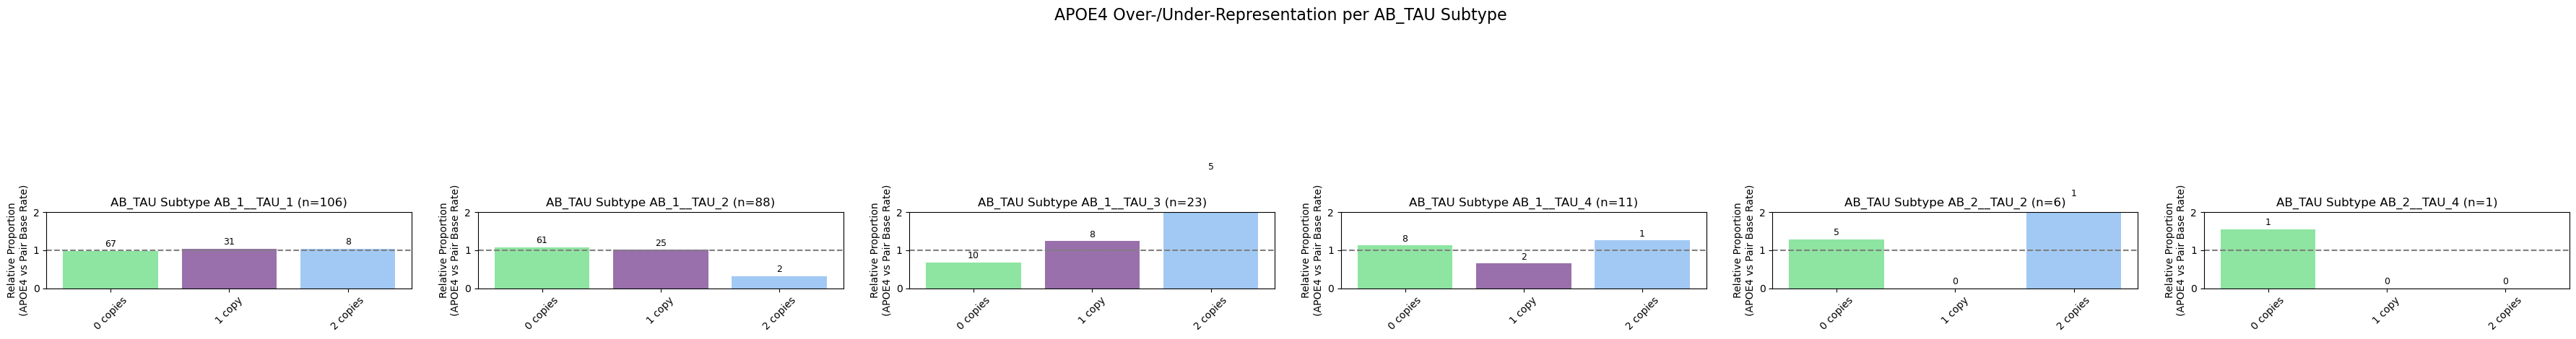


======= APOE4 Representation in TAU_MRI Combined Subtypes (Proportional to Overall) =======


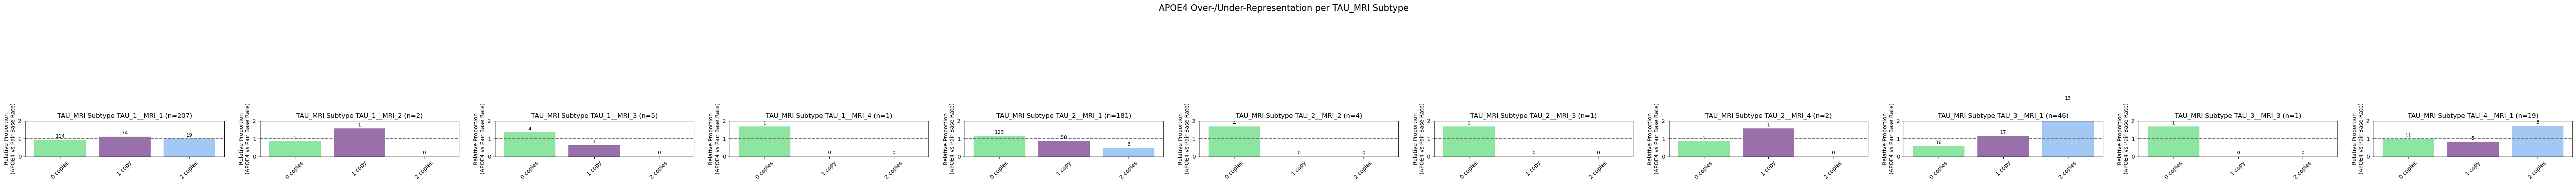

In [33]:
# APOE4 allele count plots for combined subtypes (e.g., AB-MRI, AB-TAU, TAU-MRI)
colors = ['#8de5a1', '#9970AB', '#a1c9f4']   # 0, 1, 2 copies
labels = ['0 copies', '1 copy', '2 copies']
allele_order = [0, 1, 2]

for pair_name, (df, sub1_col, sub2_col) in merged_pairs.items():
    print(f"\n======= APOE4 Representation in {pair_name} Combined Subtypes (Proportional to Overall) =======")
    
    df = df.copy()
    # Add 1 to subtype labels and convert to int, then to str
    sub1_mod = df[sub1_col].add(1).astype(int).astype(str)
    sub2_mod = df[sub2_col].add(1).astype(int).astype(str)
    # Use modality names in label (e.g., AB1_MRI2)
    modality1 = sub1_col.split('_')[-1]
    modality2 = sub2_col.split('_')[-1]
    df['combined_subtype'] = f"{modality1}_" + sub1_mod + f"__{modality2}_" + sub2_mod

    df = df.dropna(subset=['combined_subtype', apoe4])

    base_rate = df[apoe4].value_counts(normalize=True).reindex(allele_order, fill_value=0)

    unique_subtypes = sorted(df['combined_subtype'].unique())
    fig, axs = plt.subplots(1, len(unique_subtypes), figsize=(6 * len(unique_subtypes), 5))
    if len(unique_subtypes) == 1:
        axs = [axs]

    for i, subtype in enumerate(unique_subtypes):
        sub_df = df[df['combined_subtype'] == subtype]
        counts_prop = sub_df[apoe4].value_counts(normalize=True).reindex(allele_order, fill_value=0)
        counts_abs = sub_df[apoe4].value_counts().reindex(allele_order, fill_value=0)

        norm_counts = (counts_prop / base_rate).fillna(0)

        axs[i].bar(labels, norm_counts.values, color=colors)
        axs[i].axhline(1, linestyle='--', color='gray')
        axs[i].set_ylim(0, 2)
        axs[i].set_title(f"{pair_name} Subtype {subtype} (n={len(sub_df)})")
        axs[i].set_ylabel('Relative Proportion\n(APOE4 vs Pair Base Rate)')
        axs[i].tick_params(axis='x', rotation=45)

        # Add count labels above bars
        for x_pos, count in enumerate(counts_abs.values):
            axs[i].text(x_pos, norm_counts.values[x_pos] + 0.05, str(int(count)), 
                        ha='center', va='bottom', fontsize=9)

    plt.suptitle(f"APOE4 Over-/Under-Representation per {pair_name} Subtype", fontsize=16)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()


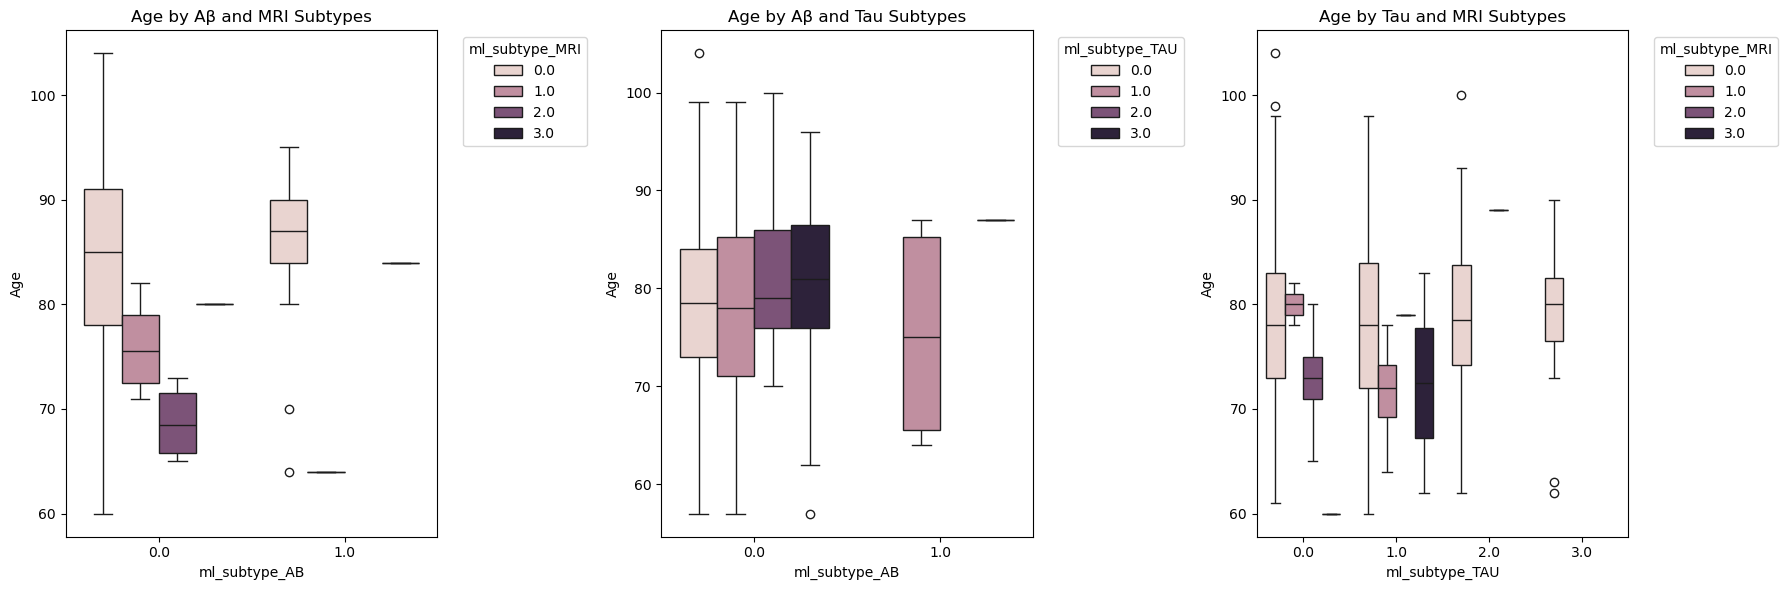


Age Summary: Aβ–MRI Subtype Pairs
                 n  median  mean  std   q25   q75
subtype_pair                                    
0.0-0.0       635   85.00 84.33 8.73 78.00 91.00
1.0-0.0        17   87.00 85.29 8.11 84.00 90.00

Age Summary: Aβ–Tau Subtype Pairs
                 n  median  mean   std   q25   q75
subtype_pair                                     
0.0-0.0       106   78.50 78.45  8.86 73.00 84.00
0.0-1.0        88   78.00 78.19 10.19 71.00 85.25
0.0-2.0        23   79.00 80.87  7.52 76.00 86.00
0.0-3.0        11   81.00 79.45 11.66 76.00 86.50

Age Summary: Tau–MRI Subtype Pairs
                 n  median  mean  std   q25   q75
subtype_pair                                    
0.0-0.0       207   78.00 78.44 7.78 73.00 83.00
1.0-0.0       181   78.00 77.50 8.69 72.00 84.00
2.0-0.0        46   78.50 79.37 7.32 74.25 83.75
3.0-0.0        19   80.00 78.68 7.10 76.50 82.50


In [34]:
def stats_pair(df, subtype_col1, subtype_col2, variable, min_group_size=10):
    # Create subtype pair column
    df = df.dropna(subset=[variable, subtype_col1, subtype_col2]).copy()
    df['subtype_pair'] = df[subtype_col1].astype(str) + '-' + df[subtype_col2].astype(str)
    group_counts = df['subtype_pair'].value_counts()
    valid_pairs = group_counts[group_counts >= min_group_size].index
    filtered_df = df[df['subtype_pair'].isin(valid_pairs)]

    # Summary stats
    summary = filtered_df.groupby('subtype_pair')[variable].agg(
        n='count',
        median='median',
        mean='mean',
        std='std',
        q25=lambda x: x.quantile(0.25),
        q75=lambda x: x.quantile(0.75)
    ).round(2)
    return summary

def plot_side_by_side_boxplots(
    df1, x1, hue1, y1, title1,
    df2, x2, hue2, y2, title2,
    df3, x3, hue3, y3, title3,
    figsize=(18, 6)
):
    plt.figure(figsize=figsize)

    plt.subplot(1, 3, 1)
    sns.boxplot(data=df1, x=x1, y=y1, hue=hue1)
    plt.title(title1)
    plt.xlabel(x1)
    plt.ylabel(y1)
    plt.legend(title=hue1, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.subplot(1, 3, 2)
    sns.boxplot(data=df2, x=x2, y=y2, hue=hue2)
    plt.title(title2)
    plt.xlabel(x2)
    plt.ylabel(y2)
    plt.legend(title=hue2, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.subplot(1, 3, 3)
    sns.boxplot(data=df3, x=x3, y=y3, hue=hue3)
    plt.title(title3)
    plt.xlabel(x3)
    plt.ylabel(y3)
    plt.legend(title=hue3, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


# Filter datasets for valid Age (e.g., Age > 0)
merged_ab_mri_clean_age = merged_ab_mri[merged_ab_mri[age] > 0]
merged_ab_tau_clean_age = merged_ab_tau[merged_ab_tau[age] > 0]
merged_tau_mri_clean_age = merged_tau_mri[merged_tau_mri[age] > 0]

# Plot side by side boxplots for Age
plot_side_by_side_boxplots(
    merged_ab_mri_clean_age, 'ml_subtype_AB', 'ml_subtype_MRI', age, 'Age by Aβ and MRI Subtypes',
    merged_ab_tau_clean_age, 'ml_subtype_AB', 'ml_subtype_TAU', age, 'Age by Aβ and Tau Subtypes',
    merged_tau_mri_clean_age, 'ml_subtype_TAU', 'ml_subtype_MRI', age, 'Age by Tau and MRI Subtypes'
)

# Get summary stats for Age by subtype pairs
age_ab_mri_summary = stats_pair(merged_ab_mri_clean_age, 'ml_subtype_AB', 'ml_subtype_MRI', age)
age_ab_tau_summary = stats_pair(merged_ab_tau_clean_age, 'ml_subtype_AB', 'ml_subtype_TAU', age)
age_tau_mri_summary = stats_pair(merged_tau_mri_clean_age, 'ml_subtype_TAU', 'ml_subtype_MRI', age)

print("\nAge Summary: Aβ–MRI Subtype Pairs\n", age_ab_mri_summary)
print("\nAge Summary: Aβ–Tau Subtype Pairs\n", age_ab_tau_summary)
print("\nAge Summary: Tau–MRI Subtype Pairs\n", age_tau_mri_summary)


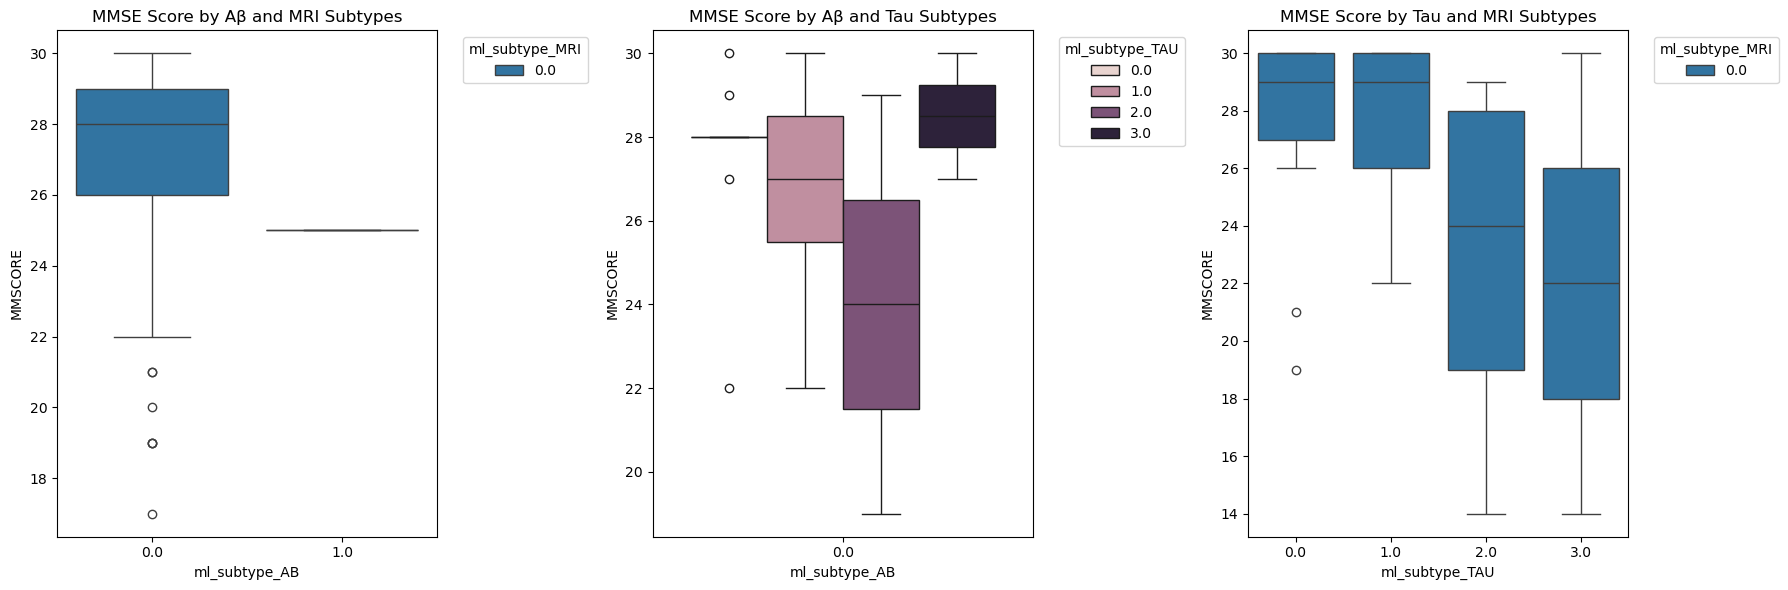


MMSE Score Summary: Aβ–MRI Subtype Pairs
                n  median  mean  std   q25   q75
subtype_pair                                   
0.0-0.0       91   28.00 26.89 3.06 26.00 29.00

MMSE Score Summary: Aβ–Tau Subtype Pairs
                n  median  mean  std   q25   q75
subtype_pair                                   
0.0-1.0       15   27.00 26.87 2.39 25.50 28.50

MMSE Score Summary: Tau–MRI Subtype Pairs
                n  median  mean  std   q25   q75
subtype_pair                                   
0.0-0.0       25   29.00 28.24 2.82 27.00 30.00
1.0-0.0       25   29.00 27.68 2.61 26.00 30.00


In [35]:
# Filter datasets for valid MMSE score (e.g., mmse_score > 0)
merged_ab_mri_clean_mmse = merged_ab_mri[merged_ab_mri[mmse_score] > 0]
merged_ab_tau_clean_mmse = merged_ab_tau[merged_ab_tau[mmse_score] > 0]
merged_tau_mri_clean_mmse = merged_tau_mri[merged_tau_mri[mmse_score] > 0]

# Plot side by side boxplots for MMSE score
plot_side_by_side_boxplots(
    merged_ab_mri_clean_mmse, 'ml_subtype_AB', 'ml_subtype_MRI', mmse_score, 'MMSE Score by Aβ and MRI Subtypes',
    merged_ab_tau_clean_mmse, 'ml_subtype_AB', 'ml_subtype_TAU', mmse_score, 'MMSE Score by Aβ and Tau Subtypes',
    merged_tau_mri_clean_mmse, 'ml_subtype_TAU', 'ml_subtype_MRI', mmse_score, 'MMSE Score by Tau and MRI Subtypes'
)

# Get summary stats for MMSE by subtype pairs
mmse_ab_mri_summary = stats_pair(merged_ab_mri_clean_mmse, 'ml_subtype_AB', 'ml_subtype_MRI', mmse_score)
mmse_ab_tau_summary = stats_pair(merged_ab_tau_clean_mmse, 'ml_subtype_AB', 'ml_subtype_TAU', mmse_score)
mmse_tau_mri_summary = stats_pair(merged_tau_mri_clean_mmse, 'ml_subtype_TAU', 'ml_subtype_MRI', mmse_score)

print("\nMMSE Score Summary: Aβ–MRI Subtype Pairs\n", mmse_ab_mri_summary)
print("\nMMSE Score Summary: Aβ–Tau Subtype Pairs\n", mmse_ab_tau_summary)
print("\nMMSE Score Summary: Tau–MRI Subtype Pairs\n", mmse_tau_mri_summary)


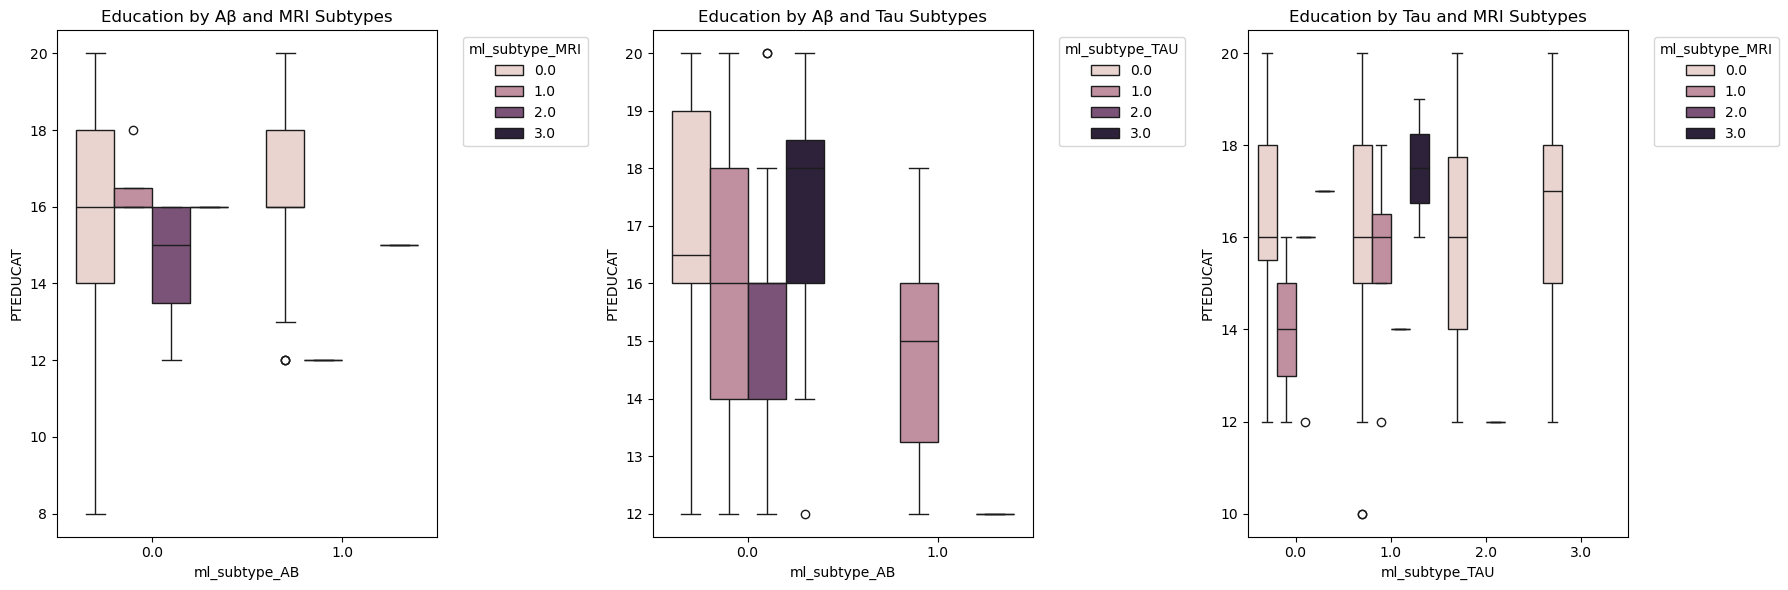


Education Summary: Aβ–MRI Subtype Pairs
                 n  median  mean  std   q25   q75
subtype_pair                                    
0.0-0.0       635   16.00 16.15 2.59 14.00 18.00
1.0-0.0        17   16.00 16.41 2.85 16.00 18.00

Education Summary: Aβ–Tau Subtype Pairs
                 n  median  mean  std   q25   q75
subtype_pair                                    
0.0-0.0       106   16.50 16.97 2.42 16.00 19.00
0.0-1.0        88   16.00 16.26 2.38 14.00 18.00
0.0-2.0        23   16.00 15.65 2.17 14.00 16.00
0.0-3.0        11   18.00 17.09 2.39 16.00 18.50

Education Summary: Tau–MRI Subtype Pairs
                 n  median  mean  std   q25   q75
subtype_pair                                    
0.0-0.0       207   16.00 16.72 2.41 15.50 18.00
1.0-0.0       181   16.00 16.38 2.35 15.00 18.00
2.0-0.0        46   16.00 15.48 2.33 14.00 17.75
3.0-0.0        19   17.00 16.32 2.52 15.00 18.00


In [36]:
# Filter datasets for PTEDUCAT > 0 or valid if needed
merged_ab_mri_clean = merged_ab_mri[merged_ab_mri[educ] > 0]
merged_ab_tau_clean = merged_ab_tau[merged_ab_tau[educ] > 0]
merged_tau_mri_clean = merged_tau_mri[merged_tau_mri[educ] > 0]

plot_side_by_side_boxplots(
    merged_ab_mri_clean, 'ml_subtype_AB', 'ml_subtype_MRI', educ, 'Education by Aβ and MRI Subtypes',
    merged_ab_tau_clean, 'ml_subtype_AB', 'ml_subtype_TAU', educ, 'Education by Aβ and Tau Subtypes',
    merged_tau_mri_clean, 'ml_subtype_TAU', 'ml_subtype_MRI', educ, 'Education by Tau and MRI Subtypes'
)

education_ab_mri_summary = stats_pair(merged_ab_mri_clean, 'ml_subtype_AB', 'ml_subtype_MRI', educ)
education_ab_tau_summary = stats_pair(merged_ab_tau_clean, 'ml_subtype_AB', 'ml_subtype_TAU', educ)
education_tau_mri_summary = stats_pair(merged_tau_mri_clean, 'ml_subtype_TAU', 'ml_subtype_MRI', educ)

print("\nEducation Summary: Aβ–MRI Subtype Pairs\n", education_ab_mri_summary)
print("\nEducation Summary: Aβ–Tau Subtype Pairs\n", education_ab_tau_summary)
print("\nEducation Summary: Tau–MRI Subtype Pairs\n", education_tau_mri_summary)


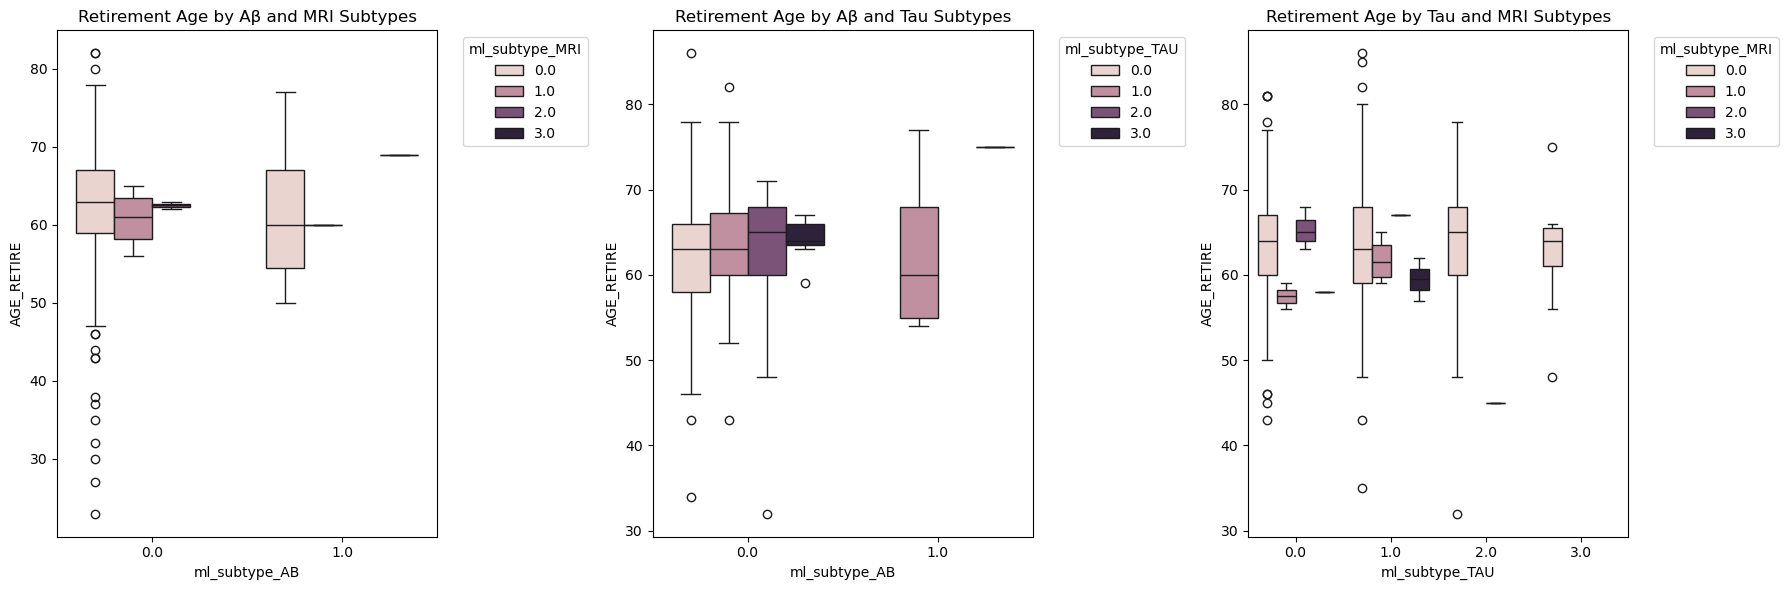


Retirement Age Summary: Aβ–MRI Subtype Pairs
                 n  median  mean  std   q25   q75
subtype_pair                                    
0.0-0.0       505   63.00 62.54 7.49 59.00 67.00
1.0-0.0        15   60.00 61.73 8.50 54.50 67.00

Retirement Age Summary: Aβ–Tau Subtype Pairs
                n  median  mean  std   q25   q75
subtype_pair                                   
0.0-0.0       77   63.00 61.95 7.81 58.00 66.00
0.0-1.0       68   63.00 64.01 6.65 60.00 67.25
0.0-2.0       21   65.00 62.52 8.88 60.00 68.00

Retirement Age Summary: Tau–MRI Subtype Pairs
                 n  median  mean  std   q25   q75
subtype_pair                                    
0.0-0.0       158   64.00 63.50 7.03 60.00 67.00
1.0-0.0       141   63.00 63.17 7.84 59.00 68.00
2.0-0.0        41   65.00 63.71 7.57 60.00 68.00
3.0-0.0        15   64.00 62.60 5.99 61.00 65.50


In [37]:
# Filter datasets for valid retire_age (e.g., retire_age > 0)
merged_ab_mri_clean_retire = merged_ab_mri[merged_ab_mri[retire_age] > 0]
merged_ab_tau_clean_retire = merged_ab_tau[merged_ab_tau[retire_age] > 0]
merged_tau_mri_clean_retire = merged_tau_mri[merged_tau_mri[retire_age] > 0]

# Plot side by side boxplots for retire_age
plot_side_by_side_boxplots(
    merged_ab_mri_clean_retire, 'ml_subtype_AB', 'ml_subtype_MRI', retire_age, 'Retirement Age by Aβ and MRI Subtypes',
    merged_ab_tau_clean_retire, 'ml_subtype_AB', 'ml_subtype_TAU', retire_age, 'Retirement Age by Aβ and Tau Subtypes',
    merged_tau_mri_clean_retire, 'ml_subtype_TAU', 'ml_subtype_MRI', retire_age, 'Retirement Age by Tau and MRI Subtypes'
)

# Get summary stats for retire_age by subtype pairs
retire_ab_mri_summary = stats_pair(merged_ab_mri_clean_retire, 'ml_subtype_AB', 'ml_subtype_MRI', retire_age)
retire_ab_tau_summary = stats_pair(merged_ab_tau_clean_retire, 'ml_subtype_AB', 'ml_subtype_TAU', retire_age)
retire_tau_mri_summary = stats_pair(merged_tau_mri_clean_retire, 'ml_subtype_TAU', 'ml_subtype_MRI', retire_age)

print("\nRetirement Age Summary: Aβ–MRI Subtype Pairs\n", retire_ab_mri_summary)
print("\nRetirement Age Summary: Aβ–Tau Subtype Pairs\n", retire_ab_tau_summary)
print("\nRetirement Age Summary: Tau–MRI Subtype Pairs\n", retire_tau_mri_summary)
